# 평가문항 - 상세기준

```markdown

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	
    데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.
    
2. Transformer 번역기 모델이 정상적으로 구동된다.	
    Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	
    제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.

```

In [1]:
# 파일 저장 커스텀 모듈

import sys
sys.path.append("../custom")

from importlib import reload
import custom_utils
reload(custom_utils)

from custom_utils import save_var, load_var


In [2]:
import time
import re
import os
import io
import random
import logging

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
import sentencepiece as spm

import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [138]:
print(tf.__version__)
print(np.__version__)
print(mpl.__version__)

2.6.0
1.21.4
3.4.3


In [ ]:
import konlpy
from konlpy import tag

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

In [4]:
class NameModifier:
    def __init__(self):
        self._name = ""
        self._prefix = ""
        self._postfix = ""
    def get_name_only(self): return f"{self._name}"
    def get_name(self): return f"{self._prefix}_{self._name}_{self._postfix}"
    def set_name(self, new_name): self._name = new_name
    def set_prefix(self, prefix): self._prefix = prefix
    def set_postfix(self, postfix): self._postfix = postfix
    def get_prefix(self): return self._prefix
    def get_postfix(self): return self._postfix

In [5]:
nm = NameModifier()
nm.set_prefix("t03")
nm.set_postfix("class")

In [6]:
prefix = nm.get_prefix()
postfix = nm.get_postfix()

prefix, postfix

('t03', 'class')

# Step 2. 데이터 정제 및 토큰화

set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 
데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

## Load Data

In [144]:
data_dir = 'data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

In [145]:
def load_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    return [kor, eng]

In [146]:
corpus = load_corpus(kor_path, eng_path)

In [147]:
len(corpus[0])

94123

정제 함수를 아래 조건을 만족하게 정의하세요.

- 모든 입력을 소문자로 변환합니다.  
- 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.  
- 문장부호 양옆에 공백을 추가합니다.  
- 문장 앞뒤의 불필요한 공백을 제거합니다.  

## Clean Data

In [163]:
class TextCleaner:
    def __init__(self):
        self.punct_space_re = re.compile(r"([?.!,])")
        self.multiple_spaces_re = re.compile(r'[" "]+')
        self.allowed_chars_re = re.compile(r"[^a-zA-Z가-힣?.!,]+")
        self.email_re = re.compile(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)')
        self.url_re = re.compile(r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+')
        self.korean_chars_re = re.compile(r'([ㄱ-ㅎㅏ-ㅣ]+)')
        self.html_tag_re = re.compile(r'<[^>]*>')
        self.special_chars_re = re.compile(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]')
        
    def clean_text(self, text):
        try:
            text = text.strip().lower()
            text = self.punct_space_re.sub(r" \1 ", text)
            text = self.multiple_spaces_re.sub(" ", text)
            text = self.allowed_chars_re.sub(" ", text)
            text = self.email_re.sub("", text)
            text = self.url_re.sub("", text)
            text = self.korean_chars_re.sub("", text)
            text = self.html_tag_re.sub("", text)
            text = self.special_chars_re.sub("", text)
            text = text.replace('\n', '.')
            return text
        except TypeError:
            print("Warning: Input was not a string or bytes-like object.")
            print(text)
            return text

    # 데이터 정제
    def clean_corpus(self, corpus):
        
        self.kor_corpus = []
        self.eng_corpus = []
        
        for kor, eng in zip(corpus[0], corpus[1]):
            self.kor_corpus.append(self.clean_text(kor))
            self.eng_corpus.append(self.clean_text(eng))

        self.corpus_cleaned = [self.kor_corpus, self.eng_corpus]
    
        return self.corpus_cleaned

    # get unique data for the corpus1 
    def get_unique_corpus1(self, corpus1, corpus2):
        seen_sentences = set()
        unique_corpus1 = []
        unique_corpus2 = []
        original_length = len(corpus1)
        for sent1, sent2 in zip(corpus1, corpus2):
            sent1_str = ' '.join(sent1)
            if sent1_str not in seen_sentences:
                seen_sentences.add(sent1_str)
                unique_corpus1.append(sent1)
                unique_corpus2.append(sent2)
        removed_length = original_length - len(unique_corpus1)
        print(f"removed: {removed_length}")
        return [unique_corpus1, unique_corpus2]


    # get unique data for the corpus1,2
    def get_unique_corpus_both(self, corpus):

        self.unique_corpus = self.get_unique_corpus1(corpus[1], corpus[0])  # for corpus2.
        self.unique_corpus = self.get_unique_corpus1(self.unique_corpus[1], self.unique_corpus[0])  # for corpus1.
    
        return self.unique_corpus

In [164]:
cleaner = TextCleaner()

In [165]:
corpus_cleaned = cleaner.clean_corpus(corpus)

In [150]:
random_indices = [random.randint(0, len(corpus_cleaned[0])) for _ in range(50)]
for i in random_indices:
    print(f"{i:5}: \n  - {corpus[0][i]} \n  - {corpus_cleaned[0][i]} \n  - {corpus[1][i]} \n  - {corpus_cleaned[1][i]}\n")

 3316: 
  - 지난해의 20%와 대비해, 금년에는 미국의 전체 인터넷 사용자의 25%가 온라인으로 물건을 구입했다. 
  - 지난해의 와 대비해  금년에는 미국의 전체 인터넷 사용자의 가 온라인으로 물건을 구입했다   
  - Internet users did some of their buying online this year, versus a fifth of them last year. 
  - internet users did some of their buying online this year  versus a fifth of them last year  

66211: 
  - 그는 대부분의 시간을 그림을 그리며 보내는 일반 남학생으로 사는 것도 재미있다고 밝혔다. 
  - 그는 대부분의 시간을 그림을 그리며 보내는 일반 남학생으로 사는 것도 재미있다고 밝혔다   
  - It's all very exciting, he said, for a self-described normal teen who spends a lot of time drawing. 
  - it s all very exciting  he said  for a self described normal teen who spends a lot of time drawing  

80302: 
  - 내가 찾은 검색어 
  - 내가 찾은 검색어 
  - The most popular one asks: 
  - the most popular one asks 

20694: 
  - 마이애미의 디자인 보존 단체가 이 지역의 아르데코 관광투어를 실시한다. 이 단체는 음성서비스를 휴대폰을 통해서도 아르데코를 접할 수 있도록 서비스를 개발했다. 
  - 마이애미의 디자인 보존 단체가 이 지역의 아르데코 관광투어를 실시한다  이 단체는 음성서비스를 휴대폰을 통해서도 아르데코를 접할 수 있도록 서비스를 개발했다   
  - The Miami Design Preservation League is offer

In [158]:
save_var(corpus_cleaned, f"{prefix}_corpus_cleaned_{postfix}")

In [15]:
corpus_cleaned = load_var(f"{prefix}_corpus_cleaned_{postfix}")

## Remove Duplicates

In [151]:
for i, s in enumerate(corpus_cleaned[0]):
    if len(s.split()) < 3:
        print(s, end=' '*4)

어휘     어휘     어휘     낙태는 불법이다       모르고 있습니다       네  보이는군요      디즈니사만이 아니다      유럽에서도 마찬가지이다      어휘     이것이 사실일까요      어휘     오차범위는 없었다      어휘     어휘     번역     어휘     번역     어휘     번역     번역     어휘     번역     어휘     번역     하루에 번    어휘     외딴 곳    어휘      월 안경     번역     번역     번역     어휘     번역     어휘     어휘     번역     어휘     번역     어휘     번역     어휘     번역     어휘     번역     번역                             향년 세였다        장난감 만들기      식품 과학자      소물리에      운동 트레이너      이벤트 기획자      오탈자 미확인    면접      지각    면접 이후     캐주얼 스타일      남자들      가족     행복의 역설     충분한 수면     순간순간을 즐기기      레스토랑 점원      판매원      구조대원      사무 보조원    음식    햇빛    보조식품    계획을 세운다        어미니의 실수      장소     판매 제품     판매 제품    과일      견과류    양파    코브     코브      산부인과     심장질환     유방암     백일해 백신      수두 백신     바리백스 varivax      대상포진     조스타백스 zostavax      홍역  이하선염     mmr     여행자의 질병      b형간염      노동의 붕괴          q     햇볕 쬐기      자원봉사      복식 호흡      차 마시기      권태기 극복      지압      숙면    첫인상     세부사항     첫인상     세부사항  

In [166]:
corpus_filtered = cleaner.get_unique_corpus_both(corpus_cleaned)

removed: 18671
removed: 863


In [167]:
len(corpus_filtered[0])

74589

In [159]:
save_var(corpus_filtered, f"{prefix}_corpus_filtered_{postfix}")

In [16]:
corpus_filtered = load_var(f"{prefix}_corpus_filtered_{postfix}")

## Limit Sentence Length

In [153]:
class SentenceLengthPlotter:
    def __init__(self, style="whitegrid", palette={"src": "pastel", "tgt": "RdPu"}):
        sns.set_style(style)
        self.palette = palette
    
    def _sentence_length(self, corpus):
        return [len(s.split()) if isinstance(s, str) else len(s) for s in corpus]

    def plot_length(self, src_corpus, tgt_corpus, bins=50, save_as=None):
        src_lengths = self._sentence_length(src_corpus)
        tgt_lengths = self._sentence_length(tgt_corpus)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
        
        sns.histplot(src_lengths, bins=bins, ax=axes[0], color=sns.color_palette(self.palette["src"])[0])
        axes[0].set_title('Korean Sentence Lengths')
        
        sns.histplot(tgt_lengths, bins=bins, ax=axes[1], color=sns.color_palette(self.palette["tgt"])[0])
        axes[1].set_title('English Sentence Lengths')
        
        for ax in axes:
            ax.set_yscale('log', nonpositive='clip')
            ax.set_xlabel('Length of Sentences')
            ax.set_ylabel('Number of Sentences (log scale)')
        
        plt.tight_layout()
        
        if save_as:
            fig.savefig(save_as, bbox_inches='tight')
        
        plt.show()

    def set_style(self, style="whitegrid"):
        sns.set_style(style)

    def set_palette(self, palette):
        self.palette = palette


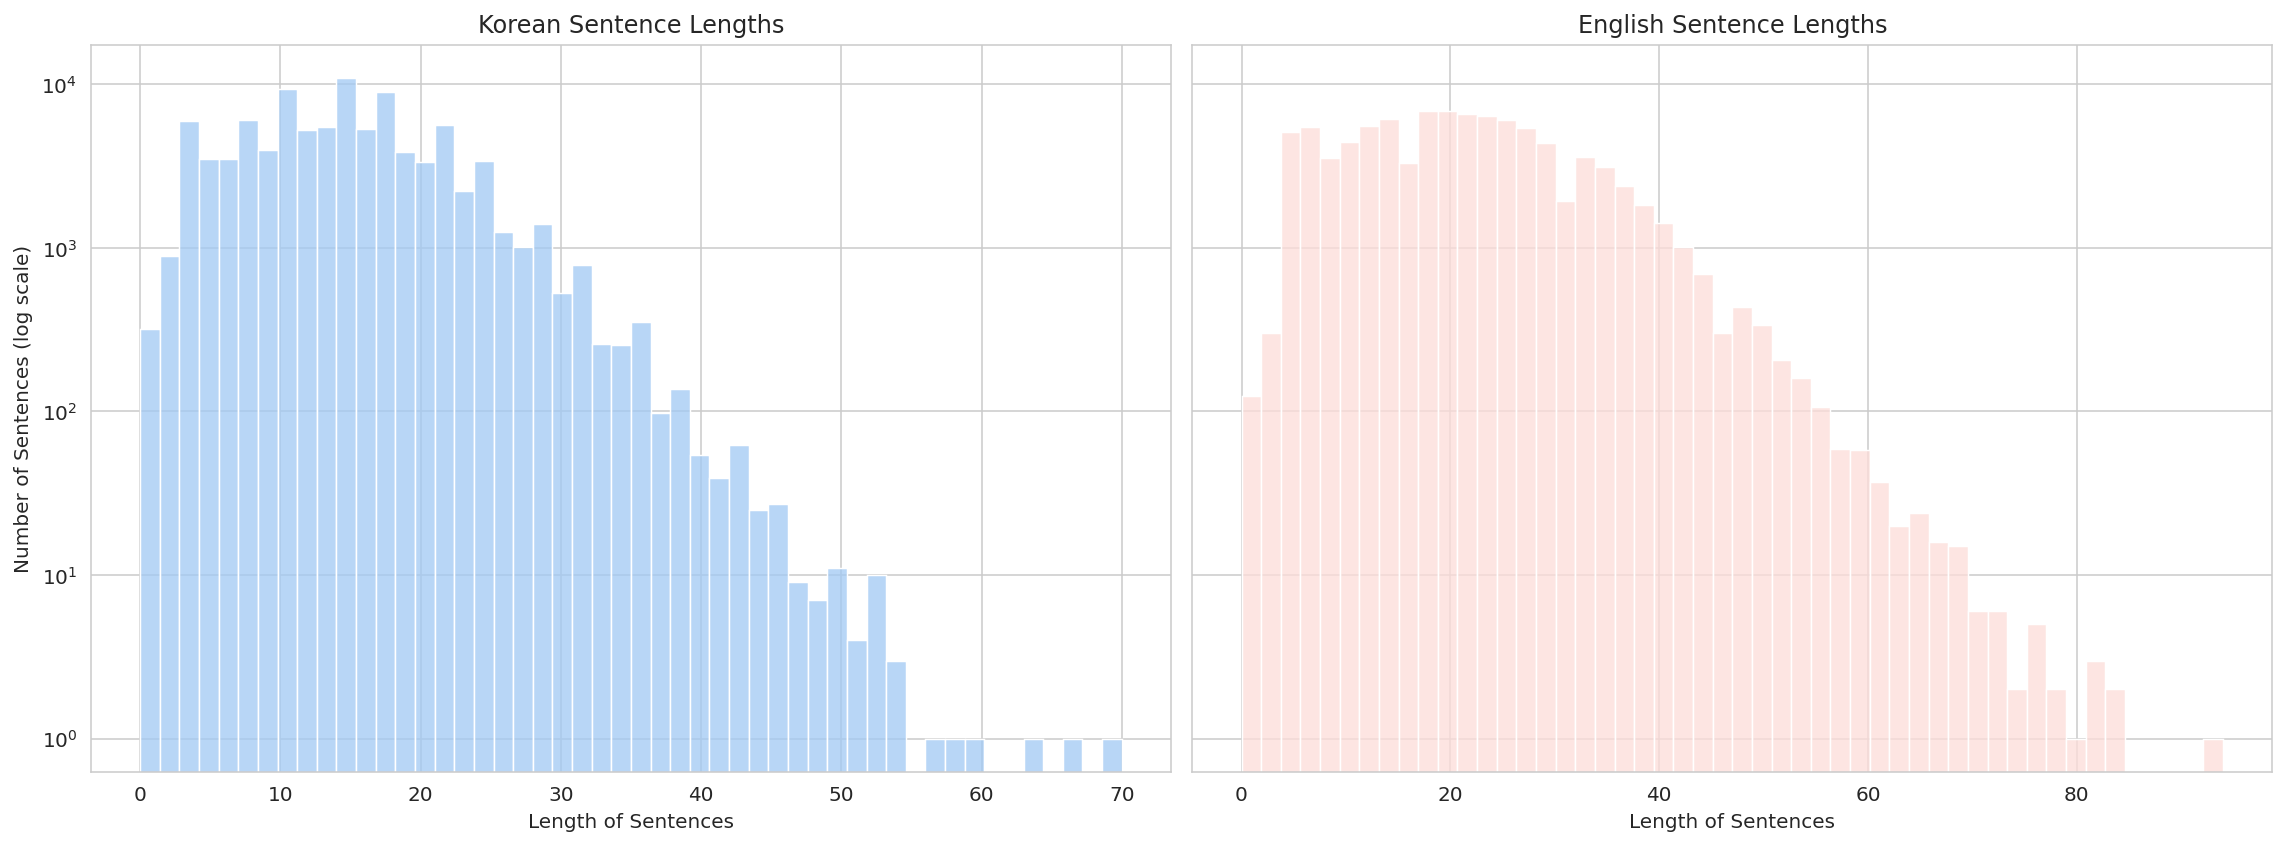

In [154]:
plotter = SentenceLengthPlotter()
plotter.plot_length(corpus_filtered[0], corpus_filtered[1])

In [155]:
for i, s in enumerate(corpus_filtered[0]):
    if len(s.split()) < 3:
        print(s, end=' '*4)

어휘     어휘     어휘     낙태는 불법이다       모르고 있습니다       네  보이는군요      디즈니사만이 아니다      유럽에서도 마찬가지이다      어휘     이것이 사실일까요      어휘     오차범위는 없었다      어휘     어휘     번역     어휘     번역     어휘     번역     번역     어휘     번역     어휘     번역     하루에 번    어휘     외딴 곳    어휘      월 안경     번역     번역     번역     어휘     번역     어휘     어휘     번역     어휘     번역     어휘     번역     어휘     번역     어휘     번역     번역                             향년 세였다        장난감 만들기      식품 과학자      소물리에      운동 트레이너      이벤트 기획자      오탈자 미확인    면접      지각    면접 이후     캐주얼 스타일      남자들      가족     행복의 역설     충분한 수면     순간순간을 즐기기      레스토랑 점원      판매원      구조대원      사무 보조원    음식    햇빛    보조식품    계획을 세운다        어미니의 실수      장소     판매 제품     판매 제품    과일      견과류    양파    코브     코브      산부인과     심장질환     유방암     백일해 백신      수두 백신     바리백스 varivax      대상포진     조스타백스 zostavax      홍역  이하선염     mmr     여행자의 질병      b형간염      노동의 붕괴          q     햇볕 쬐기      자원봉사      복식 호흡      차 마시기      권태기 극복      지압      숙면    첫인상     세부사항     첫인상     세부사항  

In [156]:
def cut_length(corpora, length, first=True, under=True):
    # applying first list or second list
    if first: first_corpus, second_corpus = corpora[0], corpora[1]
    else: first_corpus, second_corpus = corpora[1], corpora[0]

    # selecting index matching the condition
    if under: filtered_indices = [i for i, sentence in enumerate(first_corpus) if len(sentence.split()) >= length]
    else: filtered_indices = [i for i, sentence in enumerate(first_corpus) if len(sentence.split()) <= length]

    # matching the selected index
    filtered_first = [first_corpus[i] for i in filtered_indices]
    filtered_second = [second_corpus[i] for i in filtered_indices]
    
    if first: return [filtered_first, filtered_second]
    else: return [filtered_second, filtered_first]

In [157]:
corpus_cut = cut_length(corpus_filtered, 3)

In [158]:
for i, s in enumerate(corpus_cut[0]):
    if len(s.split()) < 5:
        print(s, end=' '*4)

선례가 하나 있다      그것은 큰 문제입니다       월이면 폐기될 미르 우주정거장    베트남의 호치민시를 방문한 클린턴    여러 상점에도 불이 붙었다      후임자는 발표되지 않았다      그러면 누가 북한을 지원했는가      라고 조던이 말했다      음악 교습비가 꼭 있어야합니까       그들의 정책 처방은 간단합니다      우리가 달에 착륙했는가      교회도 또한 도와 주었습니다      난 롱 죤 액티브라구      그게 우리의 강점이죠       이것은 대단한 발견입니다      하지만 브라질에도 제한은 있다      바로스 뿐만이 아니다      저녁식사 부분은 순조롭지 못하다     그녀는 단지 보균자일 뿐이다       하는 질문이 아닙니다      왜 이런 일이 일어나는가      간단히 말해서 항생제의 오용이다      누가 이런 정보를 관리하는가      공부를 위해서만 이용하겠다고 말입니다      어디엔가 그 균형점이 있다      생물학적 다양성은 감소되었다      환경법규의 도입은 고통스러운 과정이다       년 동안 이곳에 있었습니다       정말이지 아는 게 없습니다      이 기지는 냉전의 유물이다       어째서 그렇게 대단한 것입니까       여보  이쪽이야  아니면 저쪽이야      불매운동가들의 시선을 끌고 싶은가       나는 그가 정직하다고 생각한다      그들은 협상을 원했다      트루먼은 폭탄을 투하해야만 했다      walk 신분 직업     mba도 받지 않았다      카리스마는 속임수 같은 것이다      현명하게 사용하면 축복이다      그들의 비결은 무엇인가      박스데일도 동일한 기법을 사용한다       우리는 전속력으로 달려야 합니다      미 식품의약품국장은 밝혔습니다    카리스마적인 지도자들은 위험을 즐긴다      호주 측은 말하고 있습니다    대형 엔진과 아름다운 여인      추가로  명이 년에 감원되었다      아이들이 백설공주 를

In [159]:
len(corpus_cut[0])

92921

In [168]:
save_var(corpus_cut, f"{prefix}_corpus_cut_{postfix}")

In [20]:
corpus_cut = load_var(f"{prefix}_corpus_cut_{postfix}")

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다!  
토큰화에는 Sentencepiece를 활용하세요.   
첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다.   
최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요.   
en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.  
google/sentencepiece

```markdown
- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
- 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
- <PAD> : 0 / <BOS> : 1 / <EOS> : 2 / <UNK> : 3
```

In [21]:
class TokenizerGenerator:
    def __init__(self):
        logging.basicConfig(level=logging.INFO)
        self.pad_id = 0  #<pad> token을 0으로 설정
        self.bos_id = 1  #<start> token을 1으로 설정
        self.eos_id = 2  #<end> token을 2으로 설정
        self.unk_id = 3  #<unknown> token을 3으로 설정
        self.character_coverage = 1.0  # to reduce character set 
        
    def _make_params(self):
        templates = '--input={} --pad_id={} --bos_id={} --eos_id={} --unk_id={} --model_prefix={} --vocab_size={} --character_coverage={} --model_type={}'
        params = templates.format(
            self.inputs, self.pad_id, self.bos_id, self.eos_id,
            self.unk_id, self.prefix, self.vocab_size,
            self.character_coverage, self.model_type)
        return params
        
    def _write_to_temp(self, corpus):
        with open(self.inputs, 'w', encoding='utf-8') as f:
            for sentence in corpus:
                f.write(sentence + '\n')
        logging.info(f"Data written to temporary file: {self.inputs}")
        
    def _train_spm(self):
        params = self._make_params()
        spm.SentencePieceTrainer.Train(params)
        logging.info(f"Trained SentencePiece model saved as {self.prefix}.model")

    def generate_tokenizer(self, corpus, vocab_size, file_name_prefix="00", model_type="unigram"):

        self.prefix = f'{file_name_prefix}_spm'   # 저장될 tokenizer 모델에 붙는 이름
        self.vocab_size = vocab_size  # vocab 사이즈
        self.model_type = model_type  # Choose from unigram (default), bpe, char, or word
        self.inputs = f'{file_name_prefix}_temp.txt'  # temporary file name
        
        self._write_to_temp(corpus)
        self._train_spm()
        
        # Load the trained model
        tokenizer = spm.SentencePieceProcessor()
        if not tokenizer.Load(f'{self.prefix}.model'):
            logging.error("Failed to load the trained SentencePiece model.")
            return None

        # Clean up temporary files
        os.remove(self.inputs)
        logging.info(f"Temporary file {self.inputs} removed.")

        return tokenizer

In [22]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20_000
generator = TokenizerGenerator()

In [ ]:
ko_tokenizer = generator.generate_tokenizer(corpus_cut[0], SRC_VOCAB_SIZE, f"{prefix}_ko")
en_tokenizer = generator.generate_tokenizer(corpus_cut[1], TGT_VOCAB_SIZE, f"{prefix}_en")
en_tokenizer.set_encode_extra_options("bos:eos")

In [170]:
save_var(ko_tokenizer, f"{prefix}_ko_tokenizer_{postfix}")
save_var(en_tokenizer, f"{prefix}_en_tokenizer_{postfix}")

In [88]:
ko_tokenizer = load_var(f"{prefix}_ko_tokenizer_{postfix}")
en_tokenizer = load_var(f"{prefix}_en_tokenizer_{postfix}")

토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고,   
텐서 enc_train 과 dec_train 으로 변환하세요!    

(❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)  

In [71]:
from tqdm.notebook import tqdm

length_limit = 50

src_corpus = []
tgt_corpus = []

assert len(corpus_cut[0]) == len(corpus_cut[1])

for idx in tqdm(range(len(corpus_cut[0]))):
    src_tokens = ko_tokenizer.EncodeAsIds(corpus_cut[0][idx])
    tgt_tokens = en_tokenizer.EncodeAsIds(corpus_cut[1][idx])
    #if idx < 10: print(f"- {len(src_tokens)}: {src_tokens}, \n  {len(tgt_tokens)}: {tgt_tokens}\n")
    
    if len(src_tokens) <= length_limit and len(tgt_tokens) <= length_limit:
        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)
        
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/74366 [00:00<?, ?it/s]

In [171]:
save_var(src_corpus, f"{prefix}_src_corpus_{postfix}")
save_var(tgt_corpus, f"{prefix}_tgt_corpus_{postfix}")

In [172]:
save_var(enc_train, f"{prefix}_enc_train_{postfix}")
save_var(dec_train, f"{prefix}_dec_train_{postfix}")

In [23]:
prefix = nm.get_prefix()
postfix = nm.get_postfix()

In [24]:
tgt_corpus = load_var(f"{prefix}_tgt_corpus_{postfix}")
src_corpus = load_var(f"{prefix}_src_corpus_{postfix}")
enc_train = load_var(f"{prefix}_enc_train_{postfix}")
dec_train = load_var(f"{prefix}_dec_train_{postfix}")

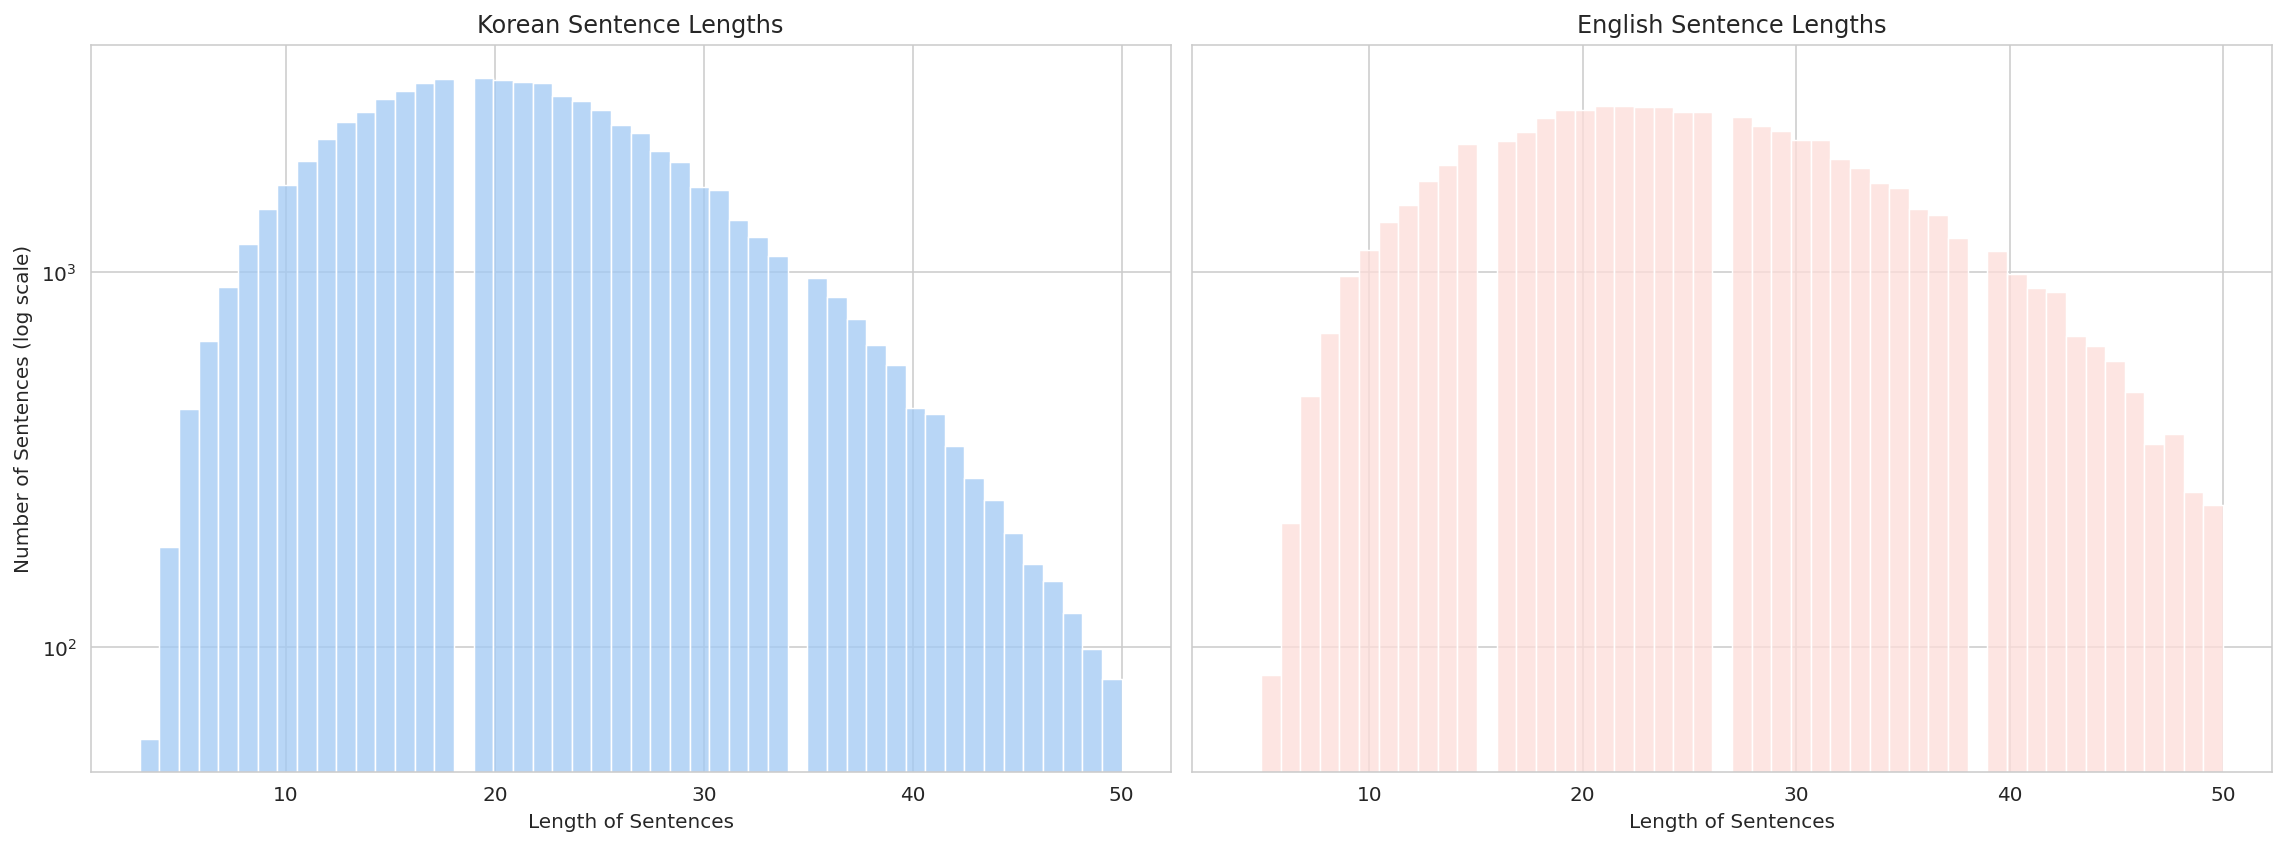

In [25]:
plotter = SentenceLengthPlotter()
plotter.plot_length(src_corpus, tgt_corpus, bins=50)

In [74]:
len(src_corpus)

72406

# Step 3. 모델 설계

## Positional Encoding

In [27]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

## Multi-head Attention

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [29]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## Encoder

In [30]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [31]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

## Decoder

In [32]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

In [33]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

## Transformer

In [34]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [35]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

# Step 4. 훈련하기

2 Layer를 가지는 Transformer를 선언하세요.

(하이퍼파라미터는 자유롭게 조절합니다.)

## Hyperparameters

In [116]:
# 하이퍼파라미터 설정
BATCH_SIZE = 64
EPOCHS = 20
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
pos_len = 200

# Transformer 객체 생성
transformer = Transformer(n_layers=n_layers,
                          d_model=d_model,
                          n_heads=n_heads,
                          d_ff=d_ff,
                          src_vocab_size=SRC_VOCAB_SIZE,
                          tgt_vocab_size=TGT_VOCAB_SIZE,
                          pos_len=pos_len,
                          dropout=dropout,
                          shared=True)

In [117]:
transformer.load_weights(f"{prefix}_transformer_ep20_{postfix}.ckpt")

## Learning Rate

논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고,   
이를 포함하는 Adam Optimizer를 선언하세요. 

(Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)

In [37]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [39]:
learning_rate = LearningRateScheduler(512)  # 512
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

## Loss

Loss 함수를 정의하세요.  
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. 

(트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## Train_step

train_step 함수를 정의하세요.  
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

In [119]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## Train

학습을 진행합니다.  
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!  

1. 오바마는 대통령이다.
2. 시민들은 도시 속에 산다.
3. 커피는 필요 없다.
4. 일곱 명의 사망자가 발생했다.

Translations
> 1. obama is the president elect .
> 2. they are in the city .
> 3. they don t need to be a lot of drink .
> 4. seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3

Training Parameters
> Warmup Steps: 4000
> Batch Size: 64
> Epoch At: 5

In [42]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [92]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = cleaner.clean_text(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [44]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    results = {
        "pieces": pieces,
        "result": result,
        "enc_attns": enc_attns,
        "dec_attns": dec_attns,
        "dec_enc_attns": dec_enc_attns,
    }

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        
    return results

translate() 함수의 plot_attention 변수를 True 로 주면 번역 결과에 대한 Attention Map을 시각화 해볼 수 있습니다.

## train_model

In [85]:
# 학습

from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 10

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

losses = []
training_results = []

In [46]:
def train_model(model, enc_train, dec_train, optimizer, epochs, batch_size, translate_func, examples):
    losses = []
    training_result = []
    
    for epoch in range(epochs):
        total_loss = 0
        
        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(enc_train[idx:idx+batch_size],
                        dec_train[idx:idx+batch_size],
                        model,
                        optimizer)

            total_loss += batch_loss
            loss = (total_loss.numpy() / (batch + 1))
            losses.append(loss)
                    
            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % loss)

        result = []
        for example in examples:
            result.append(translate_func(example, model, ko_tokenizer, en_tokenizer))
        training_result.append(result)

    return losses, training_result


## Train & Results

### 1:

In [37]:
losses, training_result = train_model(
    model=transformer, enc_train=enc_train, dec_train=dec_train, optimizer=optimizer, 
    epochs=EPOCHS, batch_size=BATCH_SIZE, translate_func=translate, examples=examples)

  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president barack obama s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city solar mountain
Input: 커피는 필요 없다.
Predicted translation: the company is not a new coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in a death toll


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president roh moo hyun
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s city is the only city s
Input: 커피는 필요 없다.
Predicted translation: coffee shops are not a new coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the killing of nine people and killed


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of towns are
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: sunday s death toll was killed and the deadliest attack


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is president
Input: 시민들은 도시 속에 산다.
Predicted translation: they are
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and wounded


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the crowd is building
Input: 커피는 필요 없다.
Predicted translation: coffee isnd at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were wounded


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s president he s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s theme is a heavy
Input: 커피는 필요 없다.
Predicted translation: there is little need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in seven deaths


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president barack obama is down to get him
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is stretching to the city
Input: 커피는 필요 없다.
Predicted translation: there is no need for seat
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed friday the disaster official said


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president reagan
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is complex
Input: 커피는 필요 없다.
Predicted translation: there is need for peru s short term need to be need for peru such fraud
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died saturday


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president
Input: 시민들은 도시 속에 산다.
Predicted translation: sometimes its city will hurt the city
Input: 커피는 필요 없다.
Predicted translation: all of coffee was need for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the babies are prime minps
Input: 커피는 필요 없다.
Predicted translation: there is nothing need for civilian coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven seven seven deaths were reported in seven deaths


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s president
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are prime in the r
Input: 커피는 필요 없다.
Predicted translation: there is no need for this acceptable
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were reported saturday


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: their lives are
Input: 커피는 필요 없다.
Predicted translation: it s all anyway need for sex need for sex education
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were reported saturday by the seven death toll in seven at seven least seven people were reported without the five deaths


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president obama is down at the president
Input: 시민들은 도시 속에 산다.
Predicted translation: babies are street in the town
Input: 커피는 필요 없다.
Predicted translation: there is no need for anyway
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven at least seven deaths


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president
Input: 시민들은 도시 속에 산다.
Predicted translation: some of the city s soldiers are taking a target in the town
Input: 커피는 필요 없다.
Predicted translation: it should be inappropriate for the g nominated take
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven at least seven people saturday


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the unity city is
Input: 커피는 필요 없다.
Predicted translation: there is a coffee place need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people were killed


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president he
Input: 시민들은 도시 속에 산다.
Predicted translation: city is of bitter new won
Input: 커피는 필요 없다.
Predicted translation: it s all seat
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the seven seven of the seven deaths that claimed


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens of the city of san made sense
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people were reported saturday that nine deaths were reported


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens search for the city
Input: 커피는 필요 없다.
Predicted translation: there sn t need forn ask for this need forn need for all
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the dead were reported saturday


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of t drew applause
Input: 커피는 필요 없다.
Predicted translation: there is nothing need for north korean beach sex need for sex need for
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed seven people


  0%|          | 0/1121 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is feet has a soldiers in the city
Input: 커피는 필요 없다.
Predicted translation: the don t need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven seven other people were reported missing


Input: 오바마는 대통령이다.
Predicted translation: obama
Encoder Layer 1


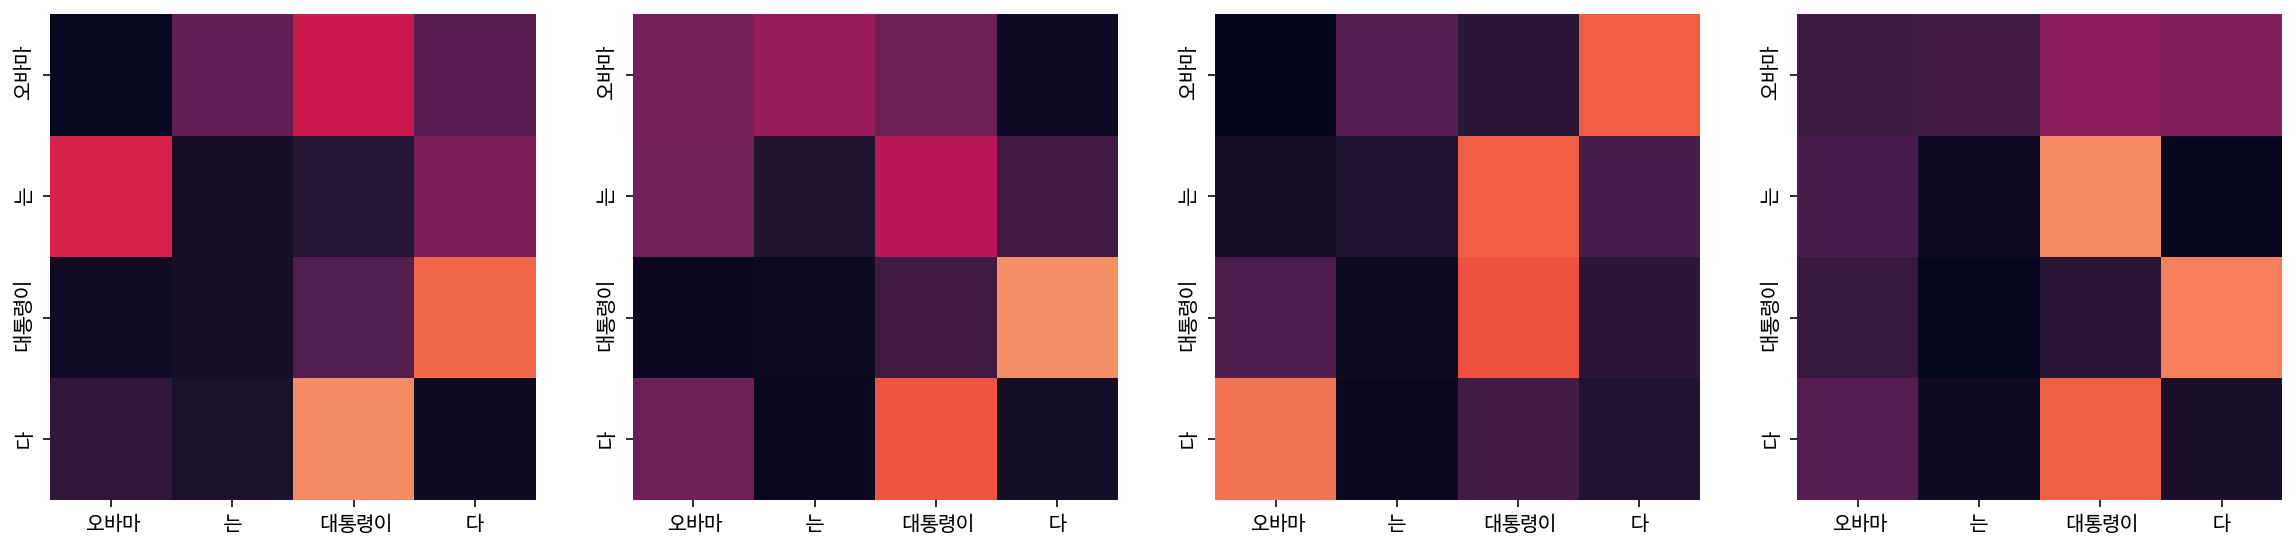

Encoder Layer 2


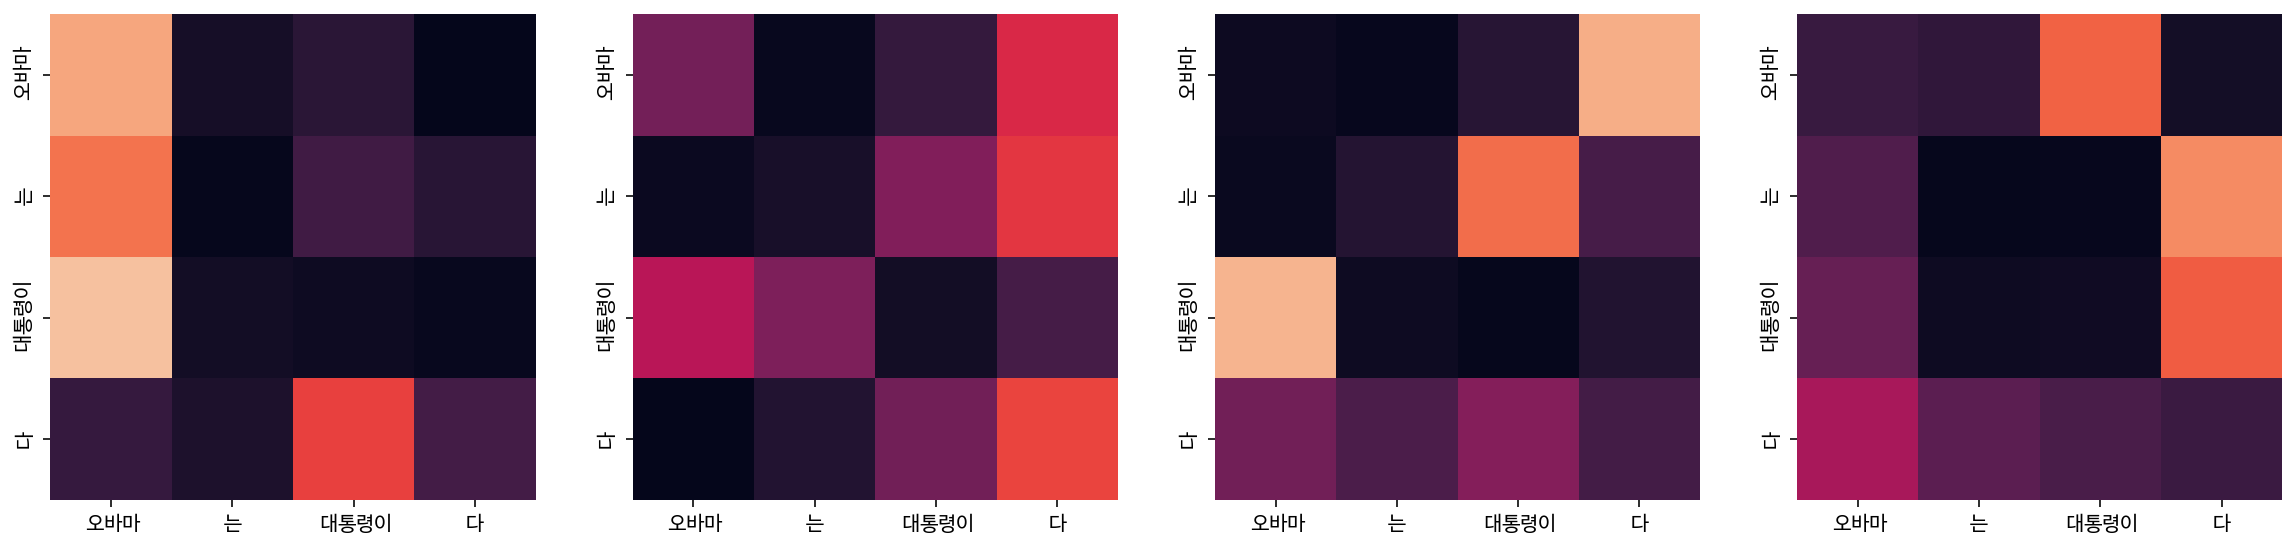

Decoder Self Layer 1


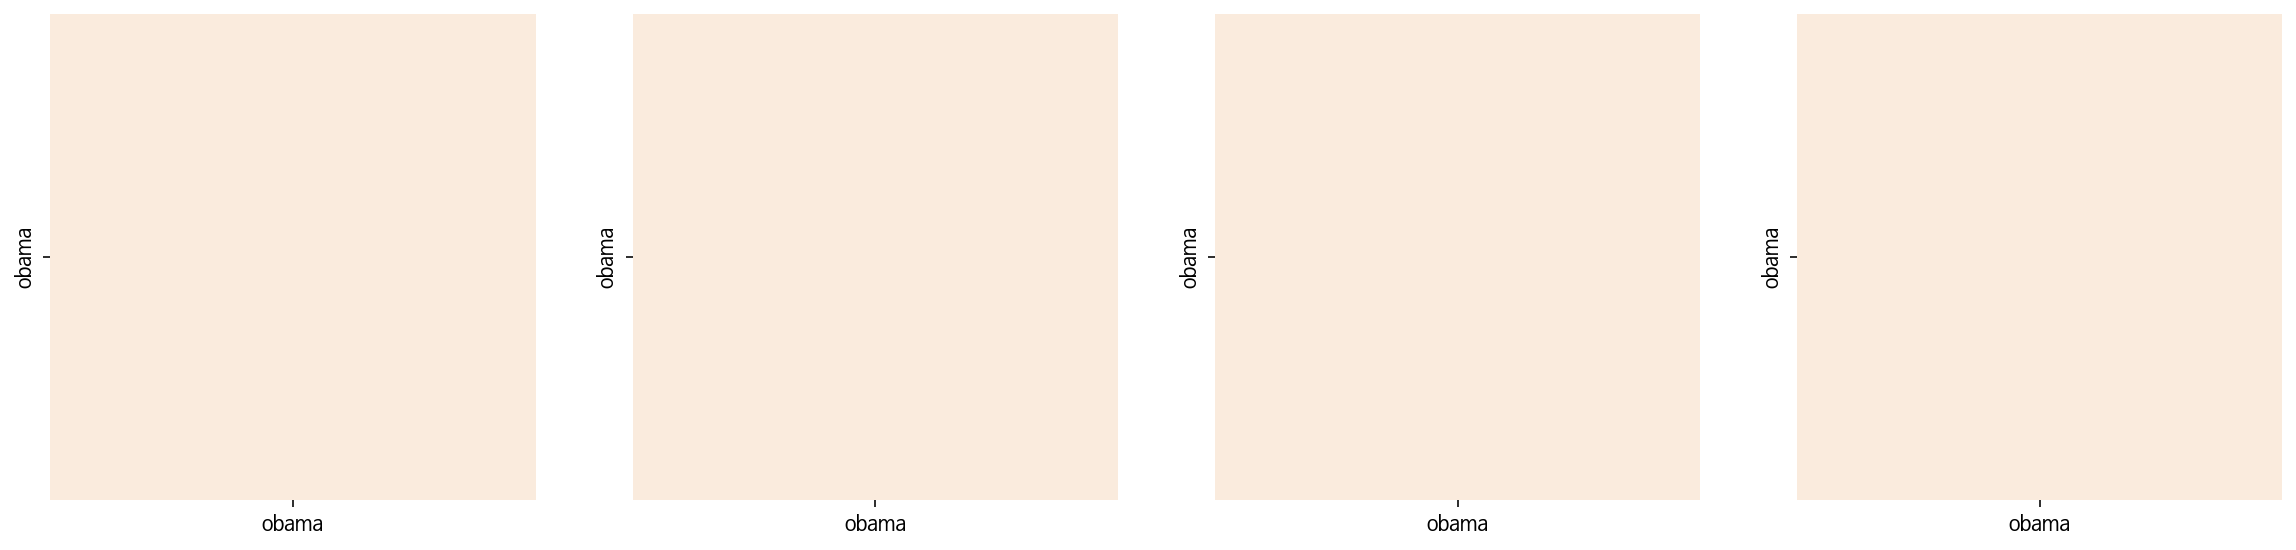

Decoder Src Layer 1


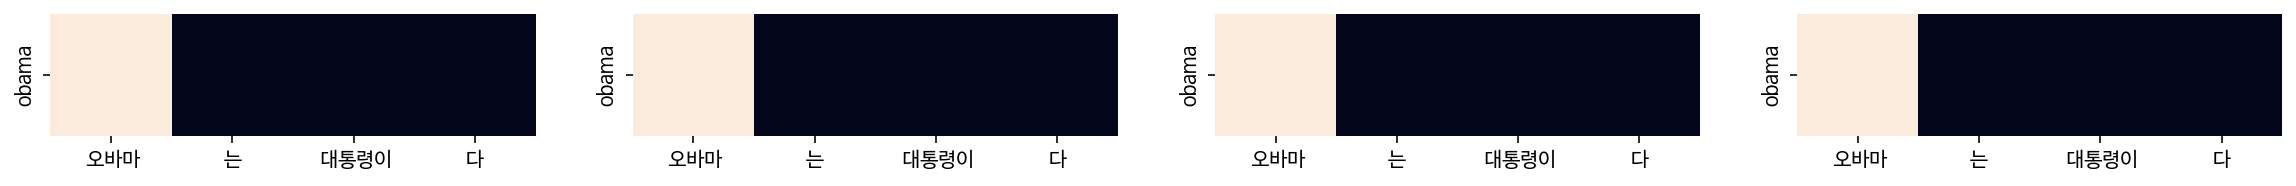

Decoder Self Layer 2


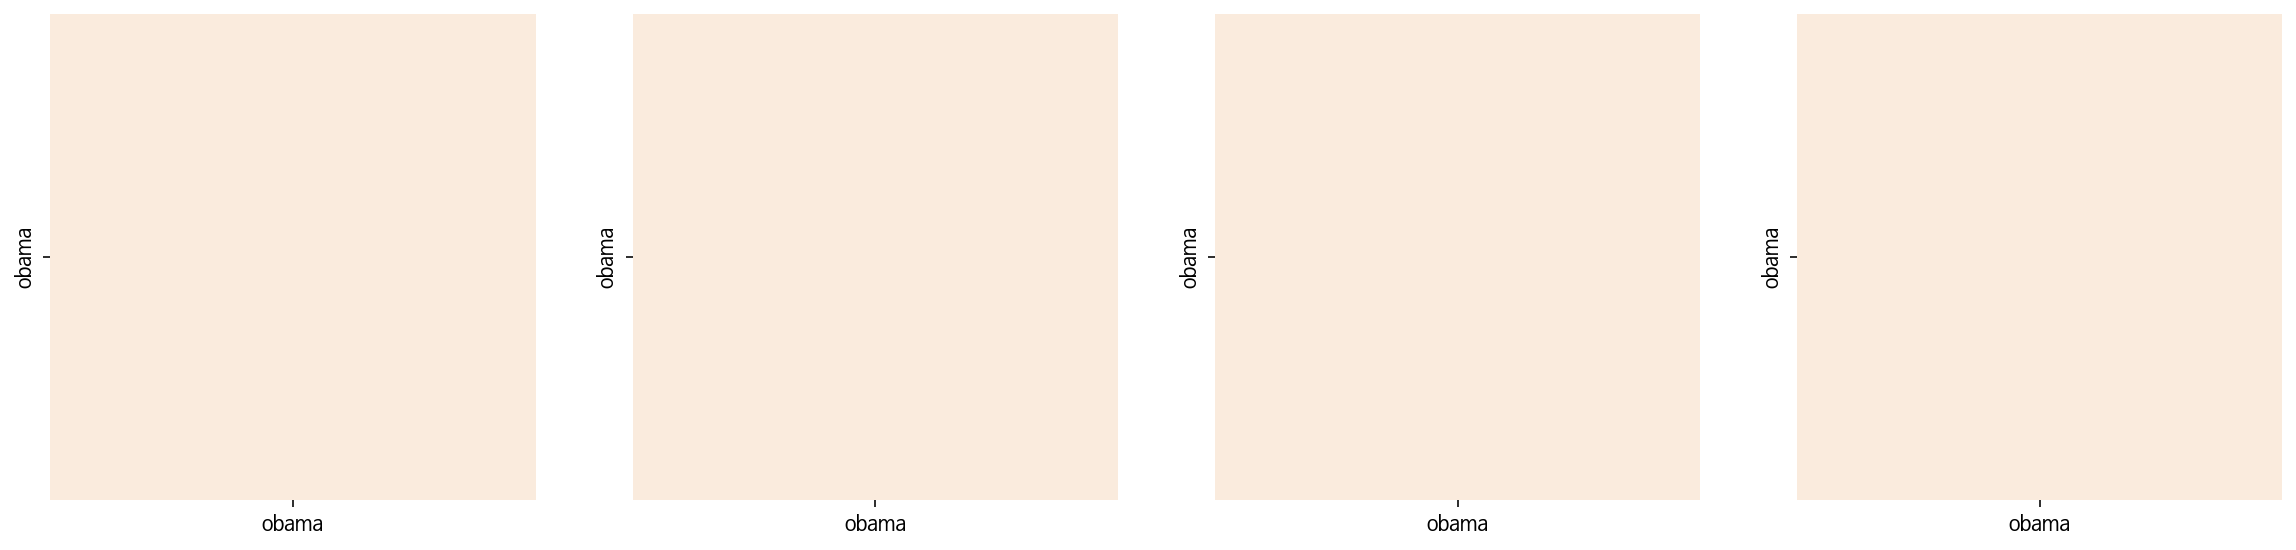

Decoder Src Layer 2


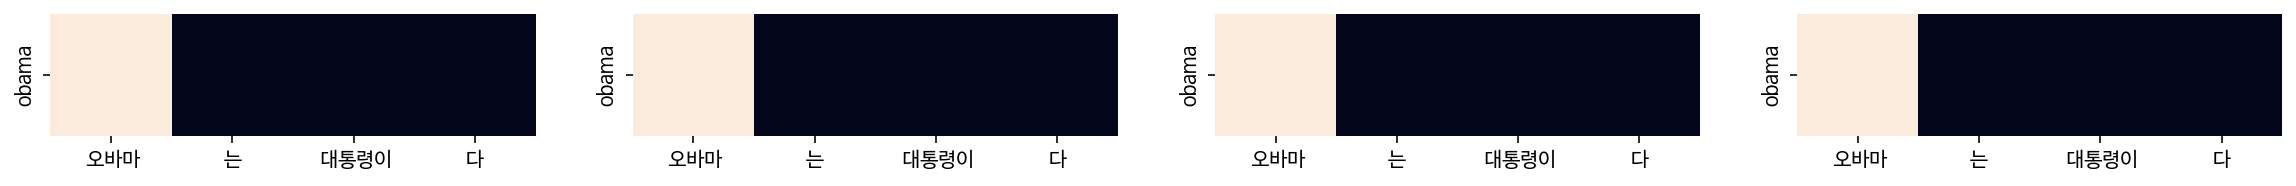

Input: 시민들은 도시 속에 산다.
Predicted translation: the city is feet has a soldiers in the city
Encoder Layer 1


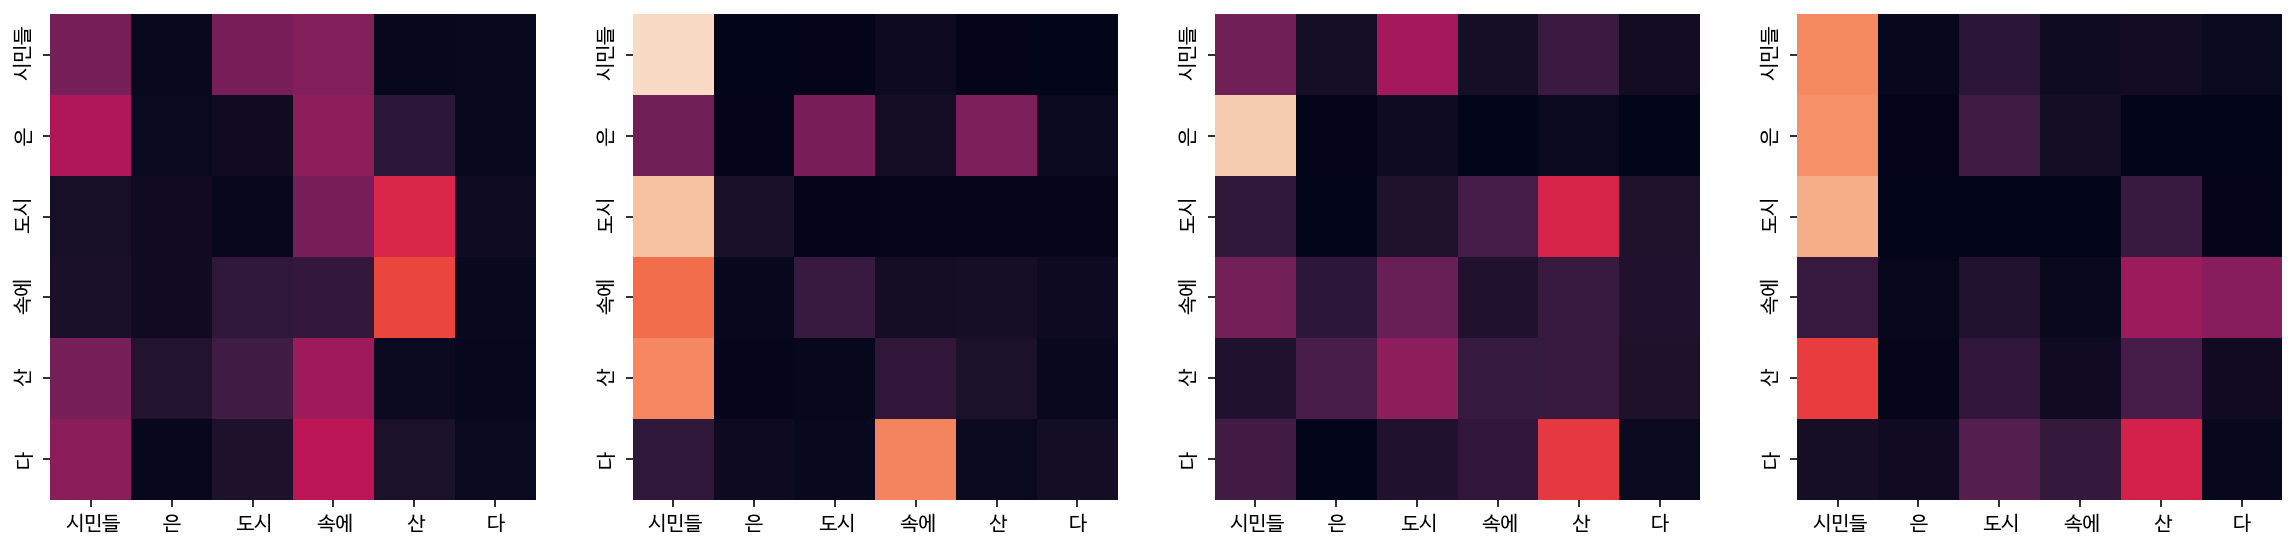

Encoder Layer 2


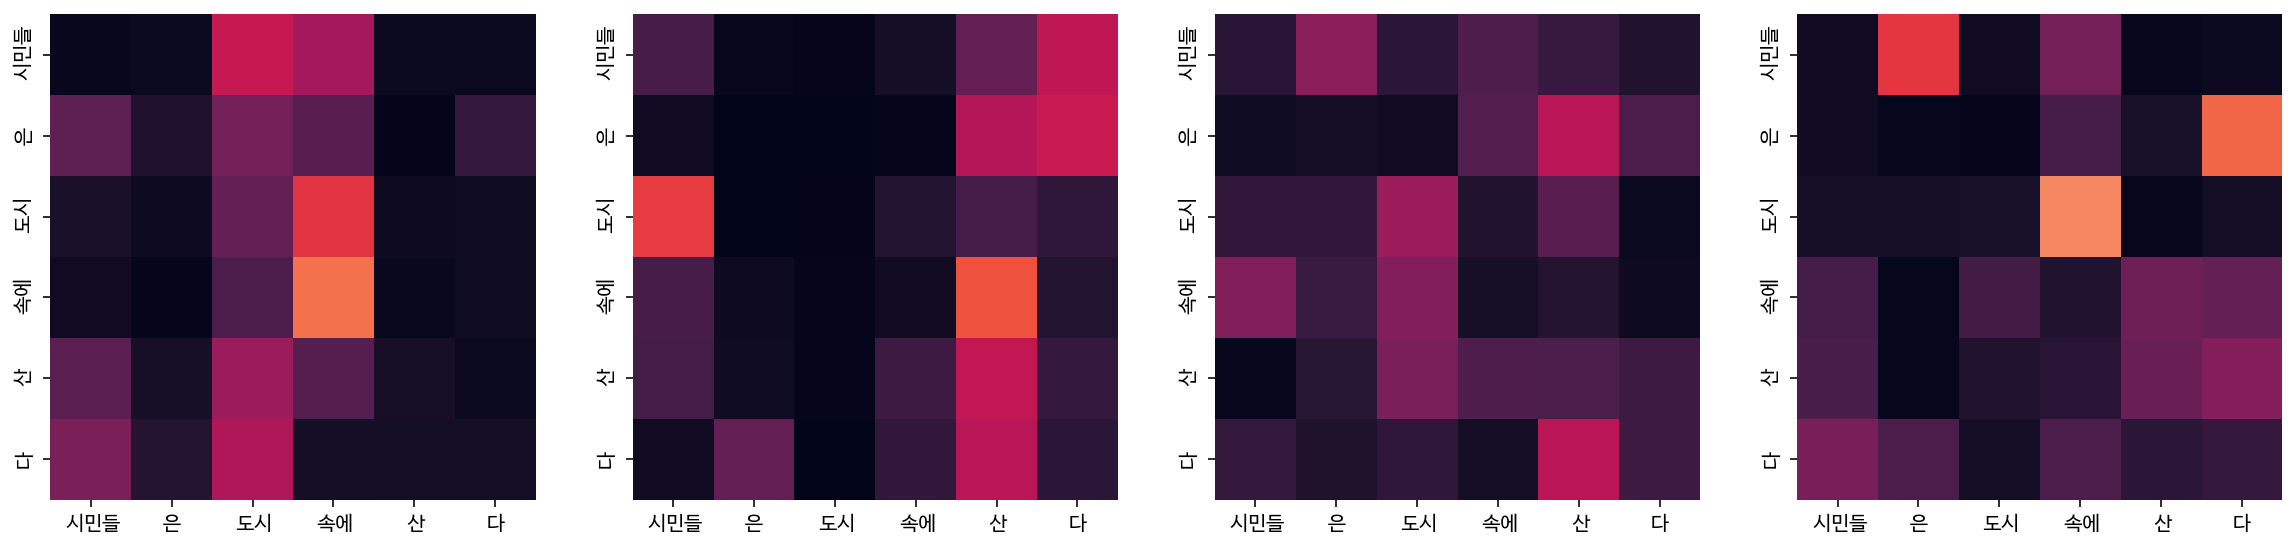

Decoder Self Layer 1


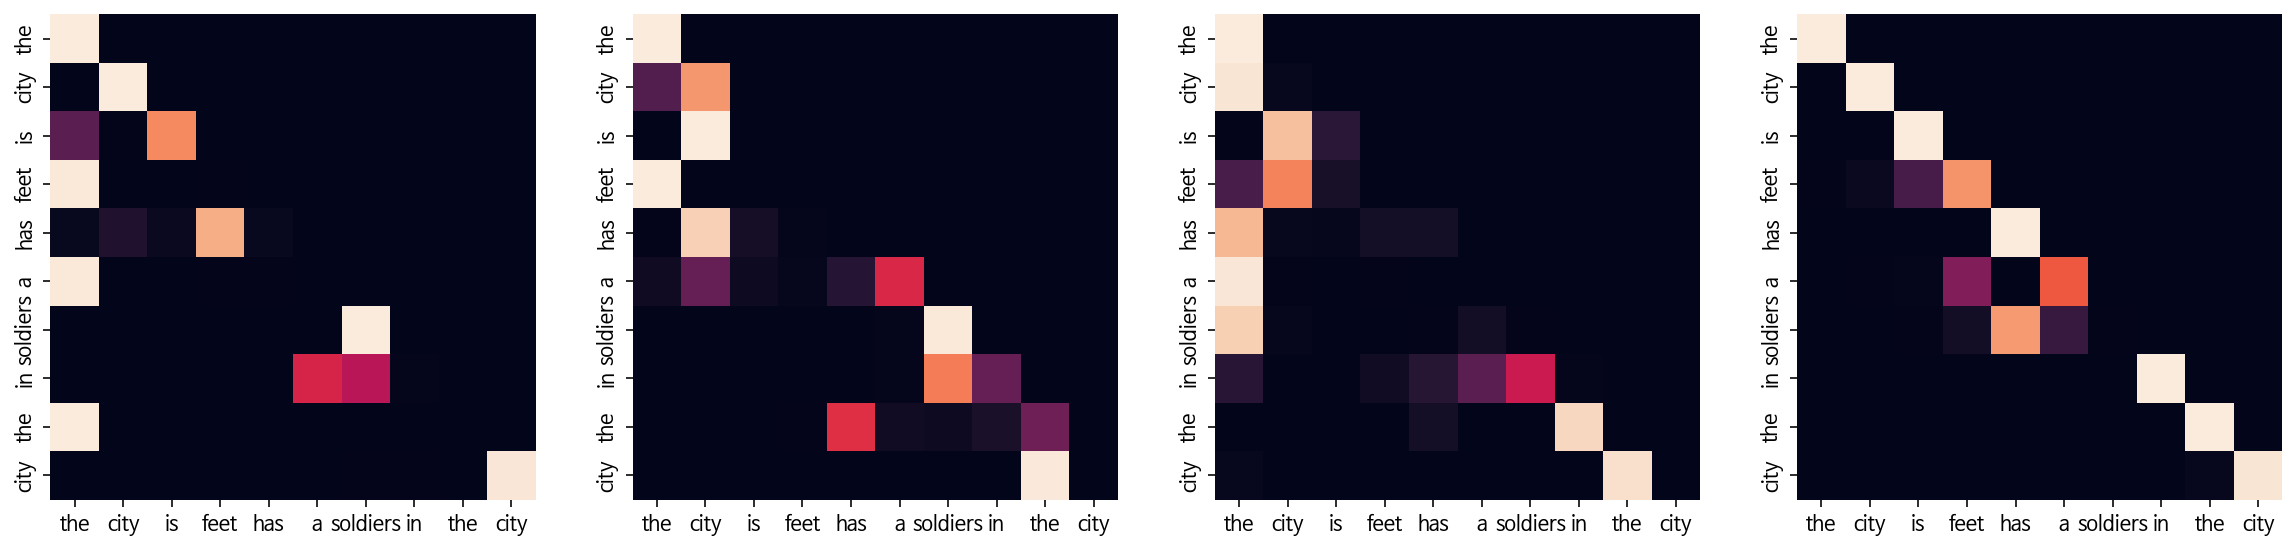

Decoder Src Layer 1


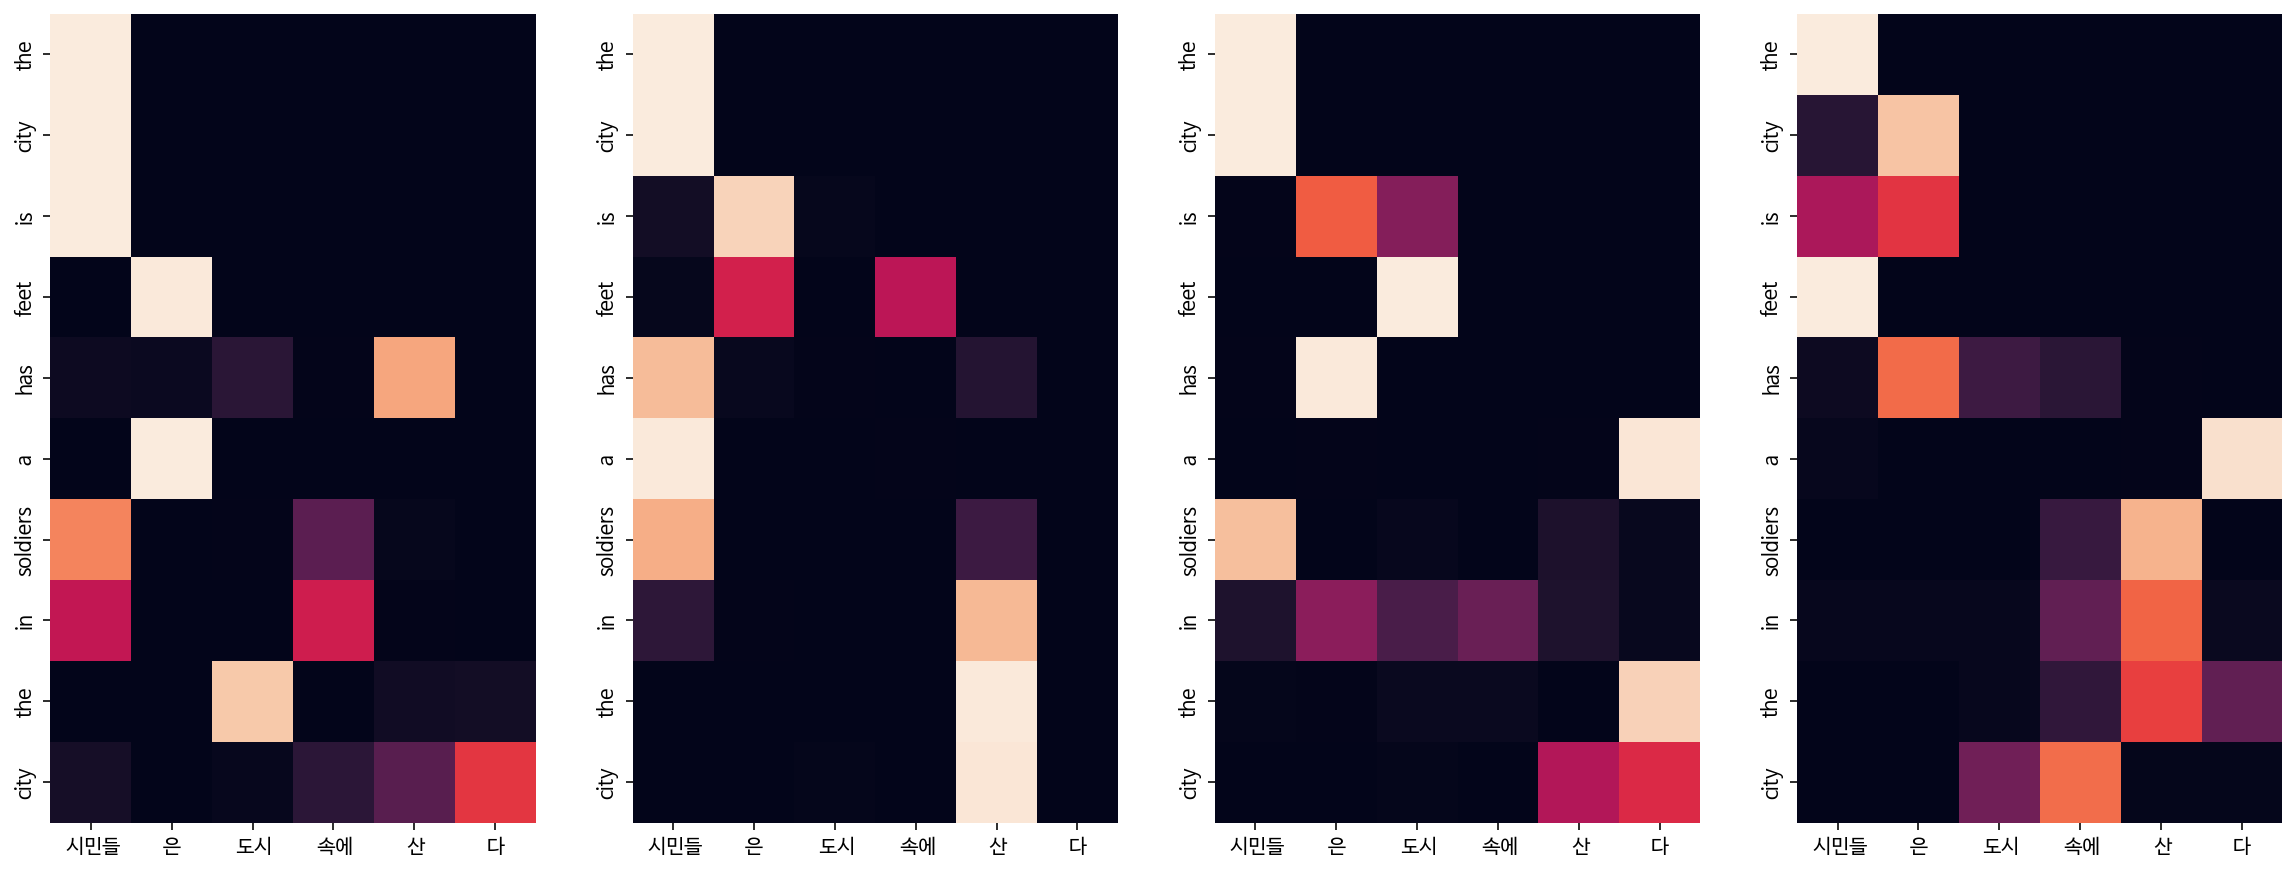

Decoder Self Layer 2


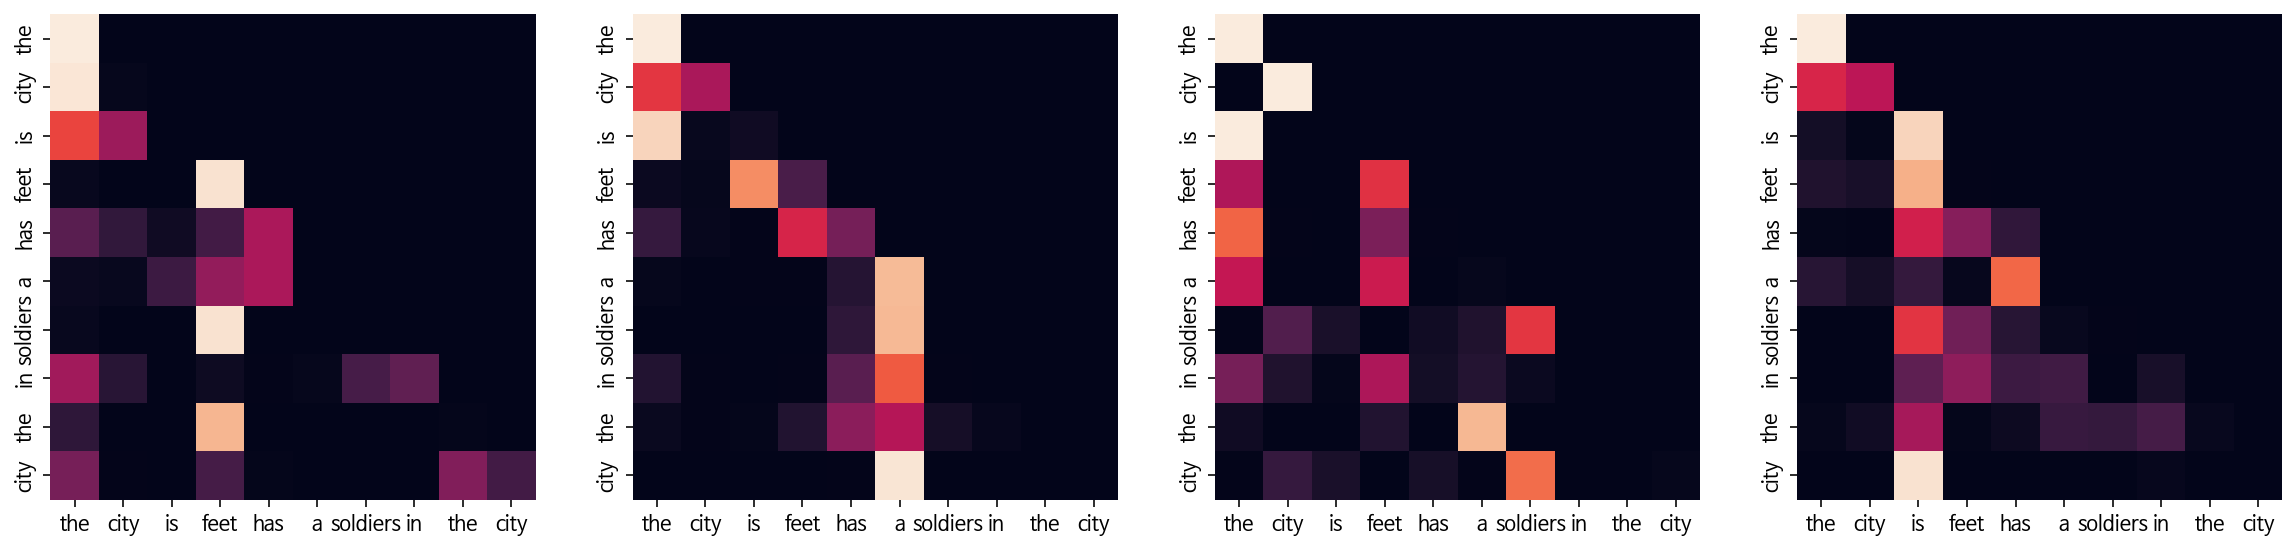

Decoder Src Layer 2


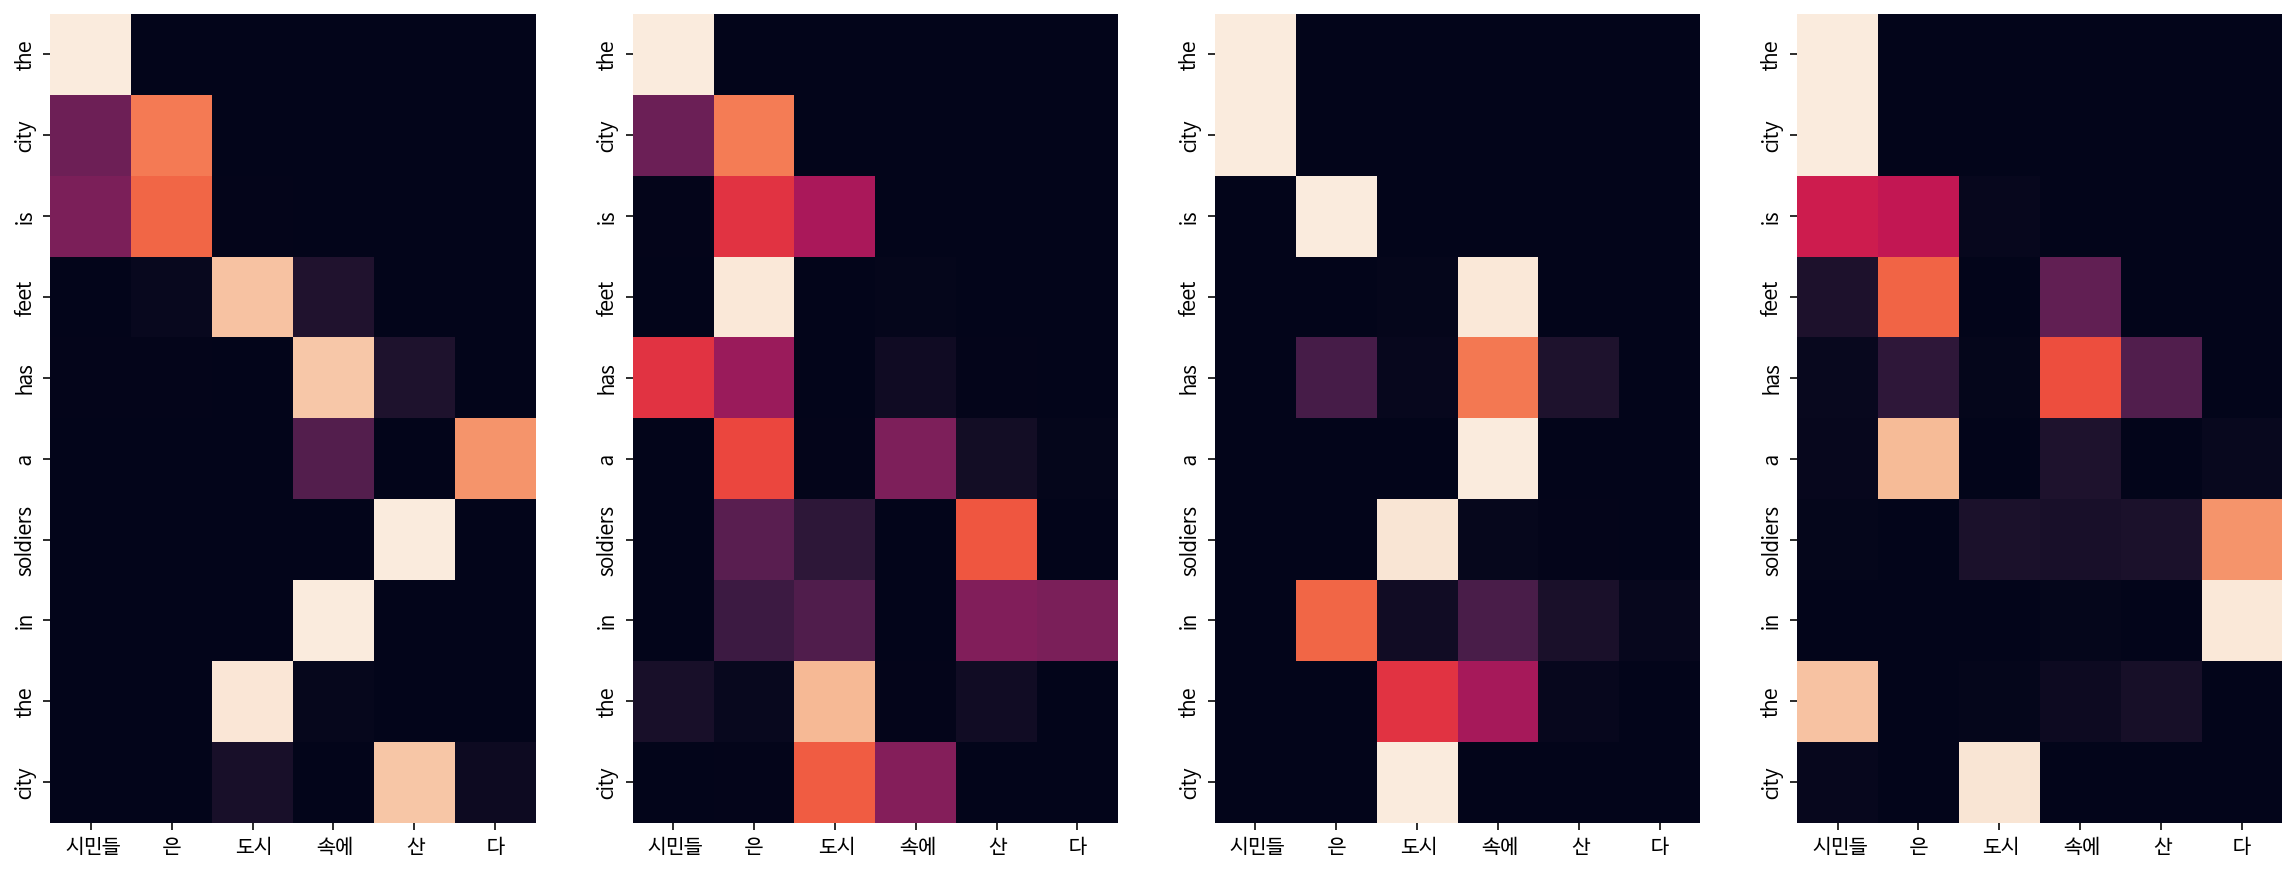

Input: 커피는 필요 없다.
Predicted translation: the don t need for coffee
Encoder Layer 1


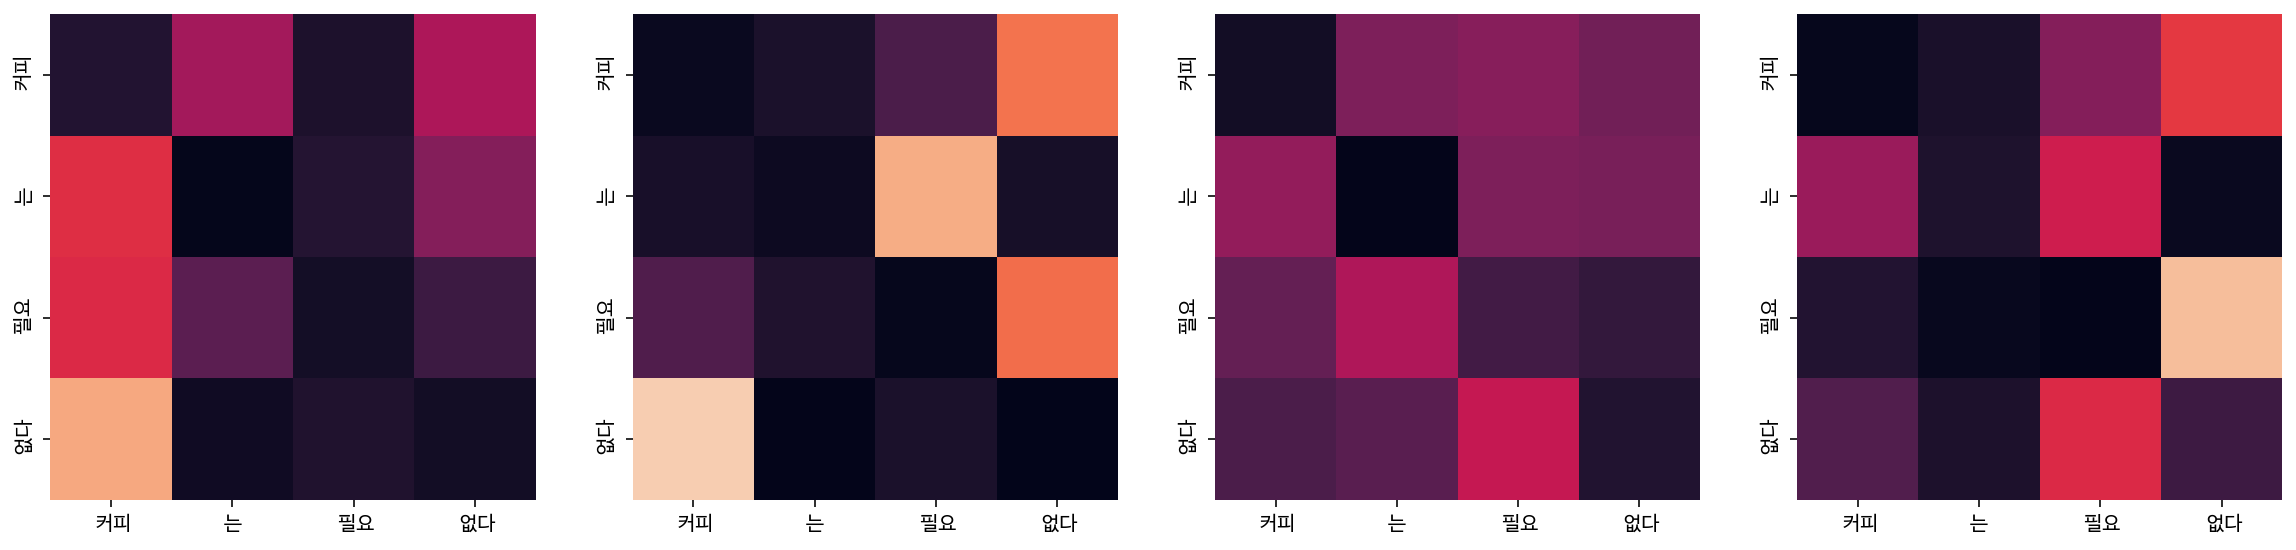

Encoder Layer 2


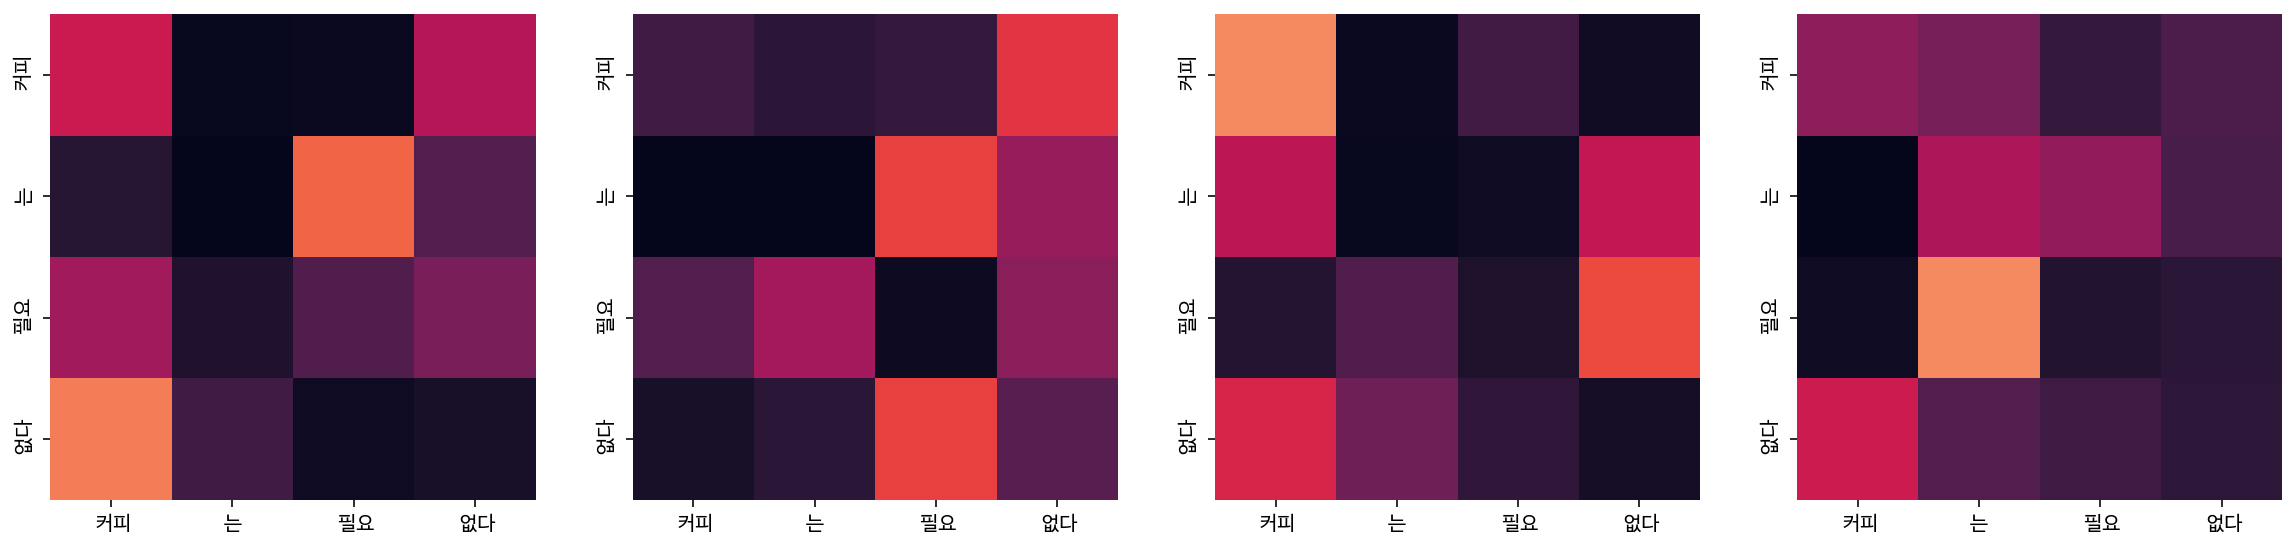

Decoder Self Layer 1


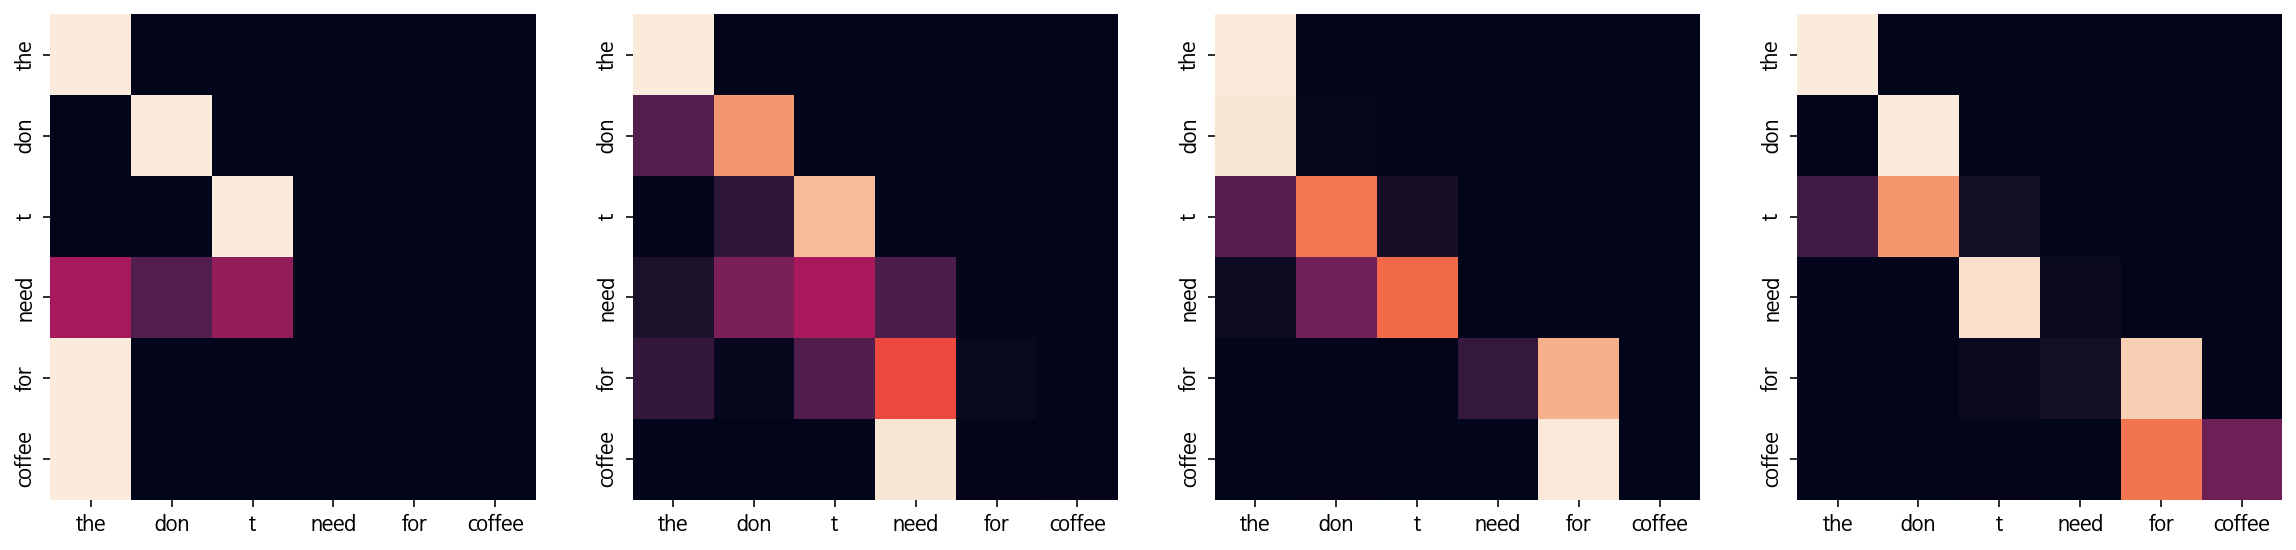

Decoder Src Layer 1


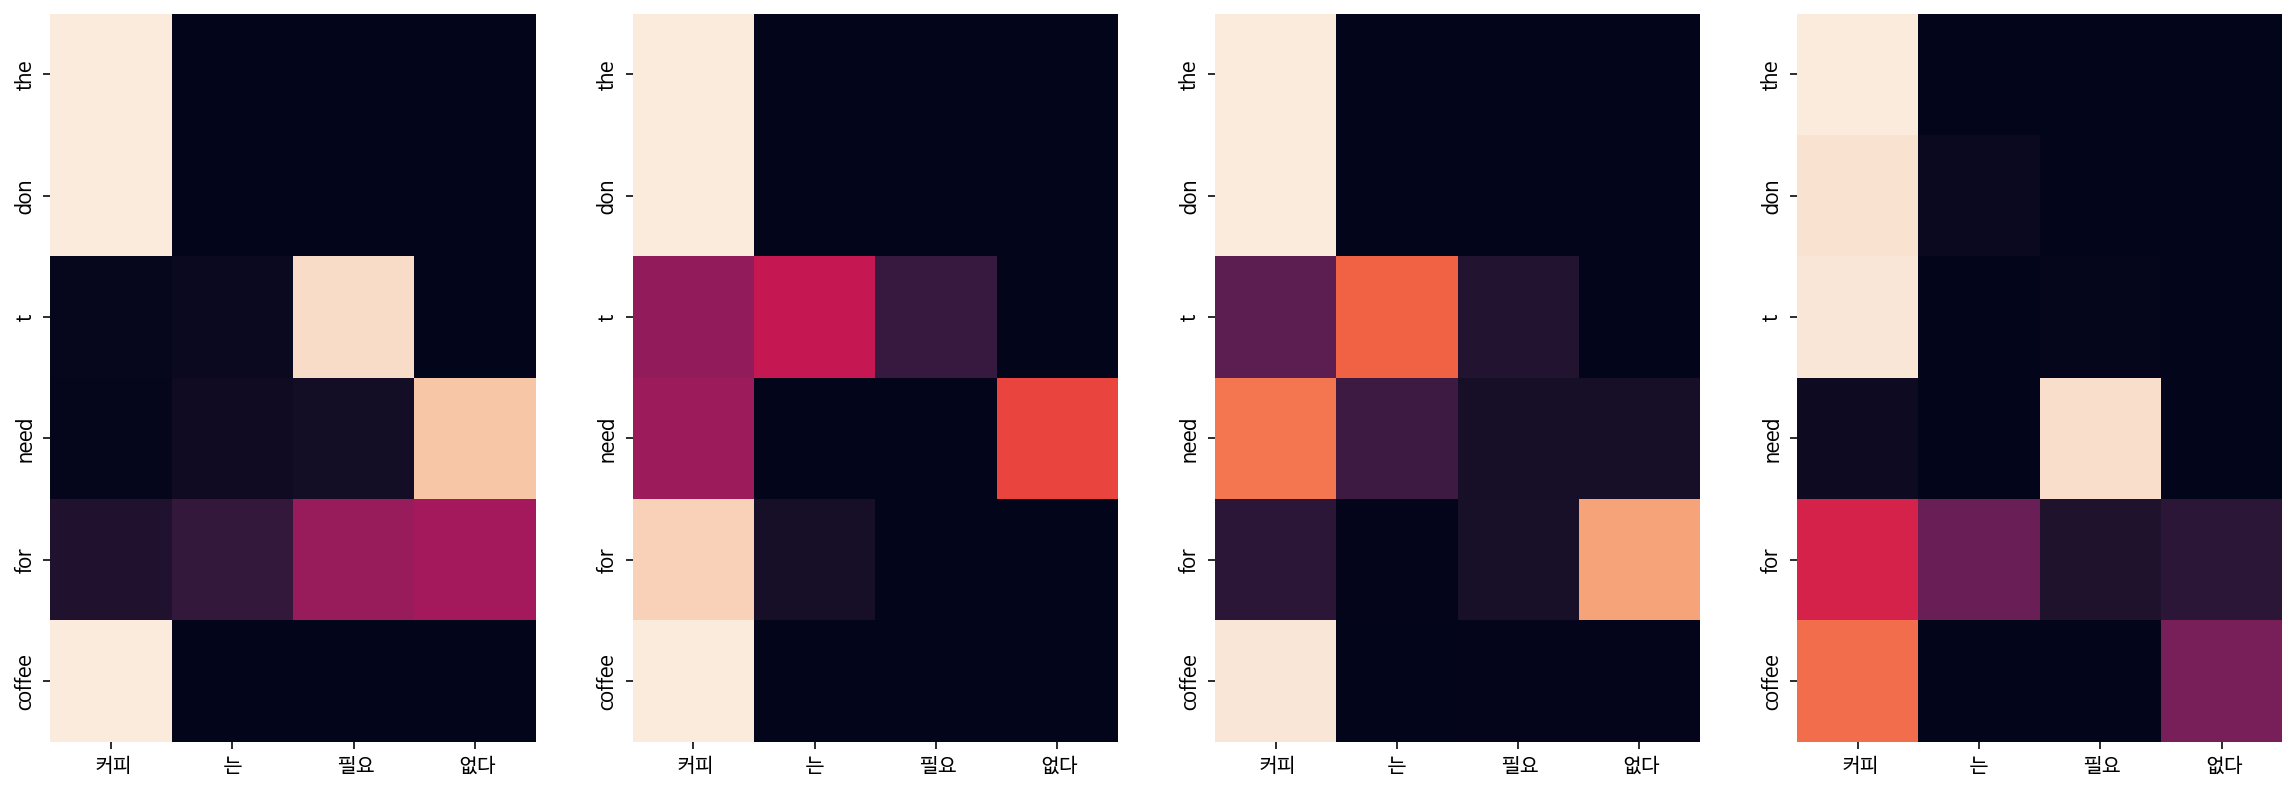

Decoder Self Layer 2


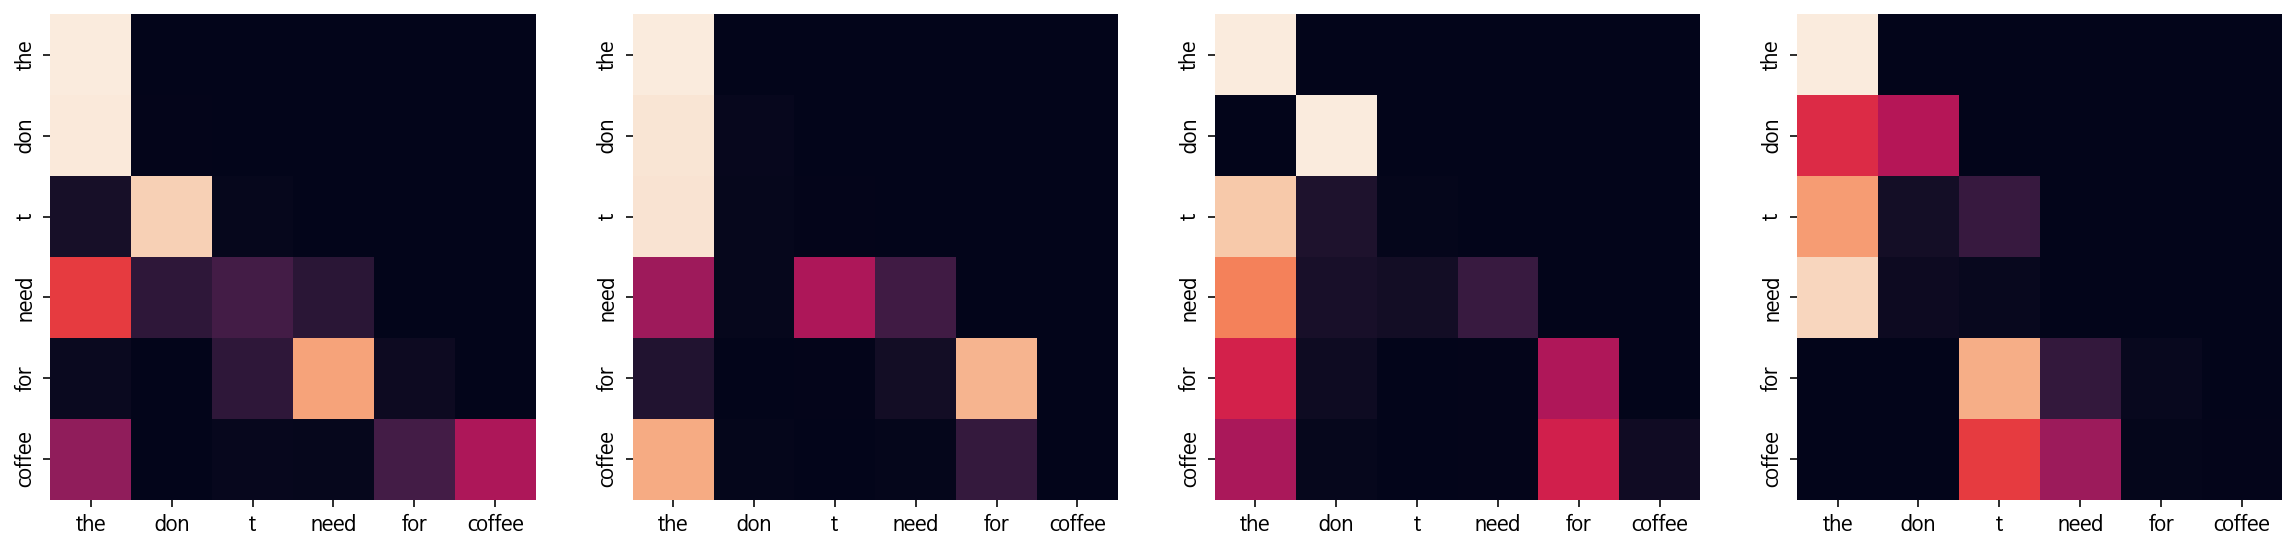

Decoder Src Layer 2


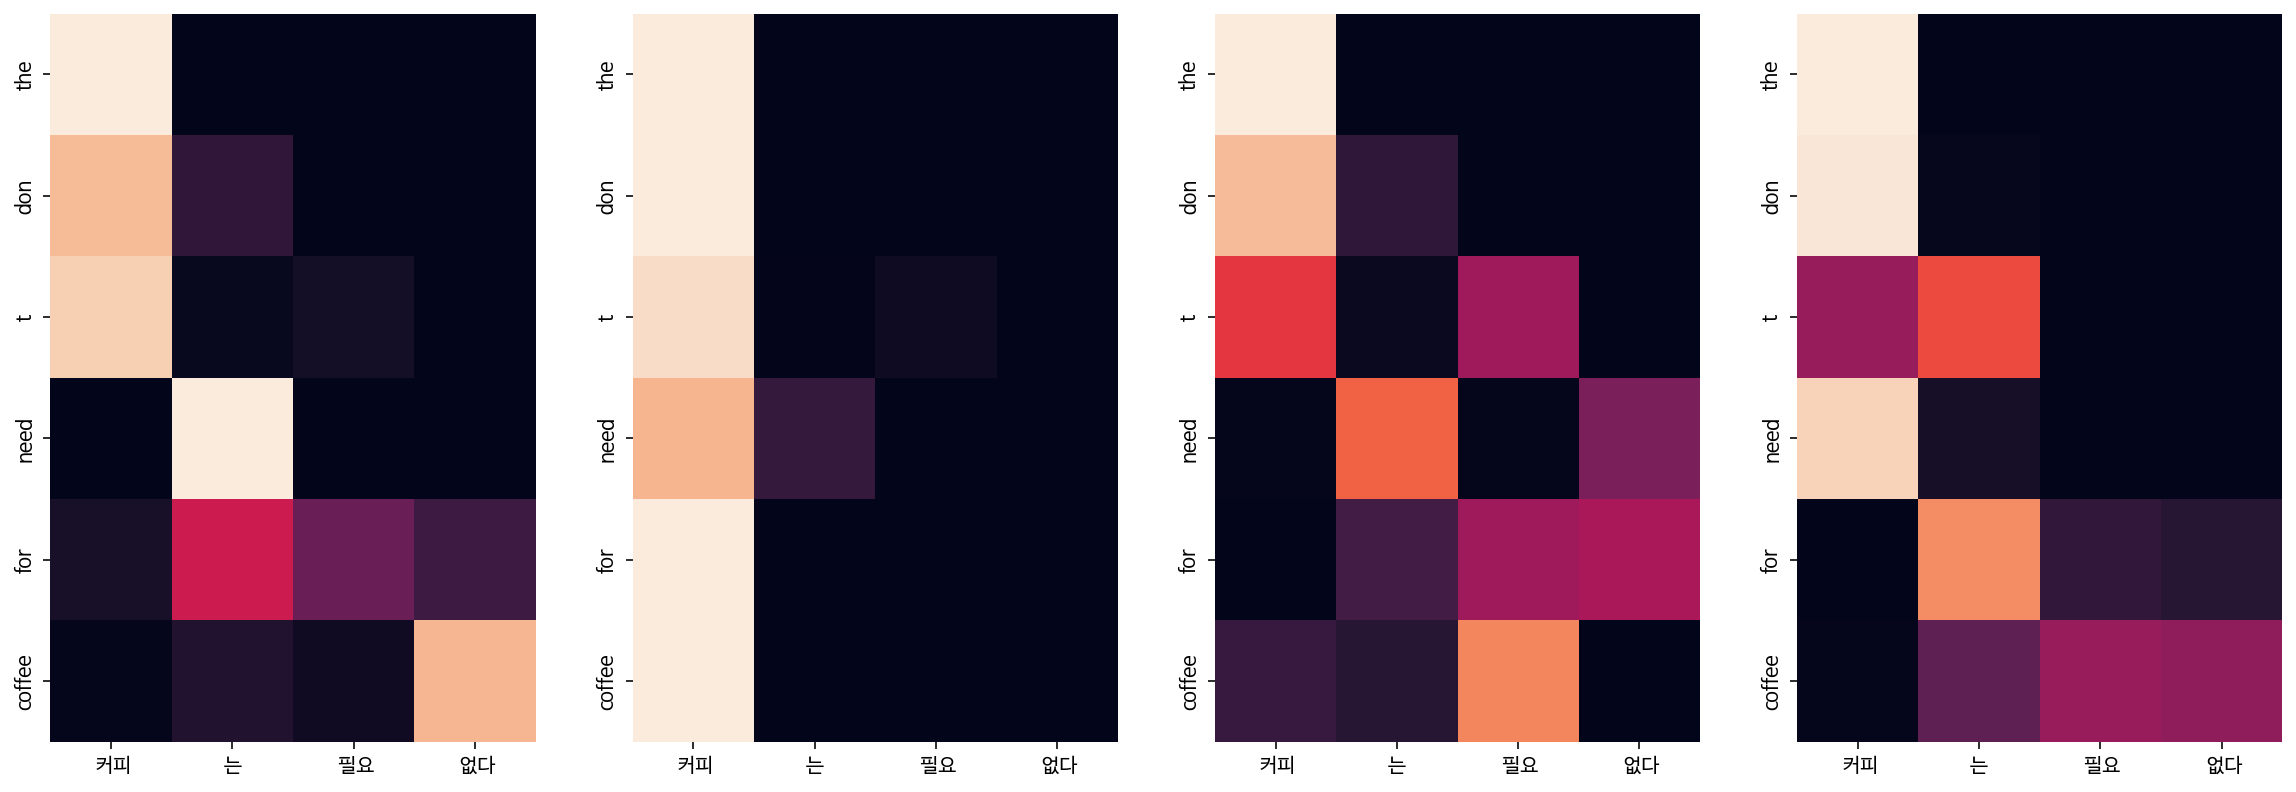

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven seven other people were reported missing
Encoder Layer 1


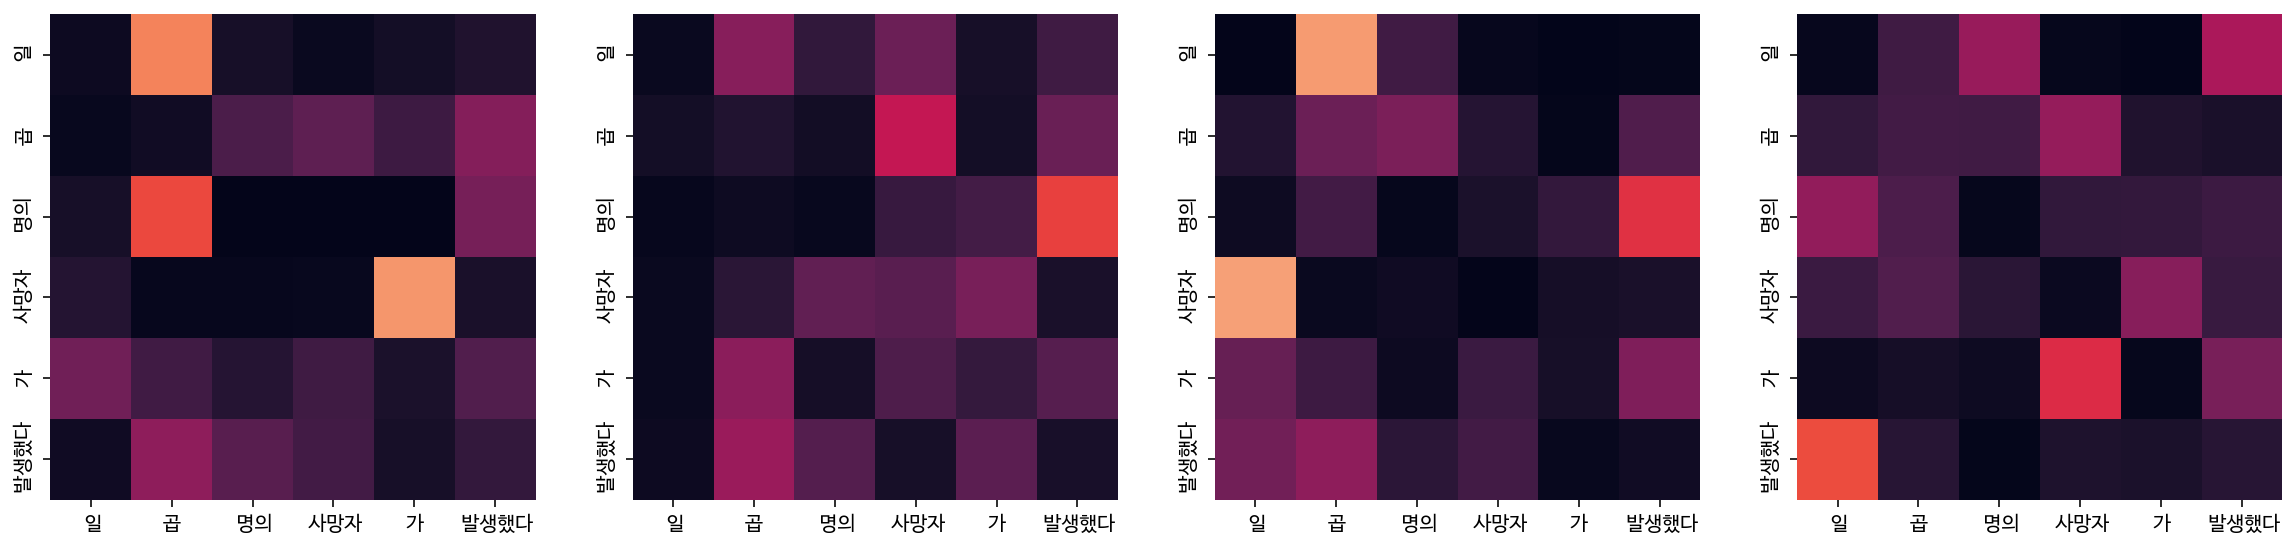

Encoder Layer 2


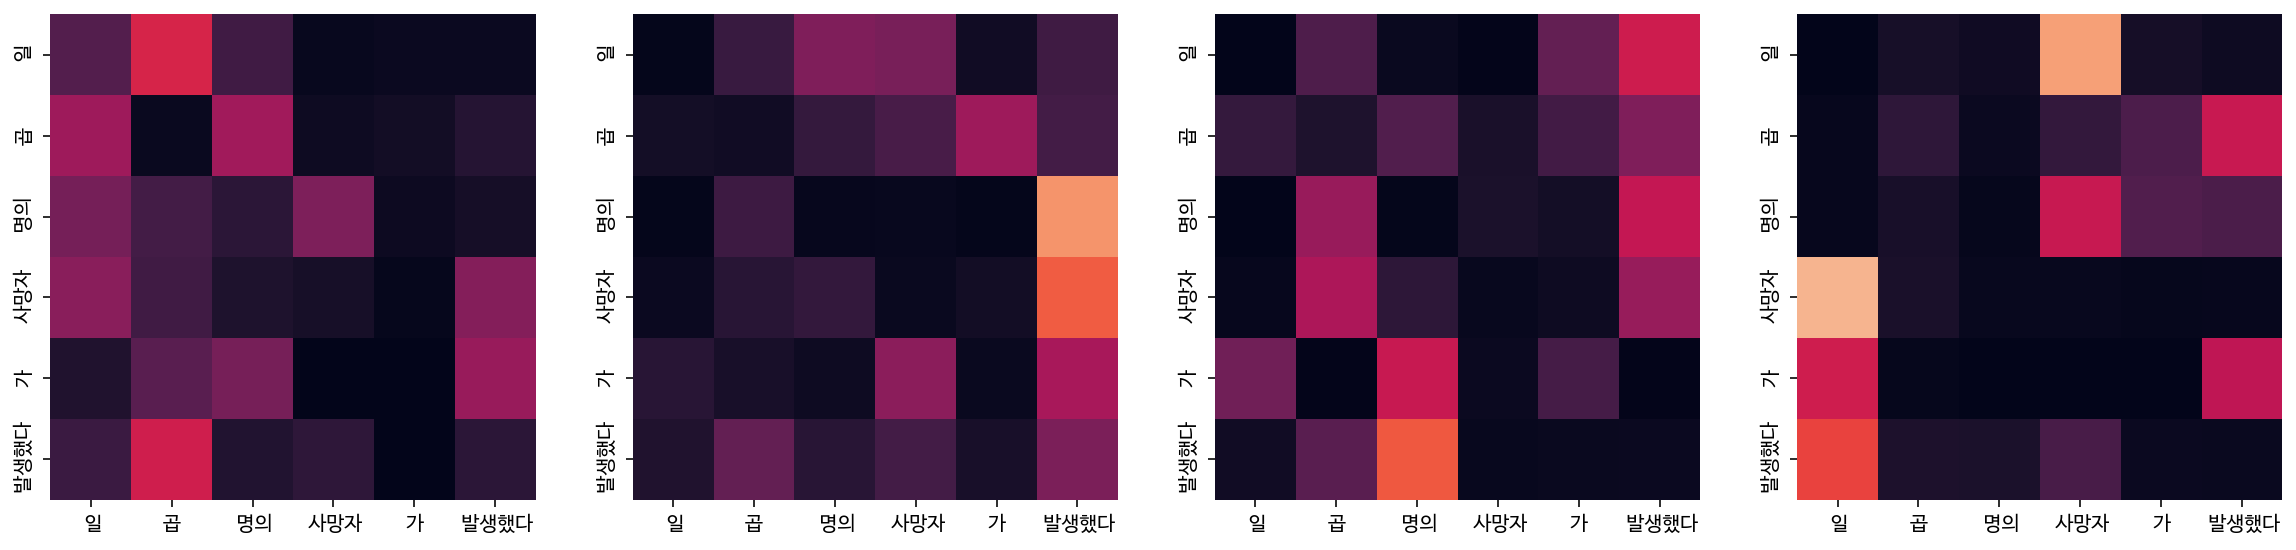

Decoder Self Layer 1


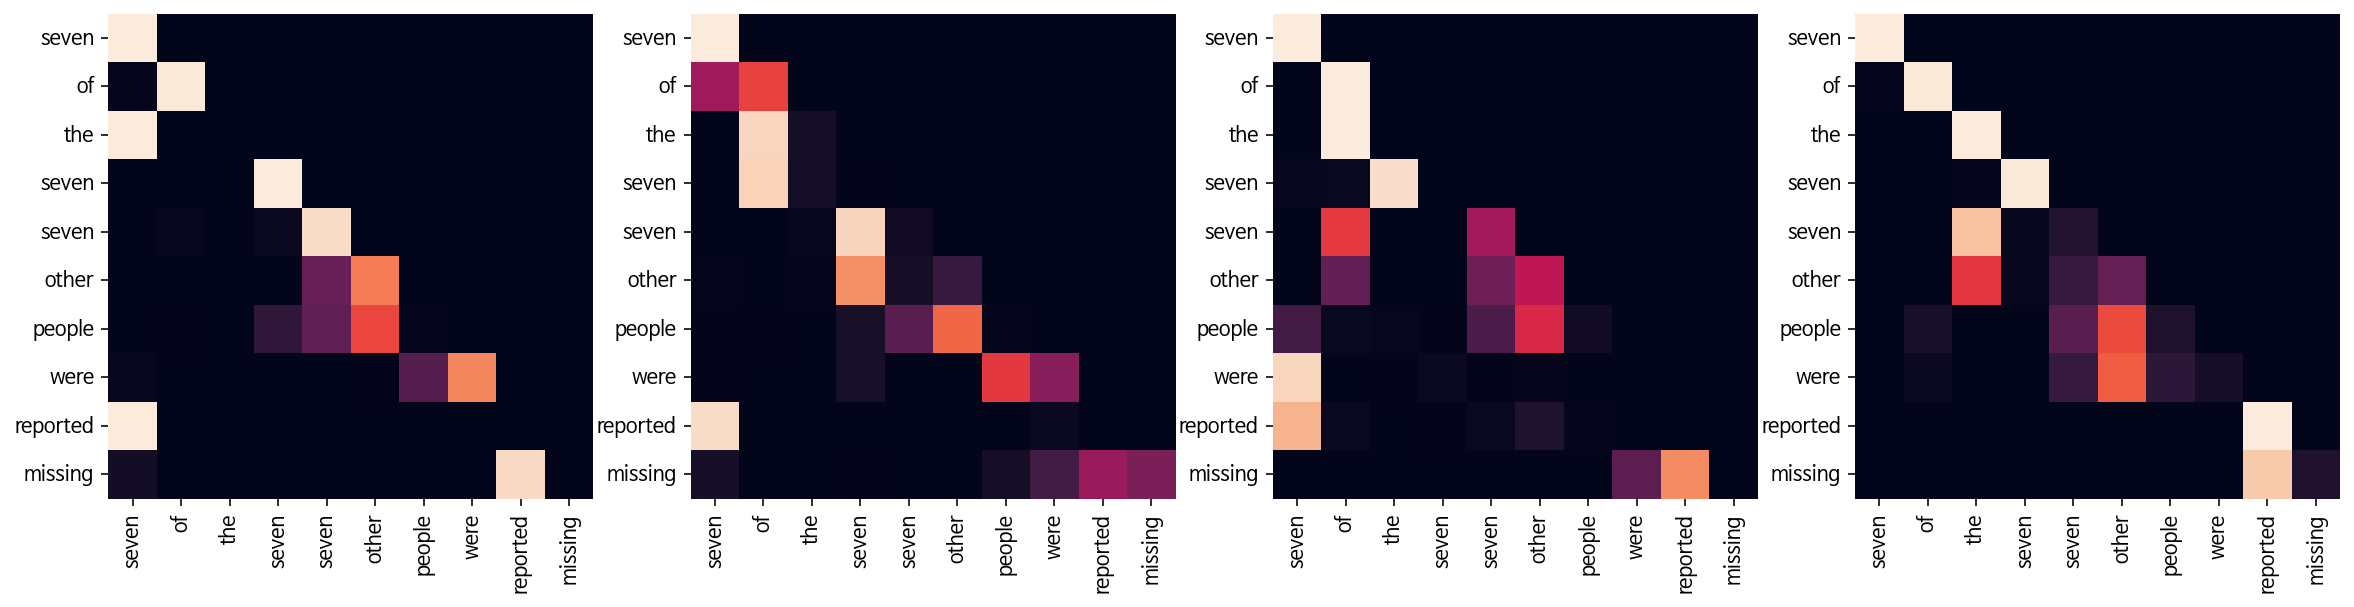

Decoder Src Layer 1


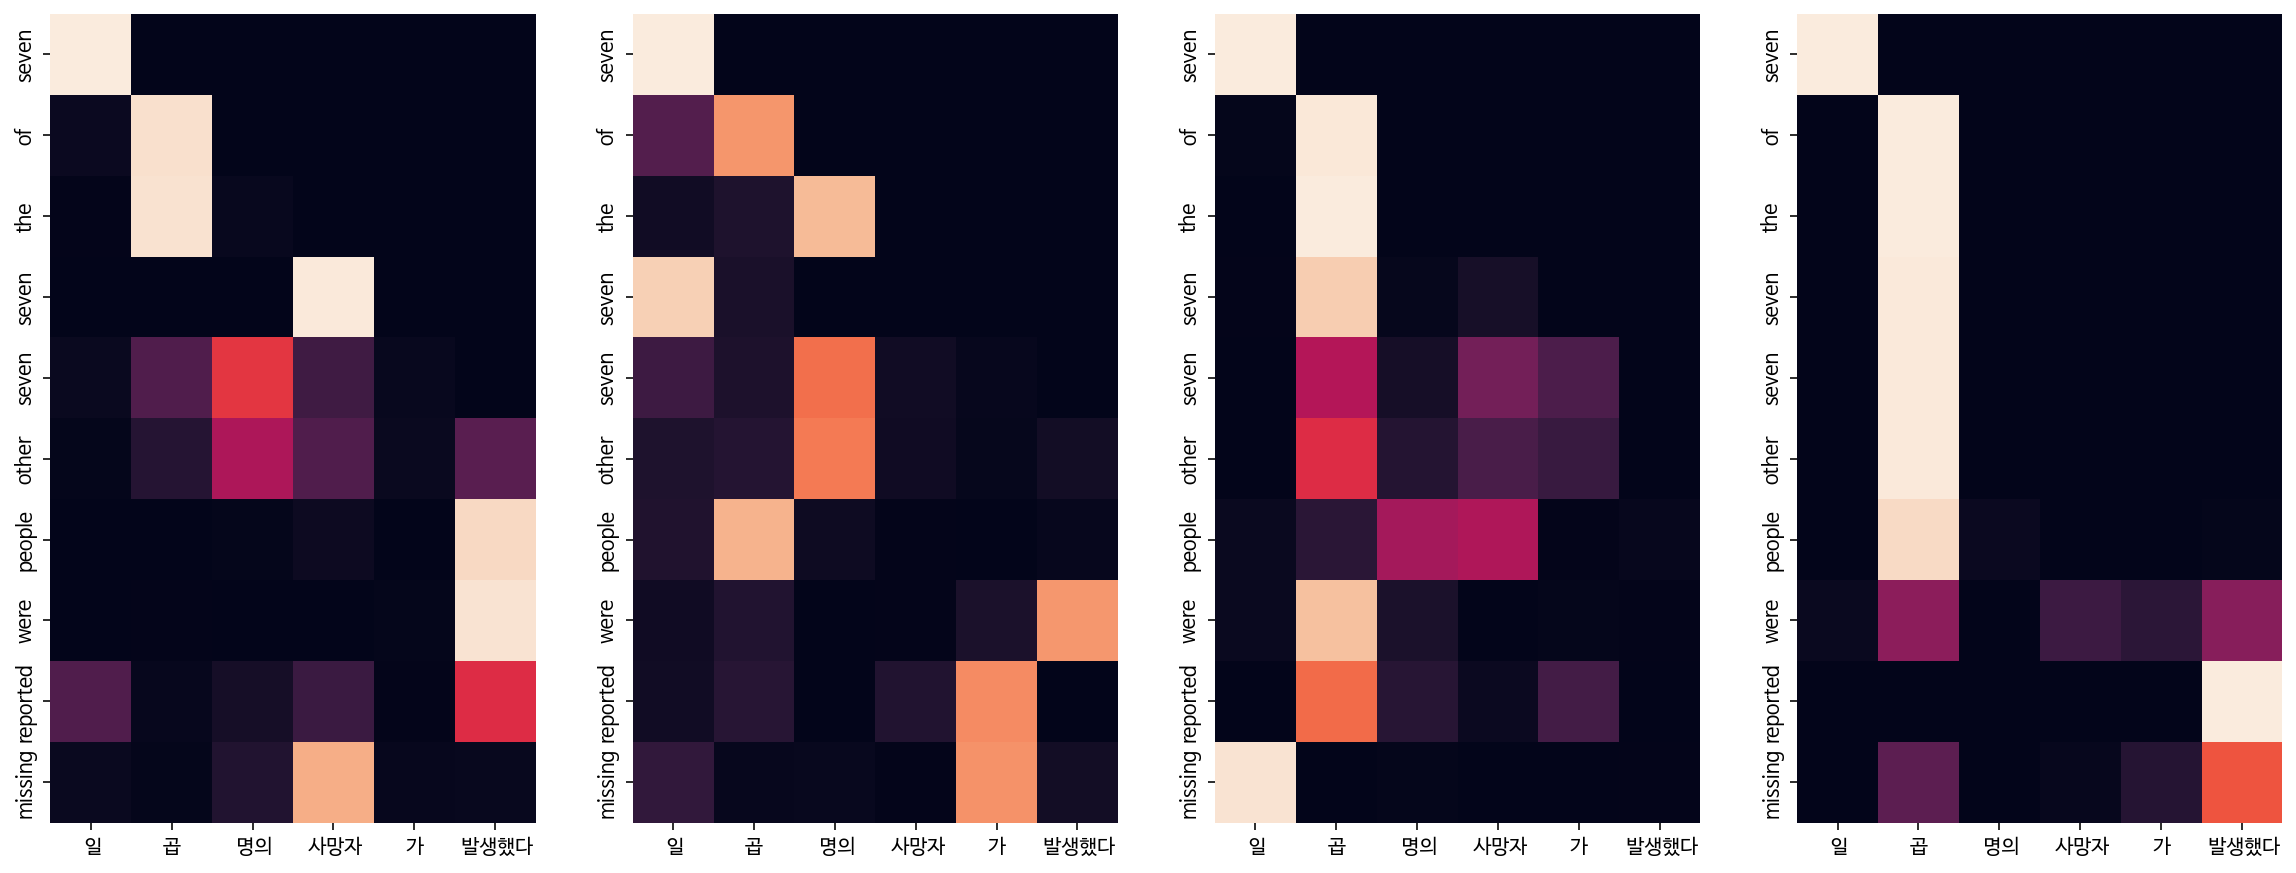

Decoder Self Layer 2


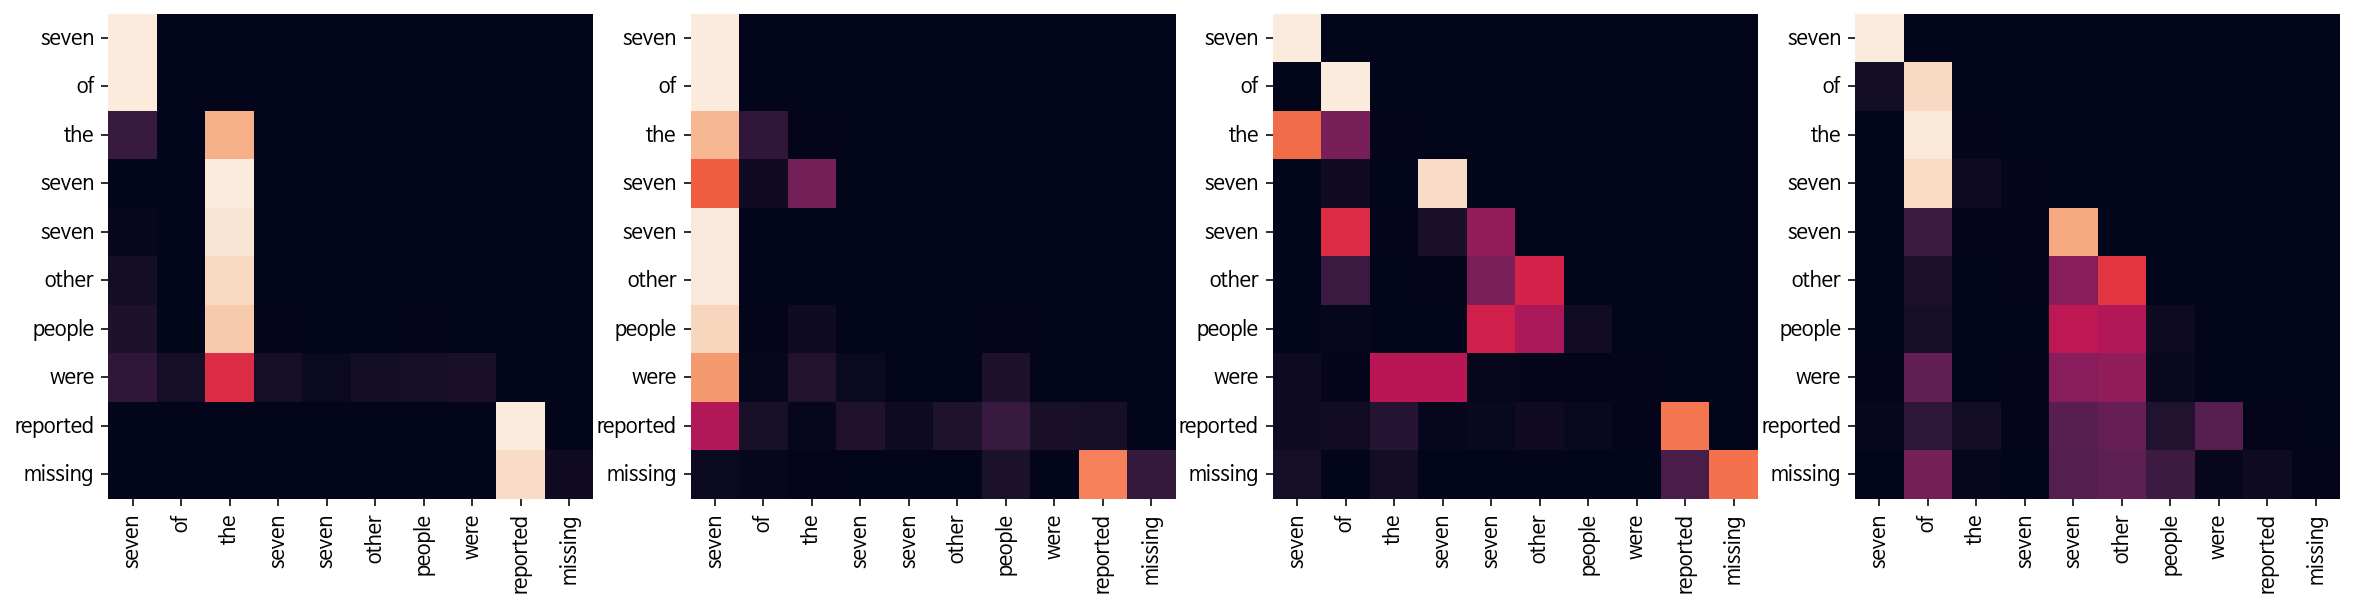

Decoder Src Layer 2


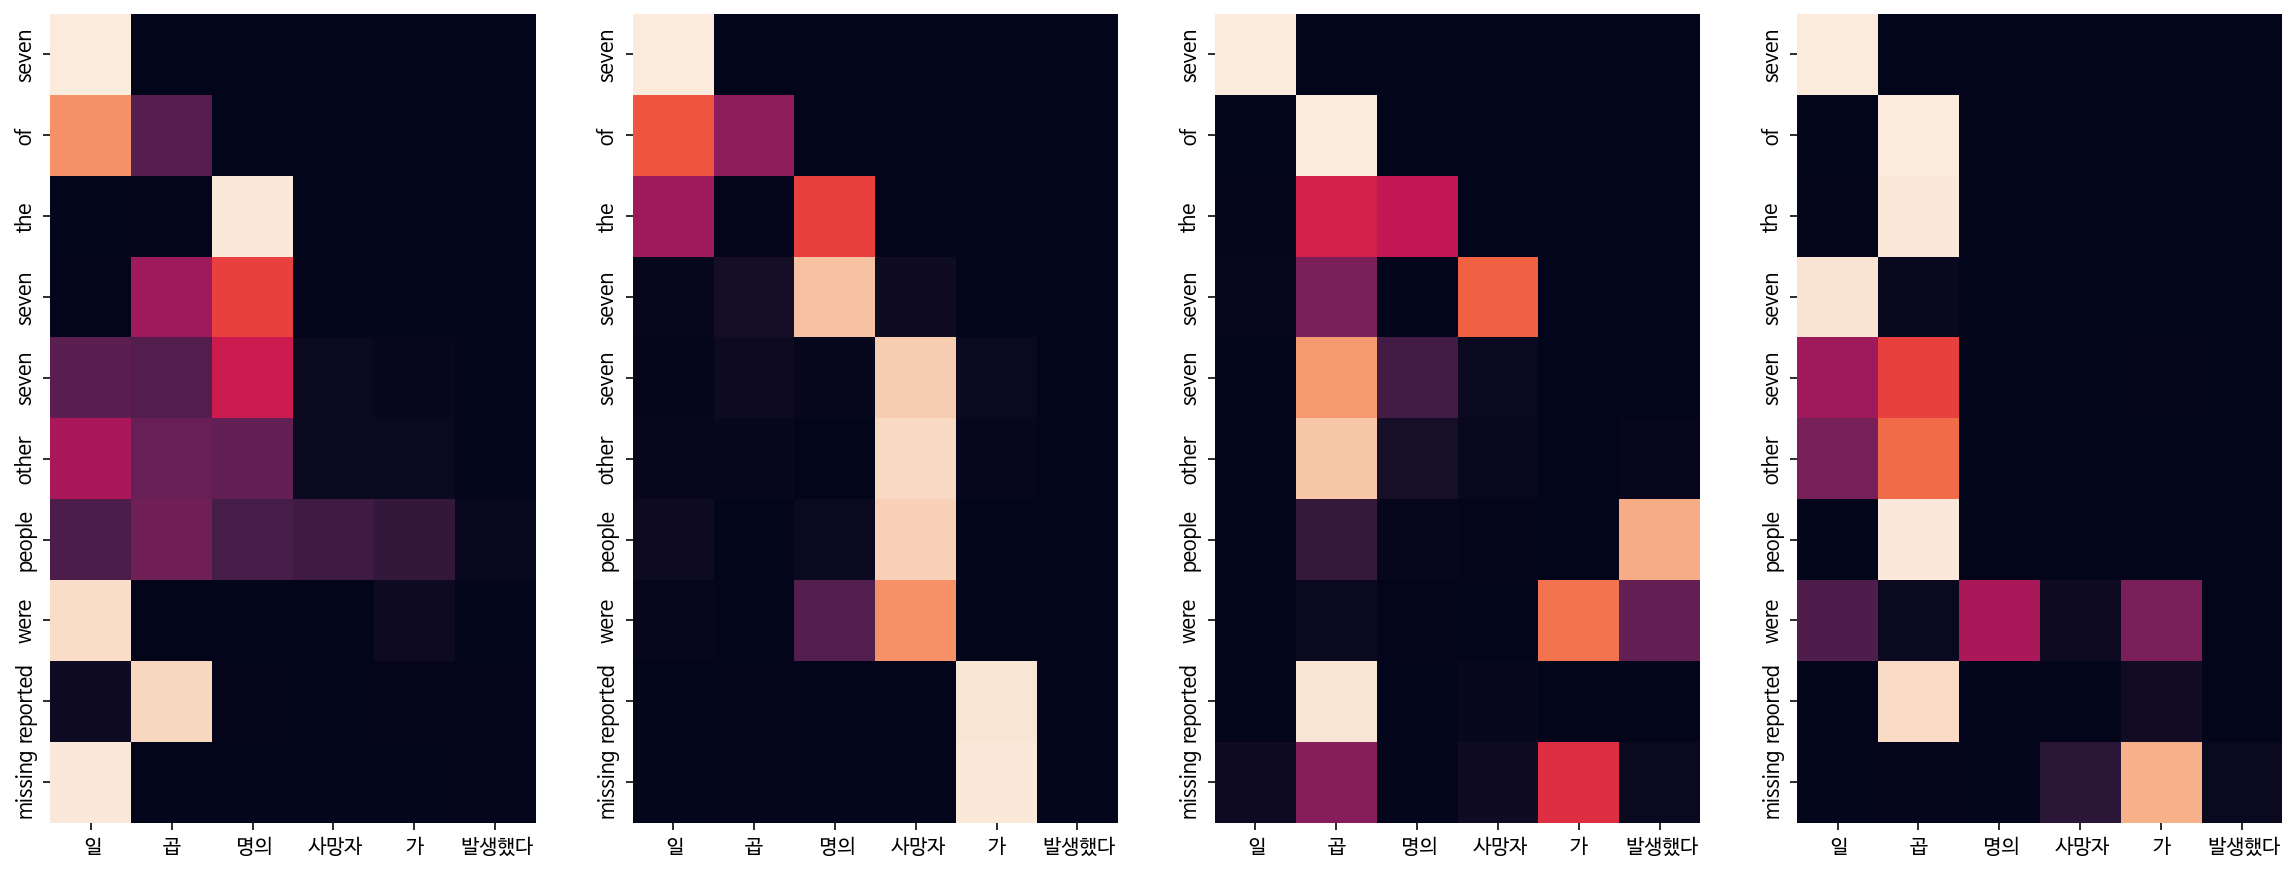

In [48]:
result = []
for example in examples:
    result.append(translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True))

In [57]:
losses_t02 = histories['t02']

In [128]:
loss_epoch = int(len(src_corpus) / BATCH_SIZE)

In [80]:
loss_t02_sample = []
for i in range(63, len(losses_t02), loss_epoch):
    loss_t02_sample.append(losses_t02[i])

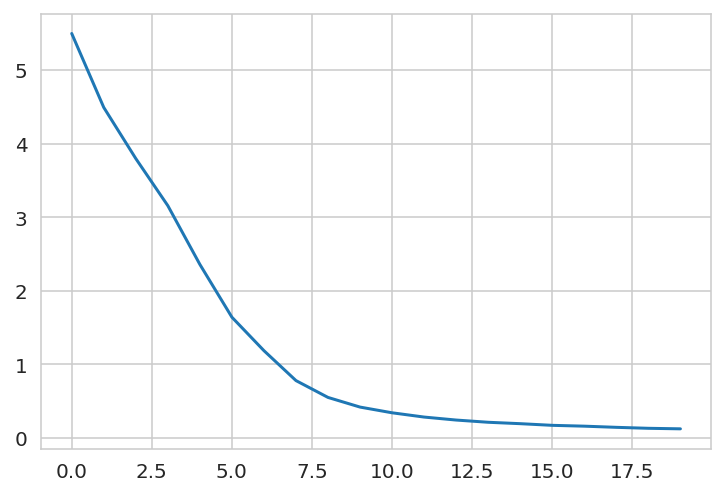

In [81]:
plt.plot(loss_t02_sample)

### 2: SentencePiece - BPE

In [104]:
losses, training_result = train_model(
    model=transformer, enc_train=enc_train, dec_train=dec_train, optimizer=optimizer, 
    epochs=EPOCHS, batch_size=BATCH_SIZE, translate_func=translate, examples=examples)

  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban urban
Input: 커피는 필요 없다.
Predicted translation: coffee are no coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven others were killed in the blast in the blast


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s most urban is the city
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: another were reported


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban areas
Input: 커피는 필요 없다.
Predicted translation: it doesn t take a place necessary
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are killed in the seven


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president
Input: 시민들은 도시 속에 산다.
Predicted translation: they re just a city in town about once in city town
Input: 커피는 필요 없다.
Predicted translation: without any further need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven people were killed in the seven seven of the seven seven seven seven of the seven seven seven other people were in the seven seven seven seven


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama said the president elect would make his vision for president
Input: 시민들은 도시 속에 산다.
Predicted translation: they re a small town
Input: 커피는 필요 없다.
Predicted translation: the need for example
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in the killing of the seven people


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama
Input: 시민들은 도시 속에 산다.
Predicted translation: they come to town in town
Input: 커피는 필요 없다.
Predicted translation: there need need a total of need a total request from the venue and need a total need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in addition to the attacks


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is from his presidency
Input: 시민들은 도시 속에 산다.
Predicted translation: they come in town
Input: 커피는 필요 없다.
Predicted translation: the need is a need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed in the death of a fourth death in the seven were in the killing


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is laid to stand
Input: 커피는 필요 없다.
Predicted translation: the women need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in the attacks


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going to be sworn in
Input: 시민들은 도시 속에 산다.
Predicted translation: they packed into a city
Input: 커피는 필요 없다.
Predicted translation: no one is needed
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in the center of the disaster


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going to be sworn in
Input: 시민들은 도시 속에 산다.
Predicted translation: they come in town
Input: 커피는 필요 없다.
Predicted translation: the airport need a small bus a escorted to the city
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been killed in the fatality in the fatality a global death water


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going for the obama alone
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the sanae word on town cities
Input: 커피는 필요 없다.
Predicted translation: the necessary needed to be presented needed
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in the attacks


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama in need obama
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of san ban on bar overnight
Input: 커피는 필요 없다.
Predicted translation: the necessary pakistan police need a minor records and a need ales
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in the killing one of the largest organization in addition to the pileups


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is his own
Input: 시민들은 도시 속에 산다.
Predicted translation: they come on pakistan
Input: 커피는 필요 없다.
Predicted translation: the train is needed at terence
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were on sunday


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama obama chief
Input: 시민들은 도시 속에 산다.
Predicted translation: the protests come from cities
Input: 커피는 필요 없다.
Predicted translation: there is no need foriness at a request from the truck
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were in the latest fatality


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the governor
Input: 시민들은 도시 속에 산다.
Predicted translation: the suicide car that has been bared in town
Input: 커피는 필요 없다.
Predicted translation: the card is a total needed
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president
Input: 시민들은 도시 속에 산다.
Predicted translation: they come in town
Input: 커피는 필요 없다.
Predicted translation: there is no need for the torch
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in sunday s fight


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going to make room for president
Input: 시민들은 도시 속에 산다.
Predicted translation: they come in town
Input: 커피는 필요 없다.
Predicted translation: there is no need for nothing
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama leader of the obama jobs
Input: 시민들은 도시 속에 산다.
Predicted translation: they come word edict thaksin
Input: 커피는 필요 없다.
Predicted translation: the city is a needed need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven major assistance were in sunday attacks


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is reportedly your third term
Input: 시민들은 도시 속에 산다.
Predicted translation: they come in in cities
Input: 커피는 필요 없다.
Predicted translation: there need the conference
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed


  0%|          | 0/1132 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is going
Input: 시민들은 도시 속에 산다.
Predicted translation: they are barite place in cities
Input: 커피는 필요 없다.
Predicted translation: there need is need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed


Input: 오바마는 대통령이다.
Predicted translation: obama is going
Encoder Layer 1


/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


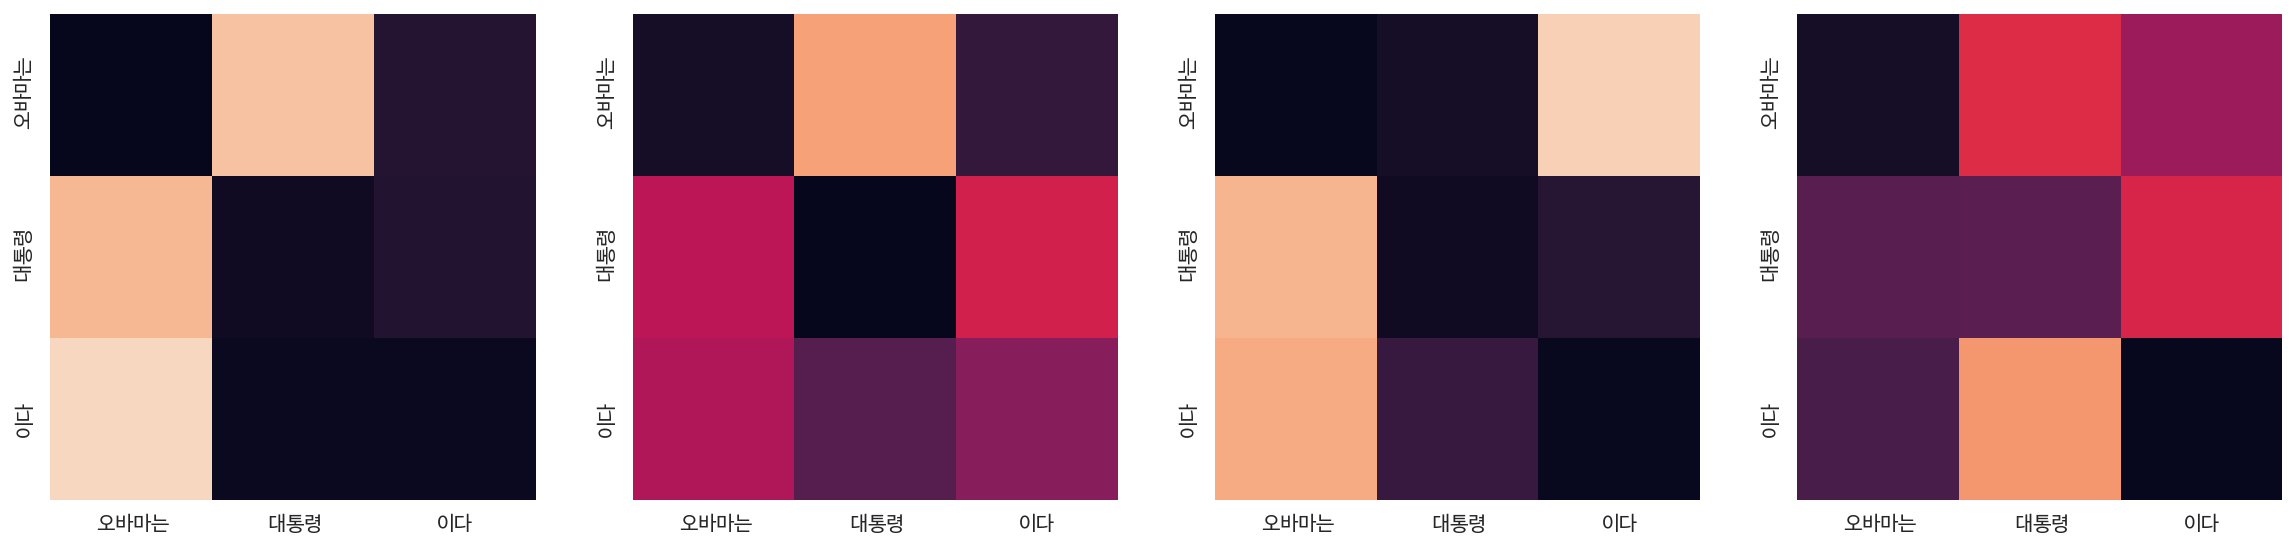

Encoder Layer 2


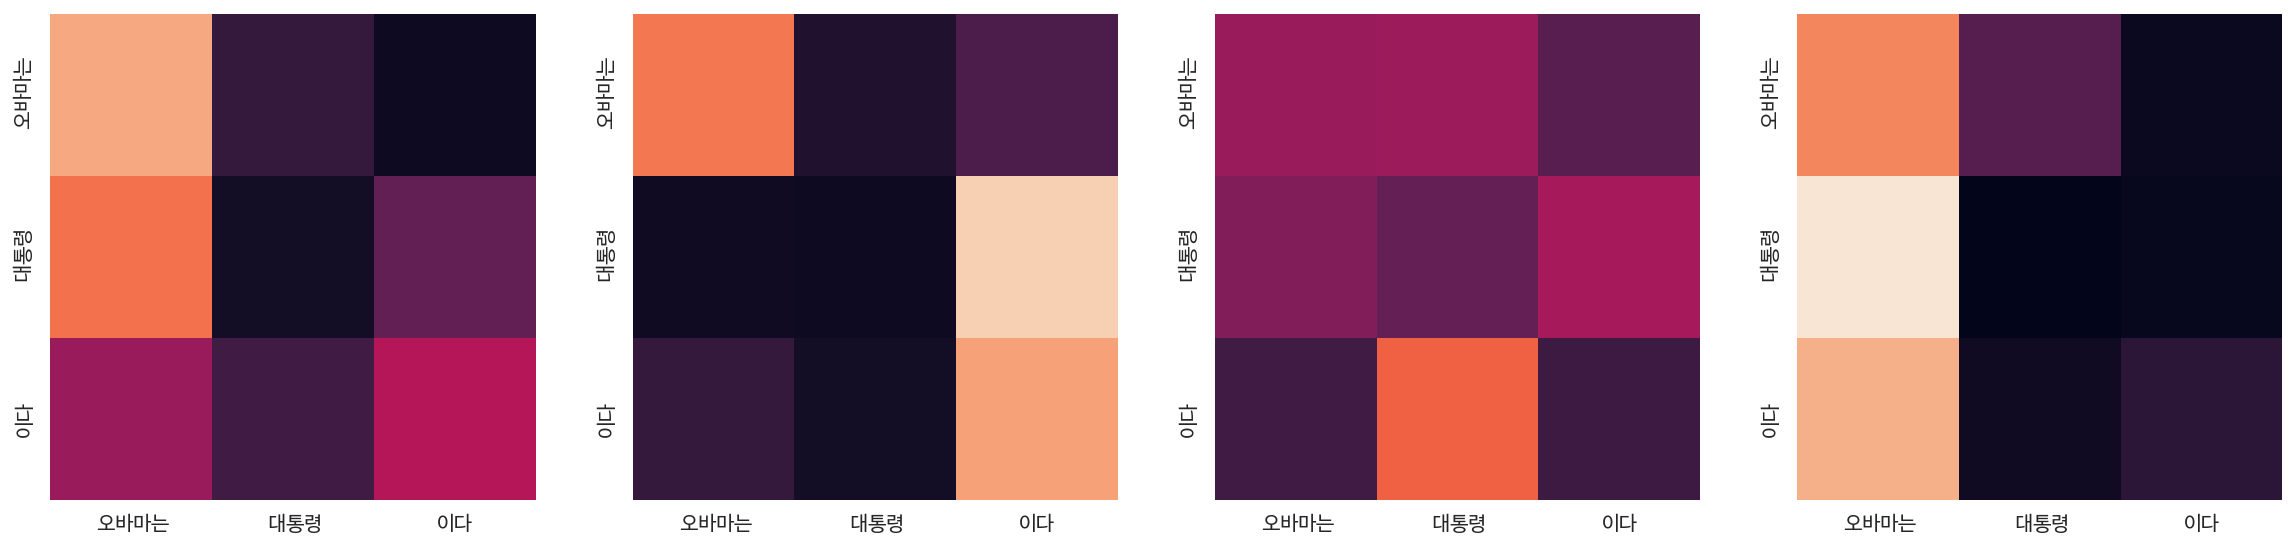

Decoder Self Layer 1


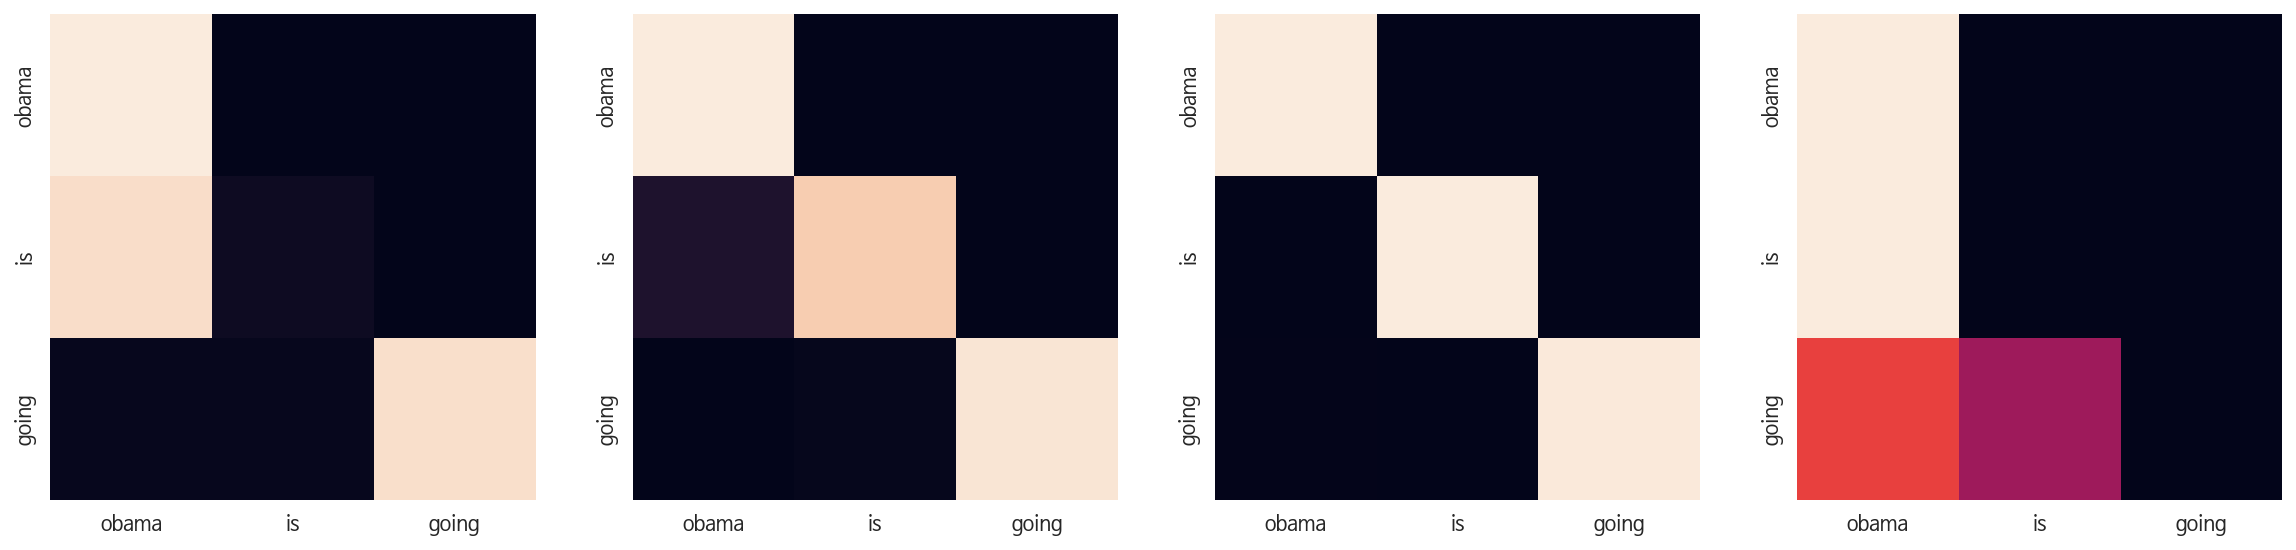

Decoder Src Layer 1


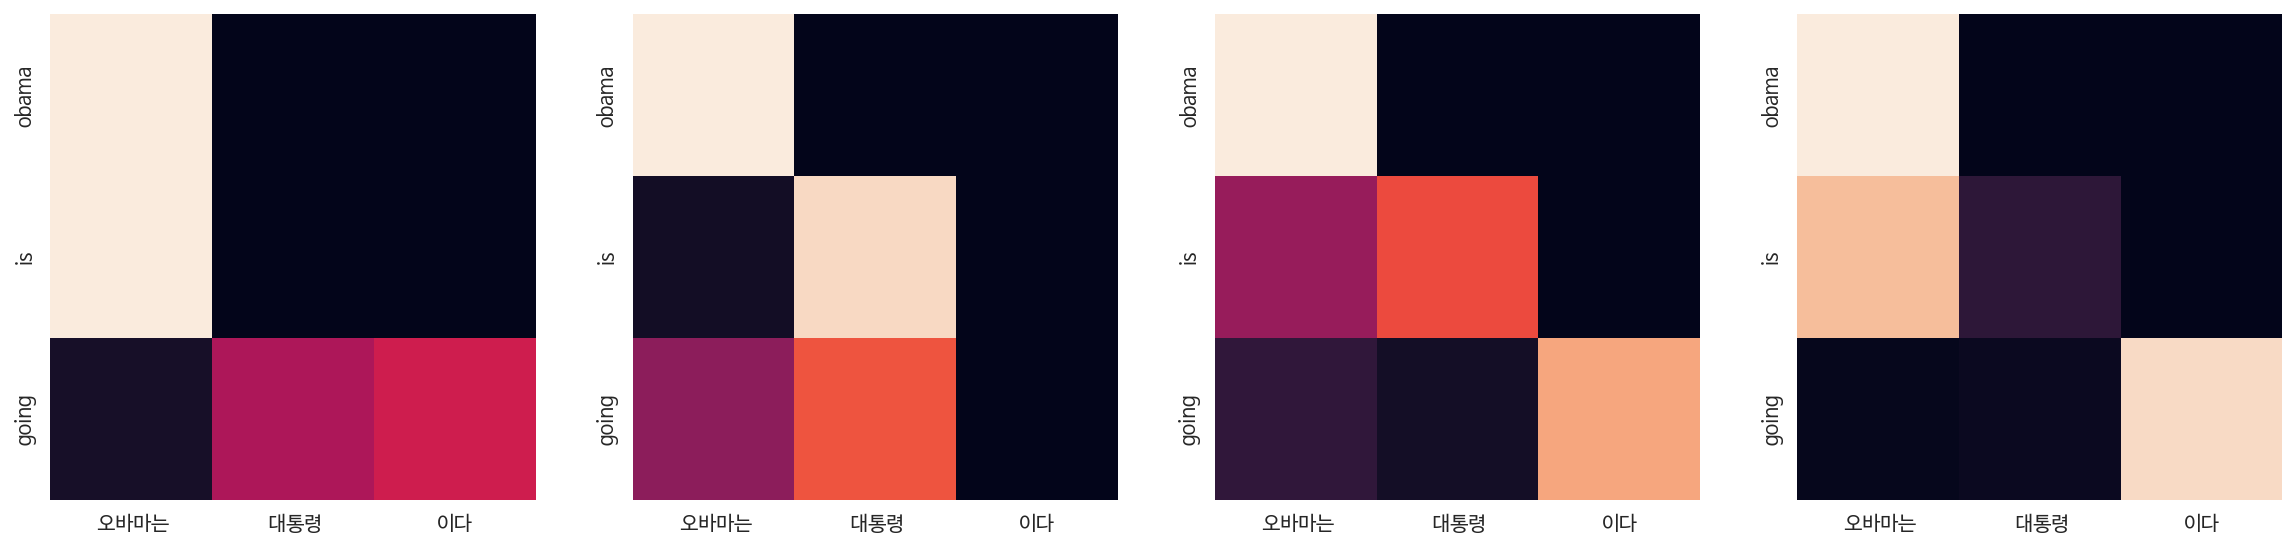

Decoder Self Layer 2


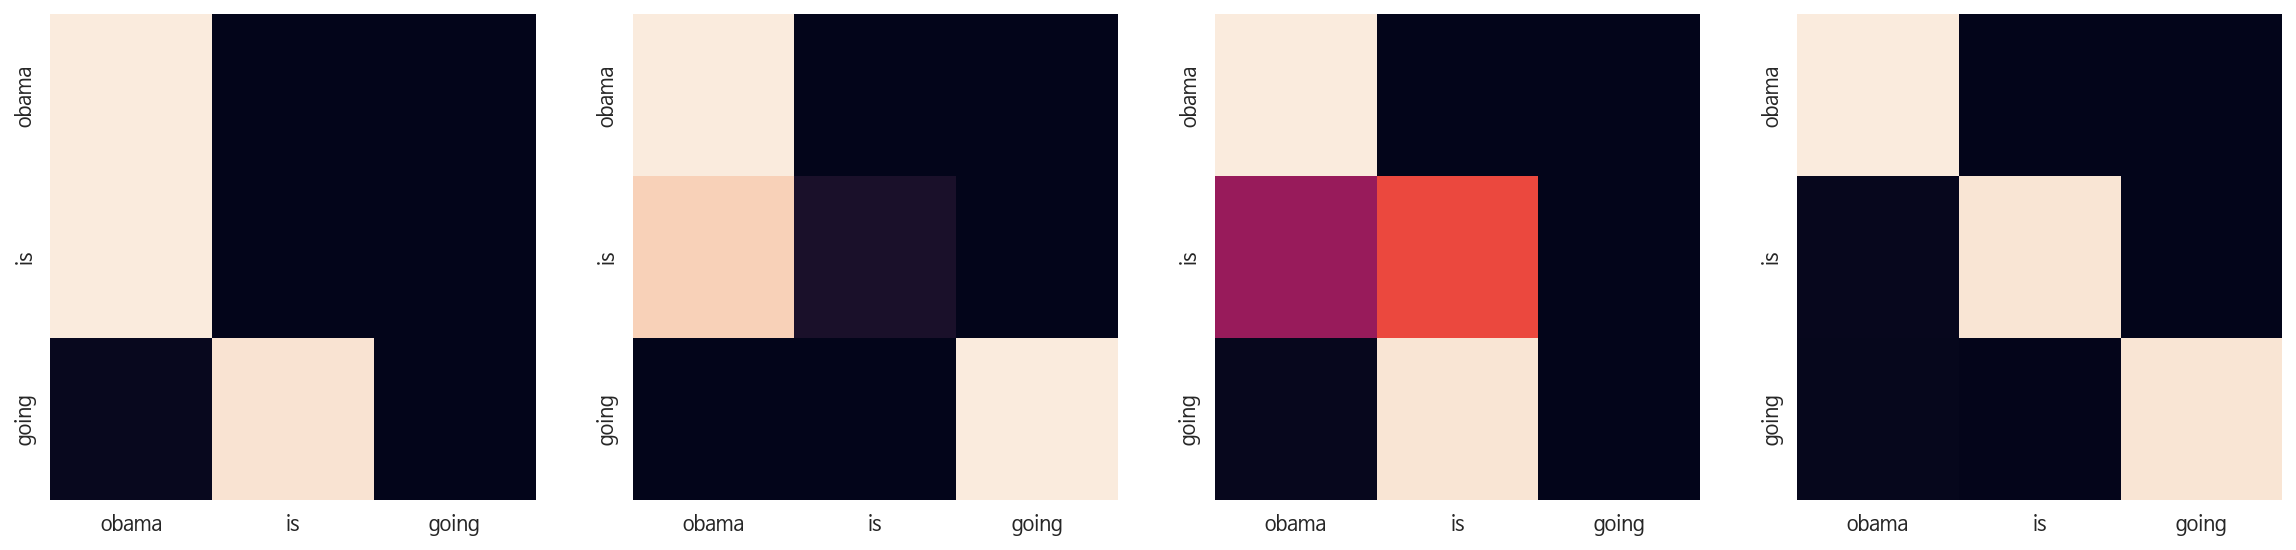

Decoder Src Layer 2


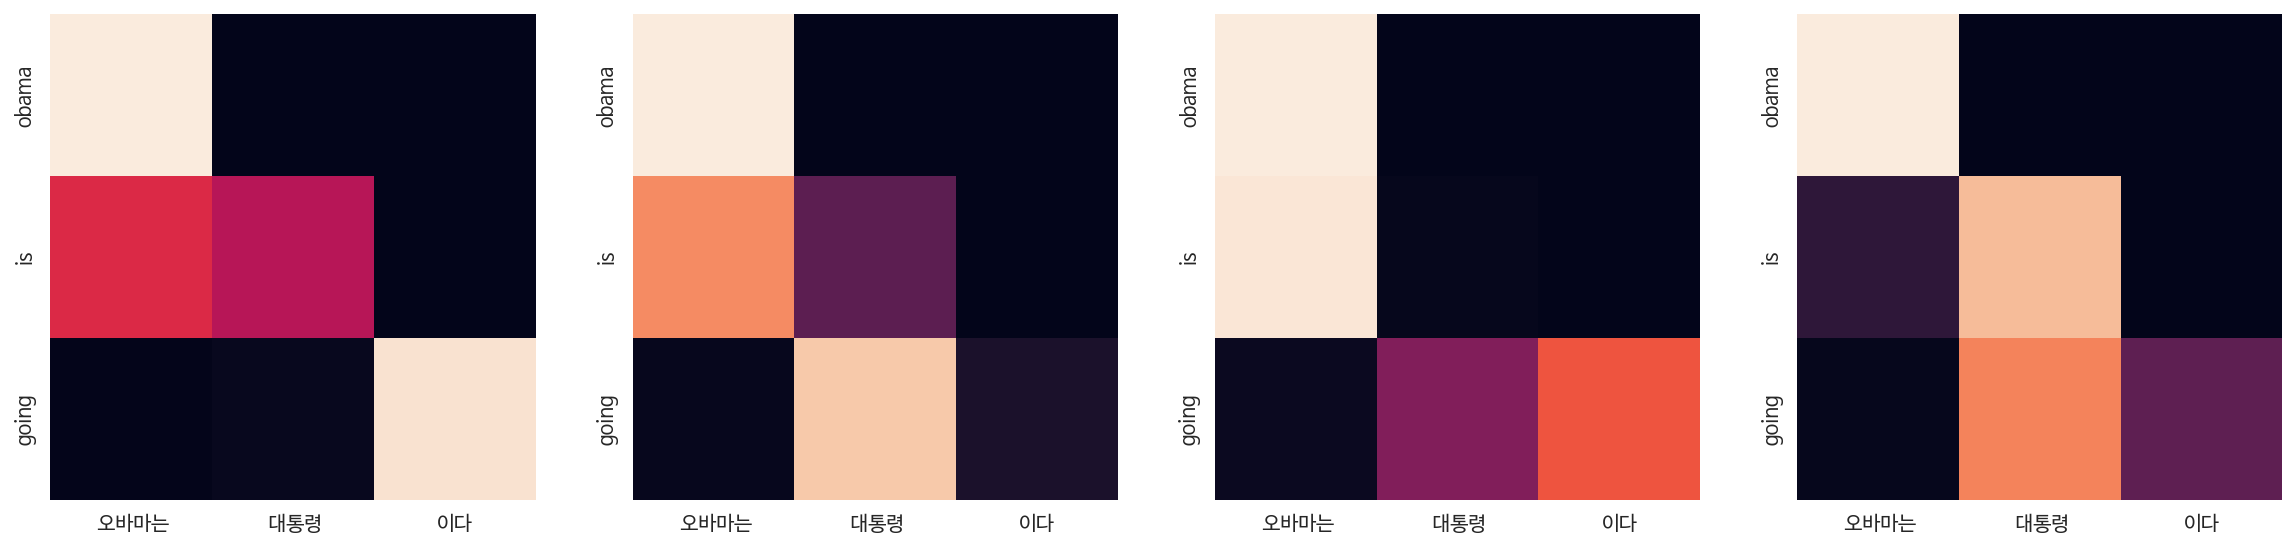

Input: 시민들은 도시 속에 산다.
Predicted translation: they are barite place in cities
Encoder Layer 1


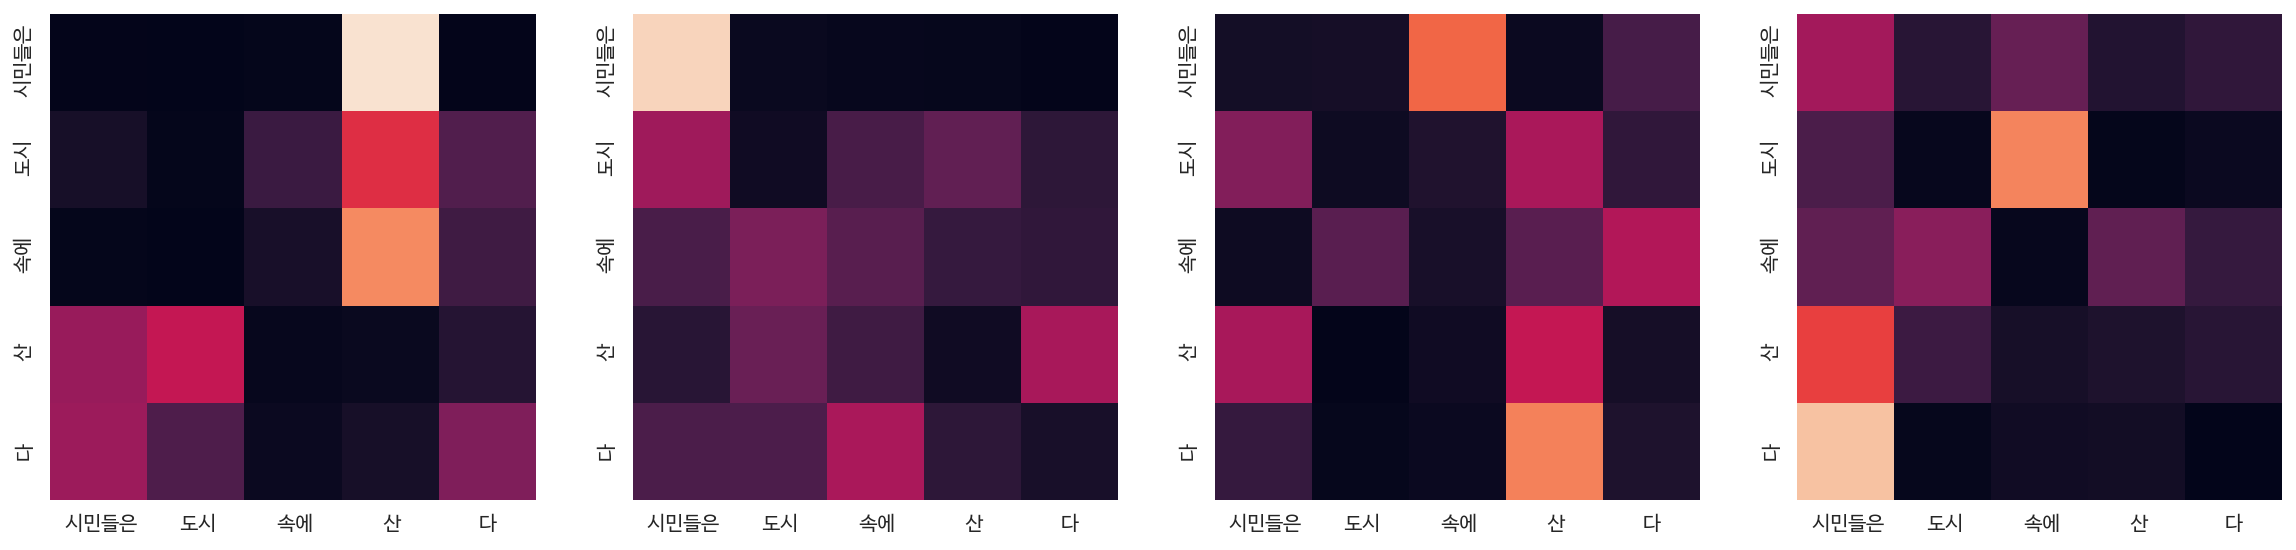

Encoder Layer 2


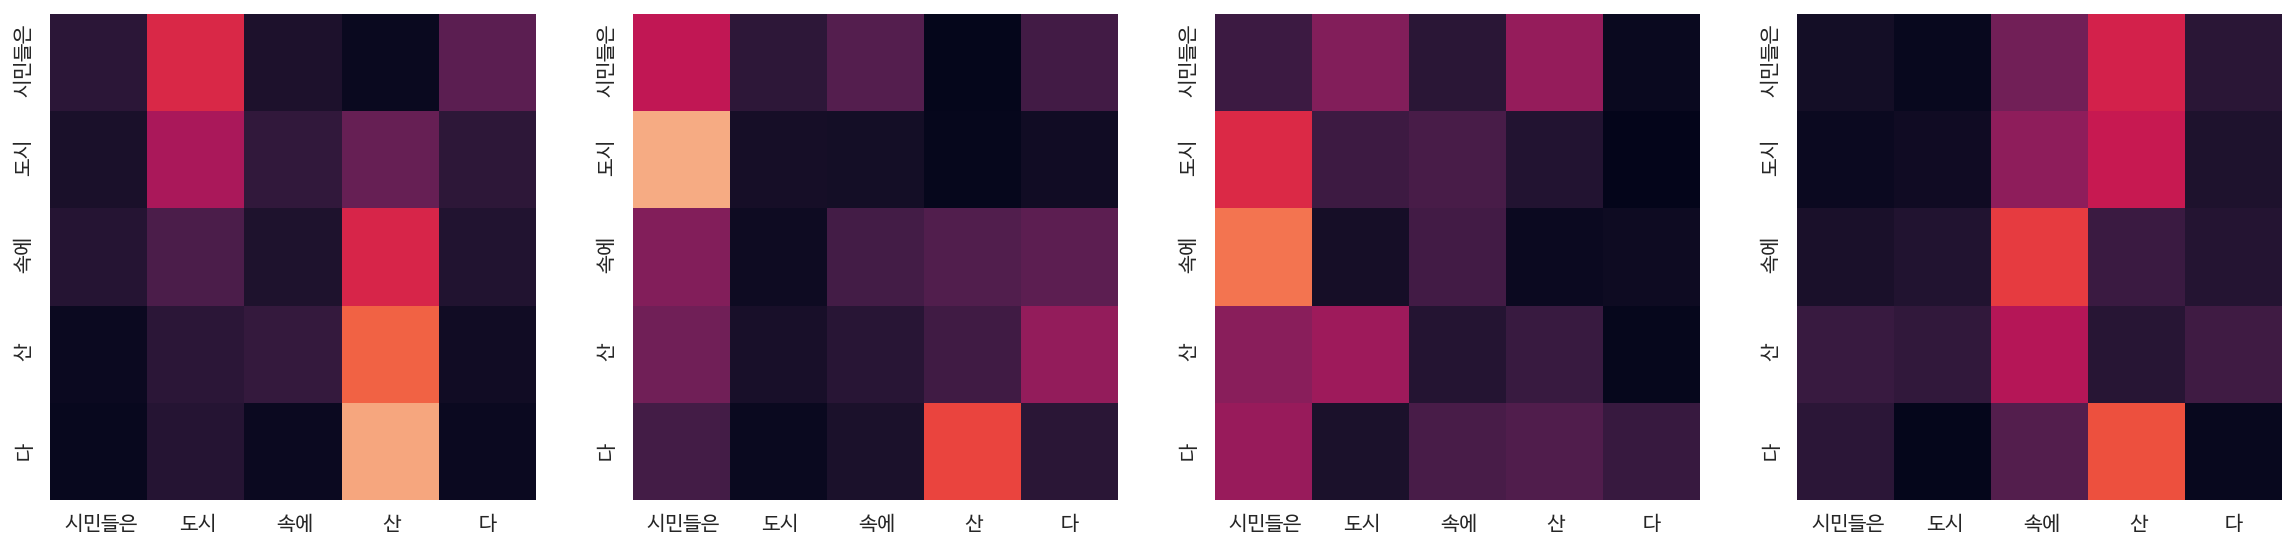

Decoder Self Layer 1


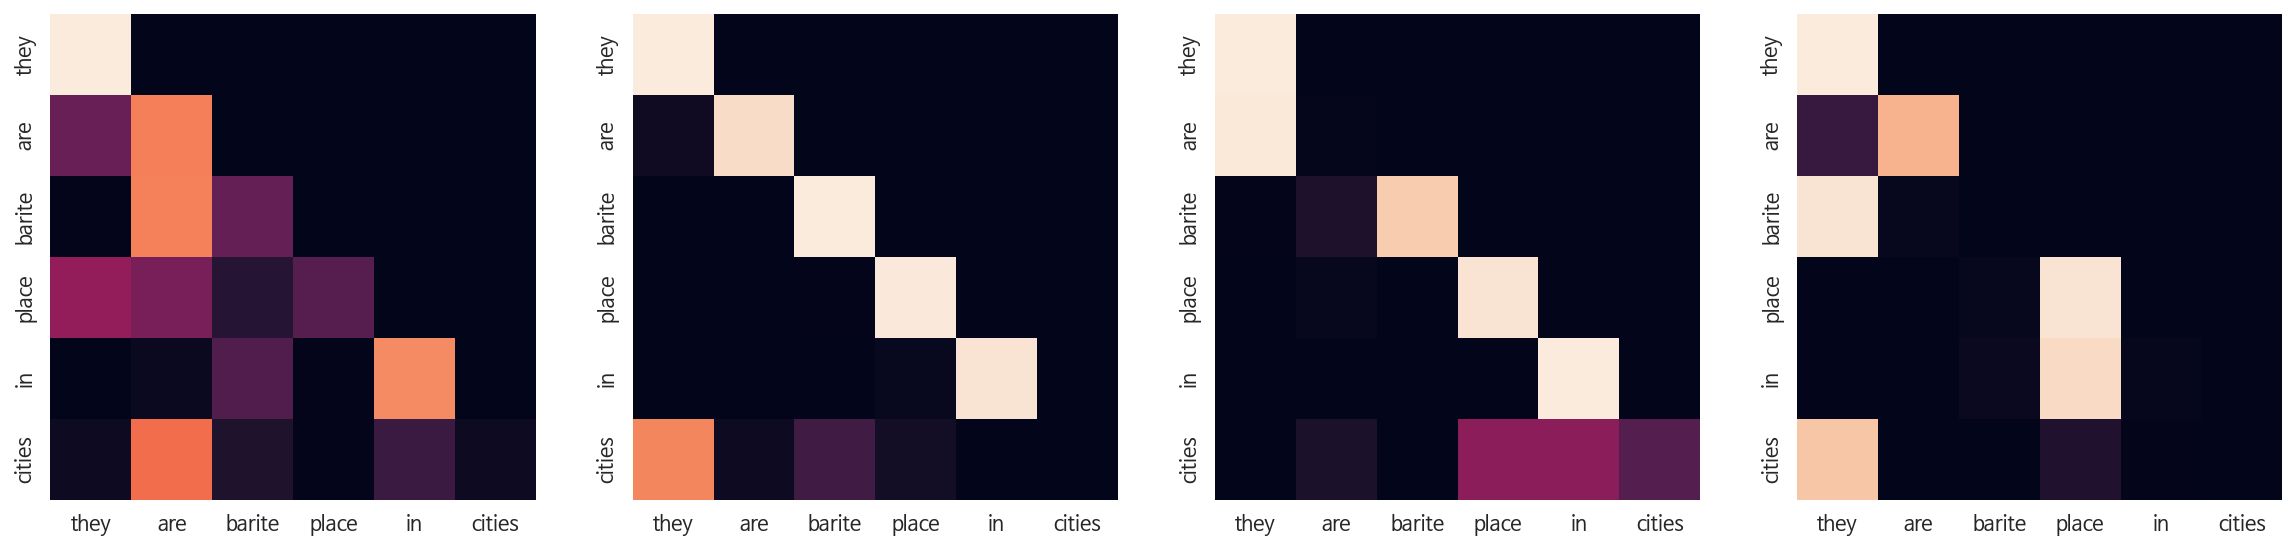

Decoder Src Layer 1


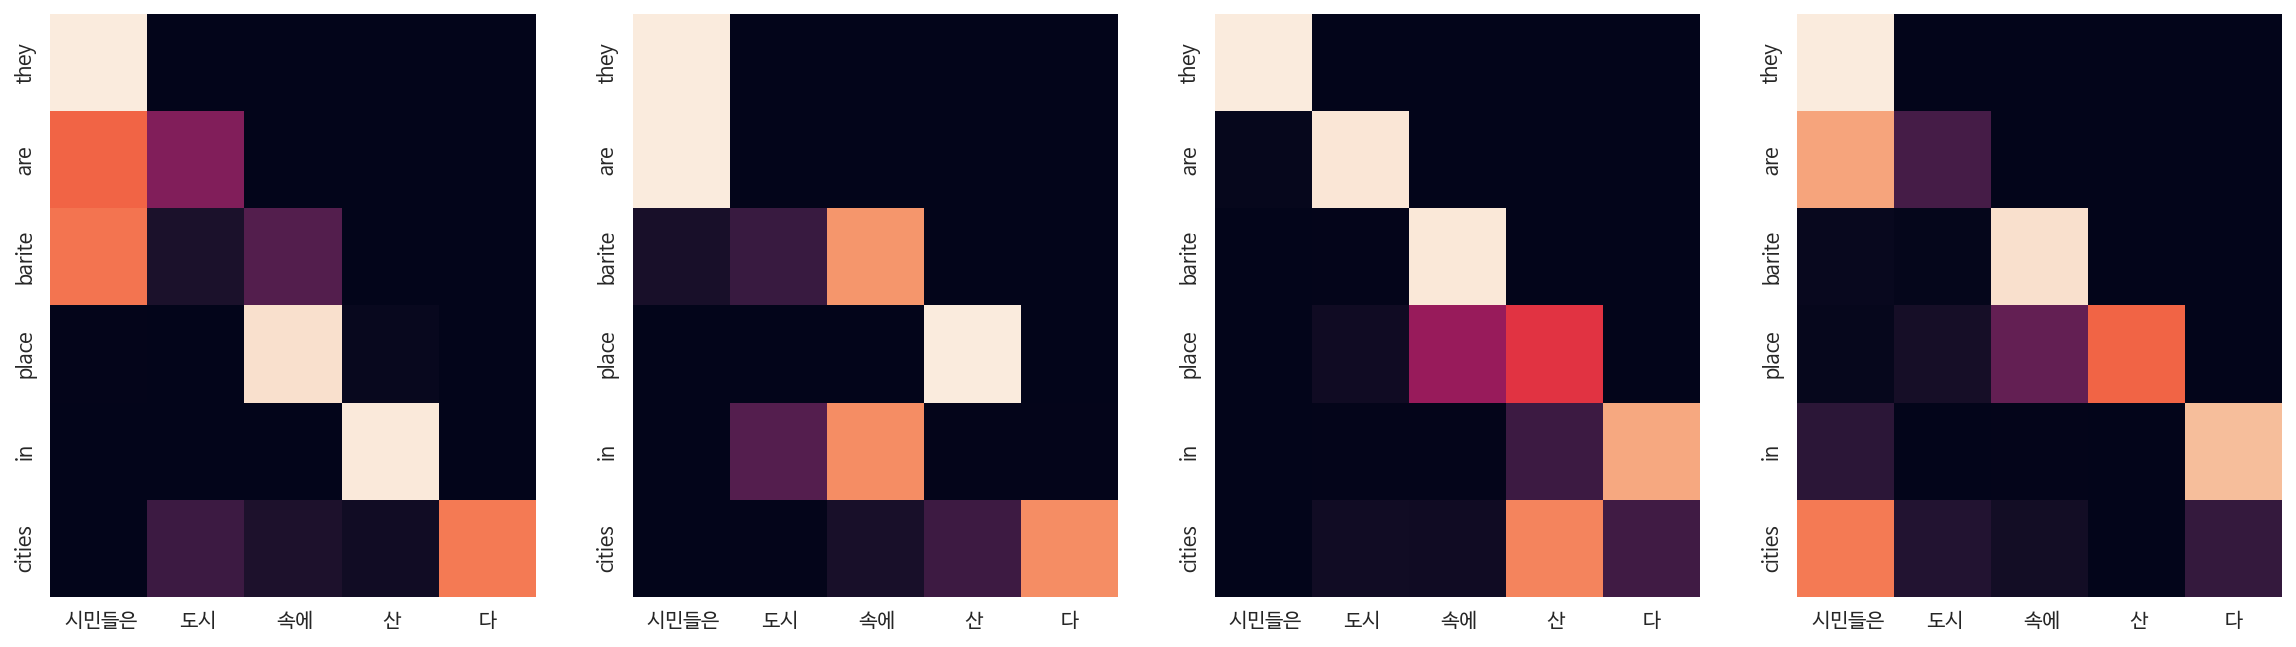

Decoder Self Layer 2


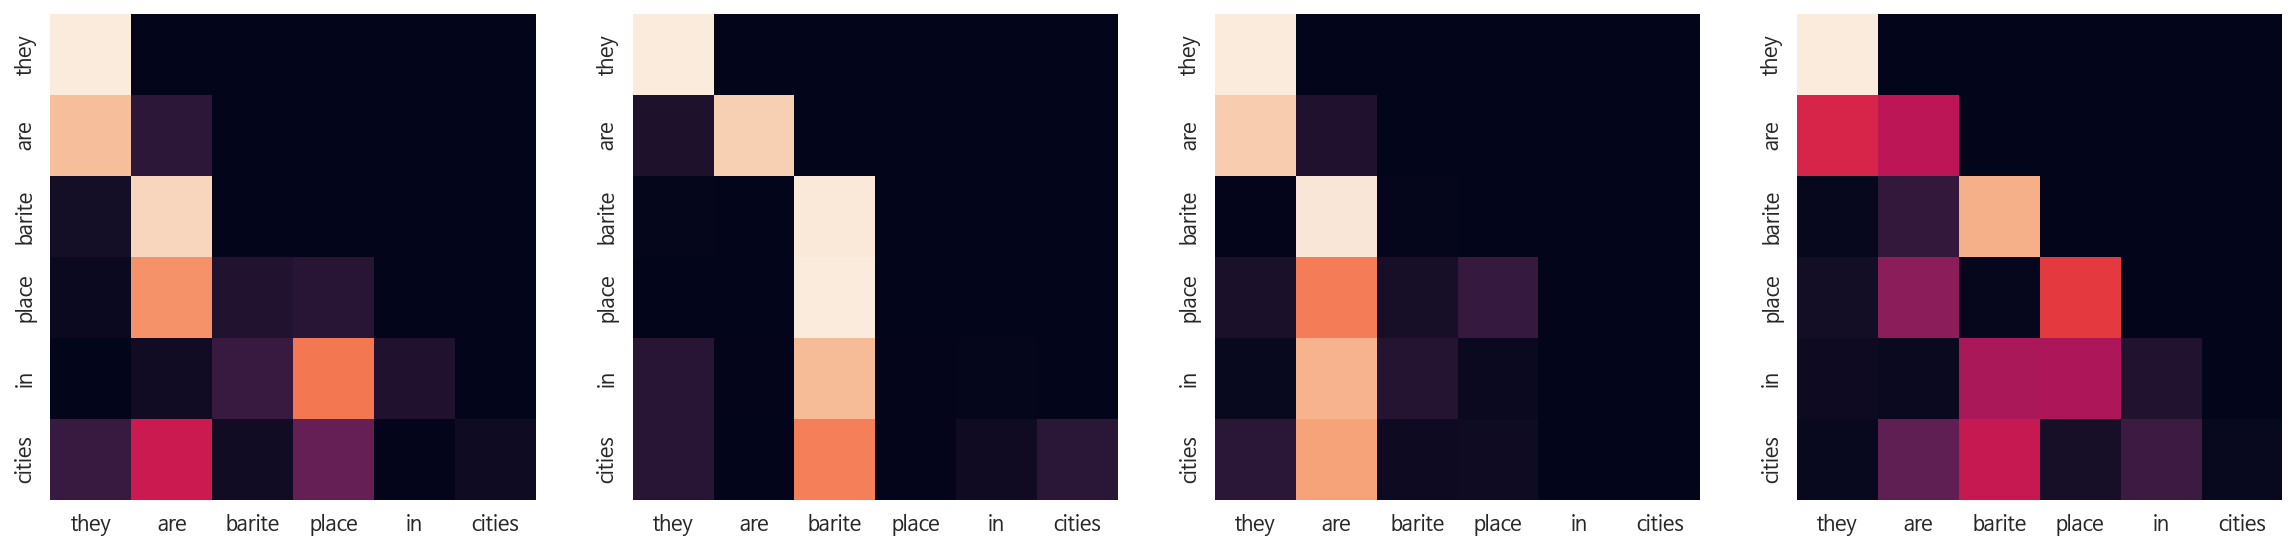

Decoder Src Layer 2


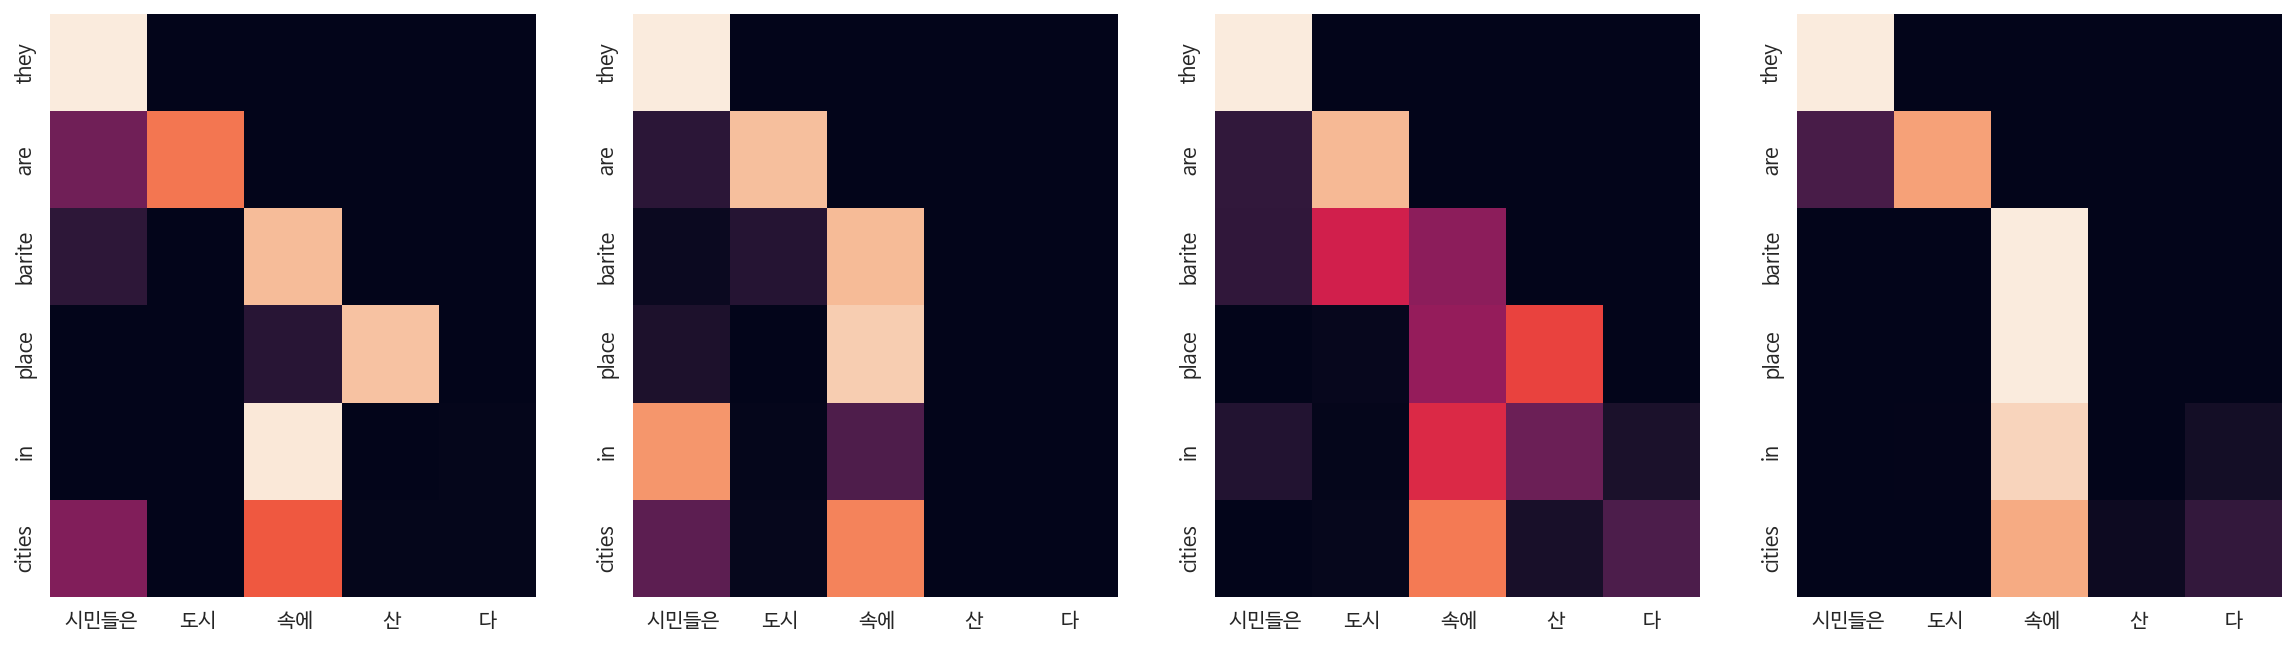

Input: 커피는 필요 없다.
Predicted translation: there need is need for coffee
Encoder Layer 1


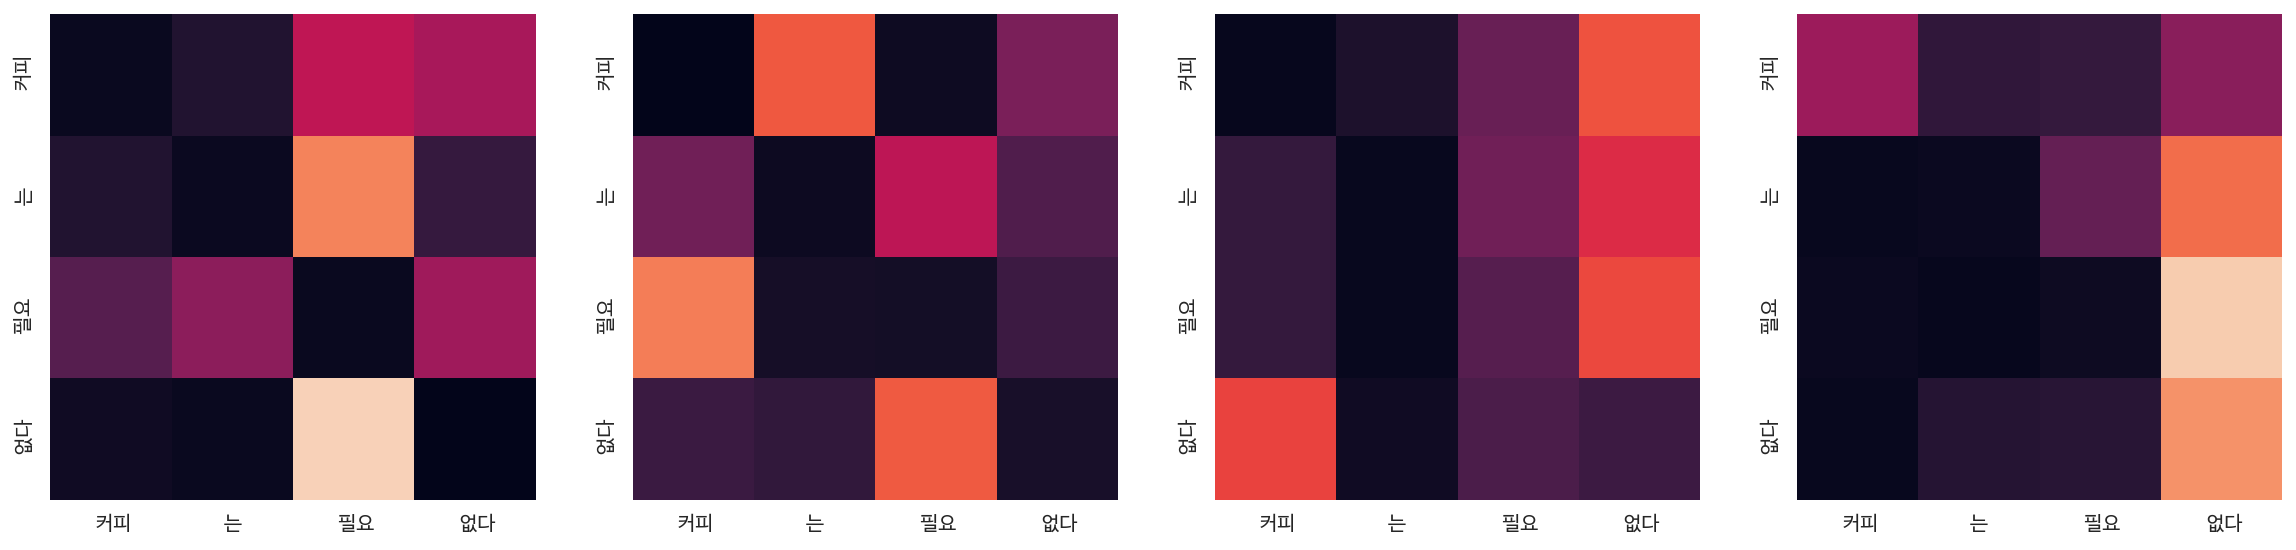

Encoder Layer 2


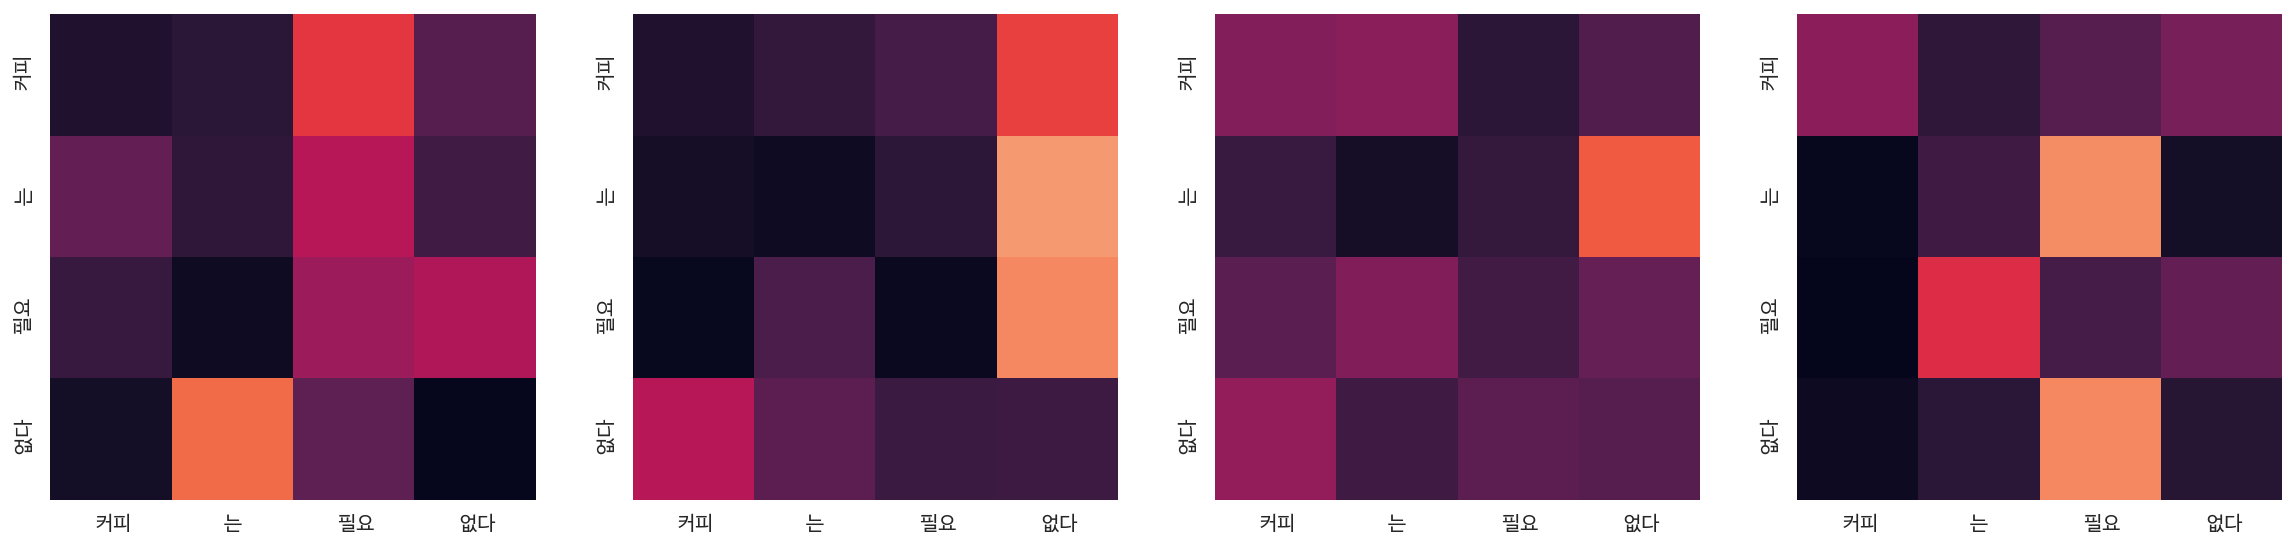

Decoder Self Layer 1


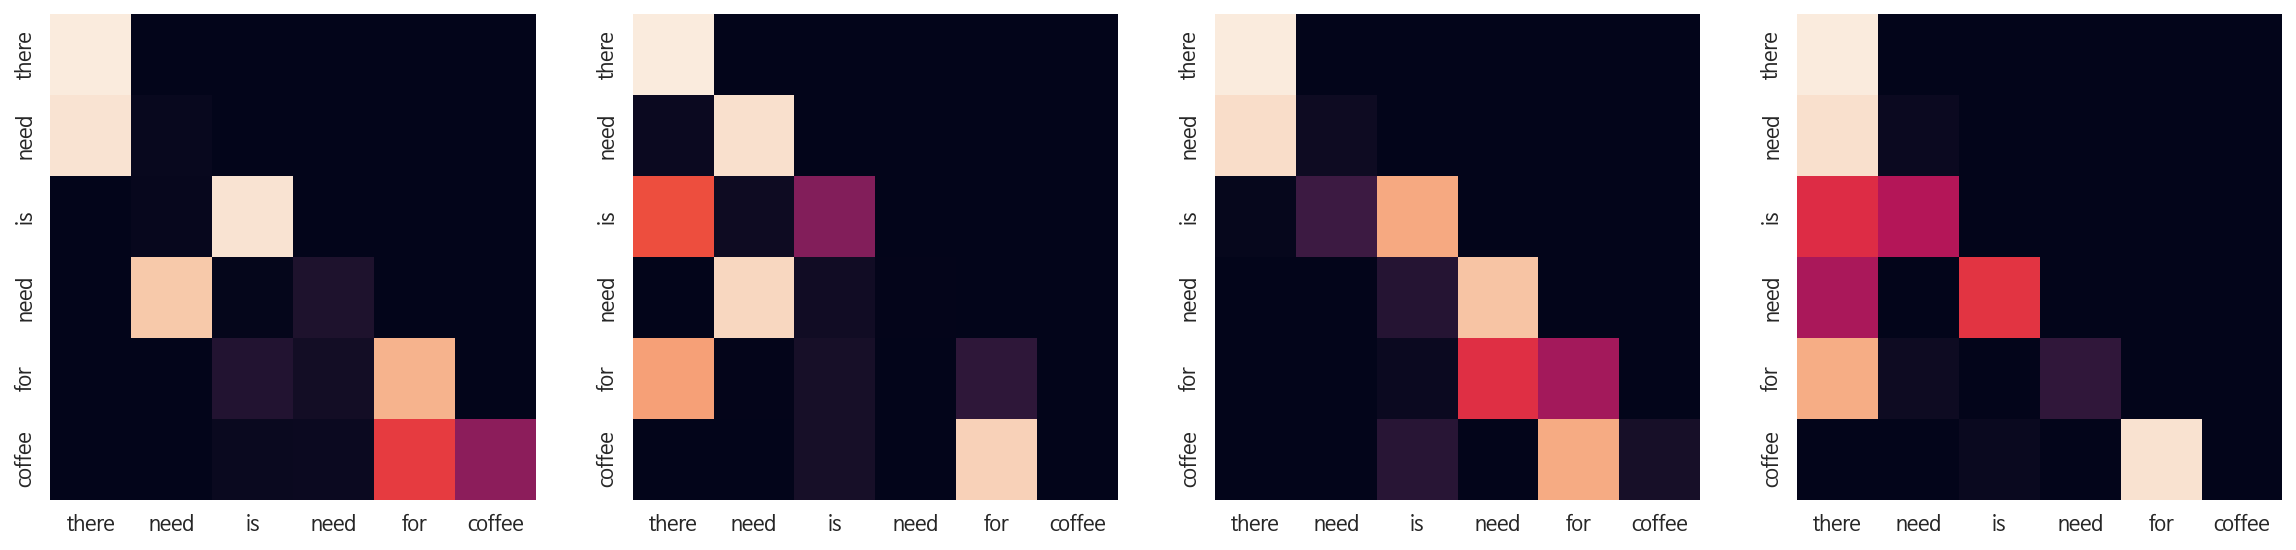

Decoder Src Layer 1


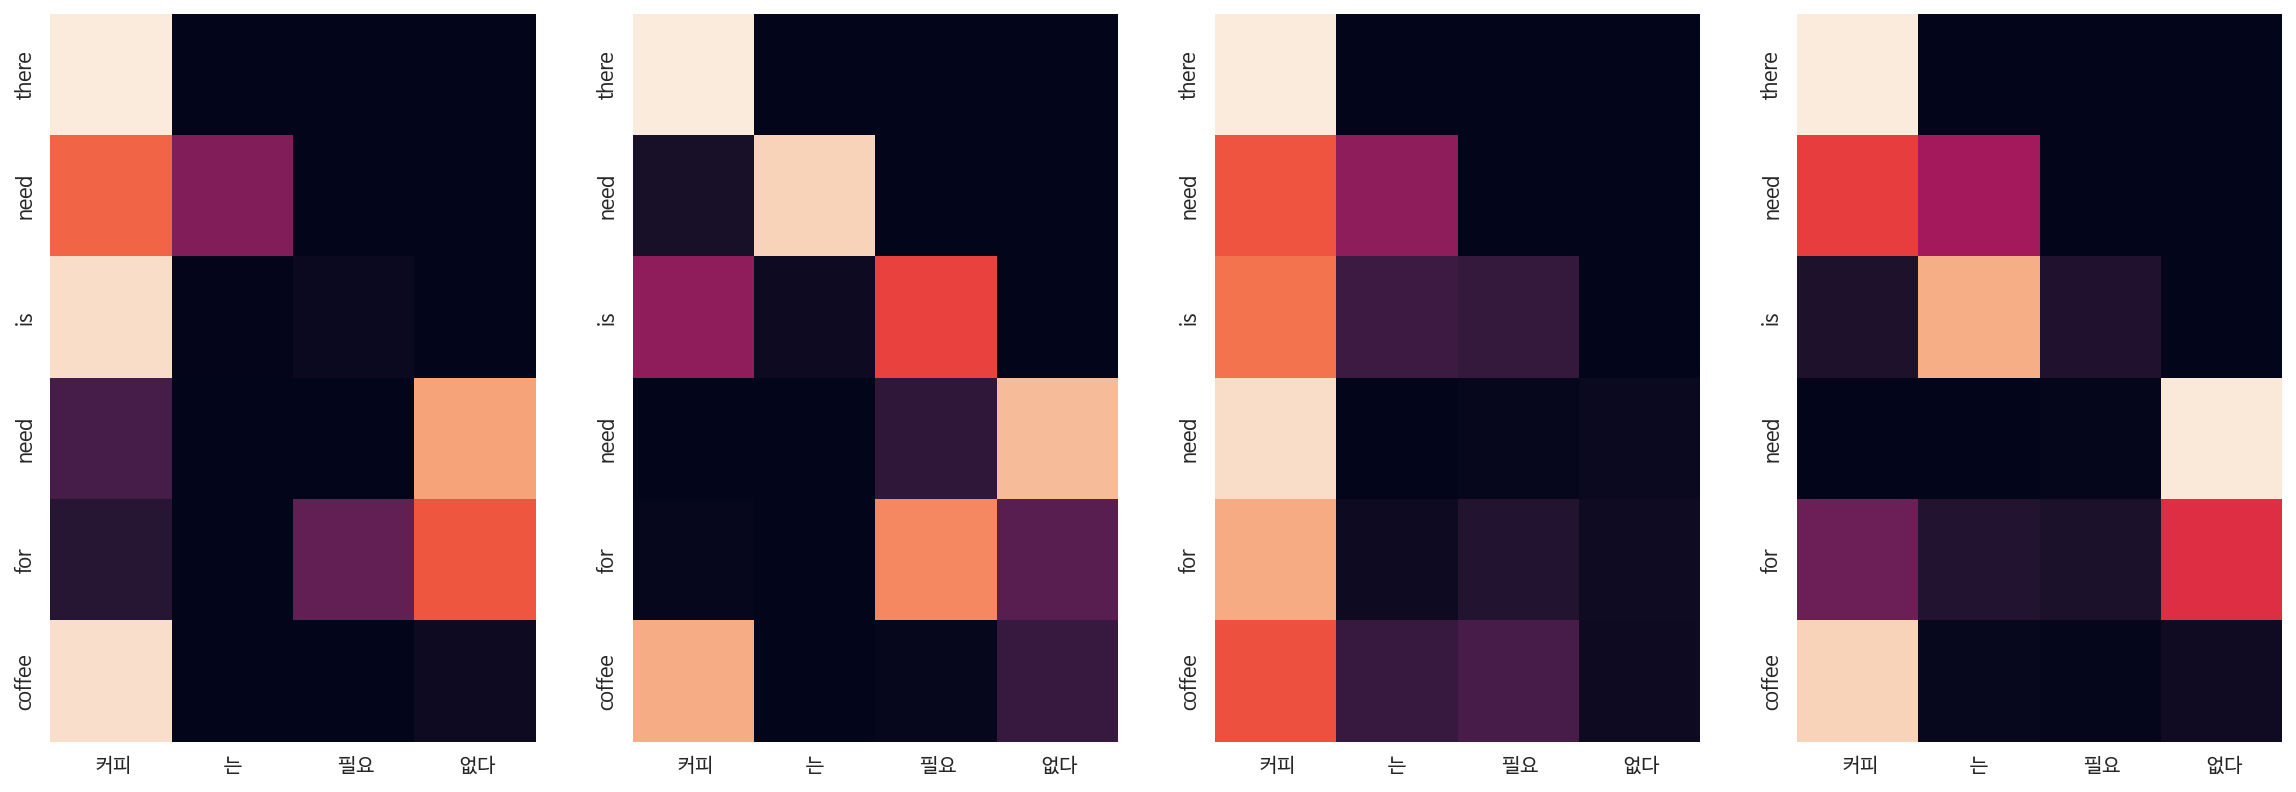

Decoder Self Layer 2


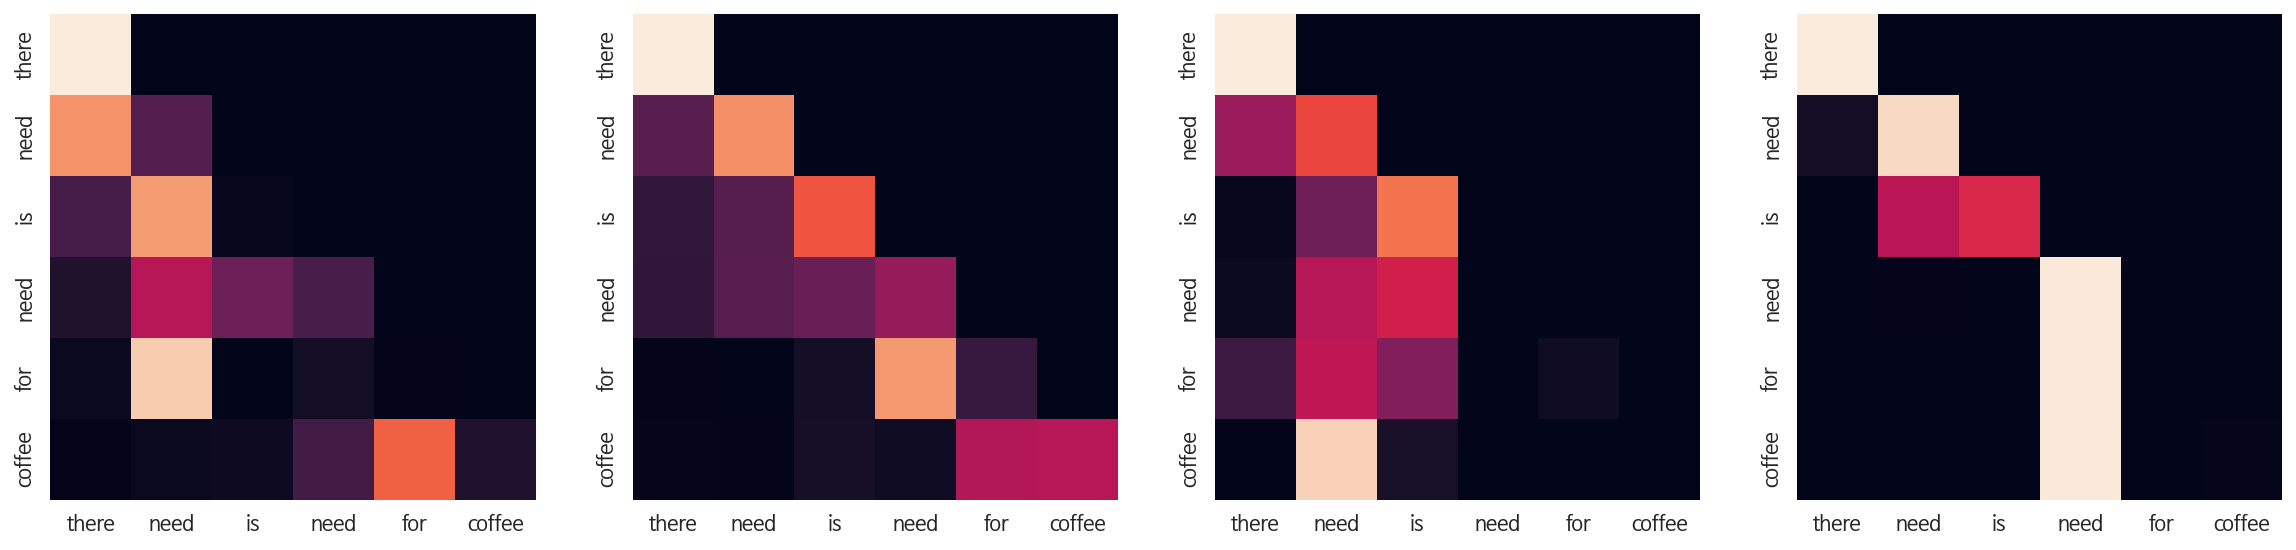

Decoder Src Layer 2


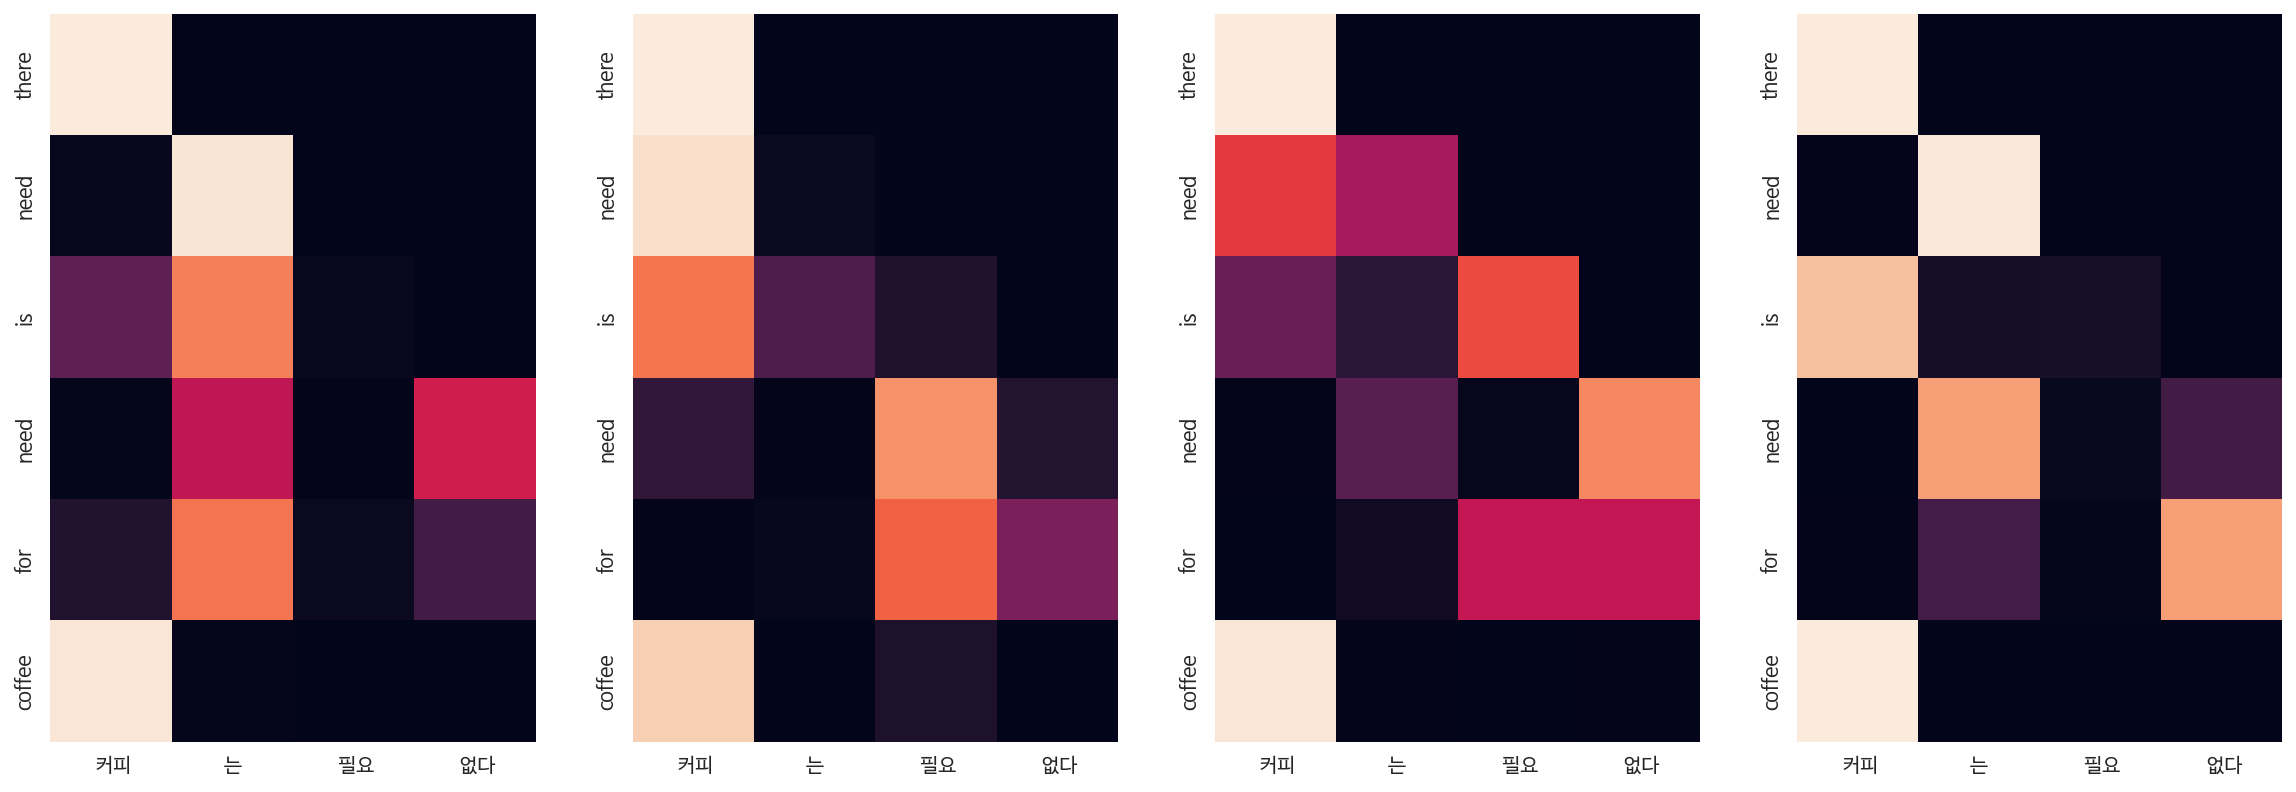

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed
Encoder Layer 1


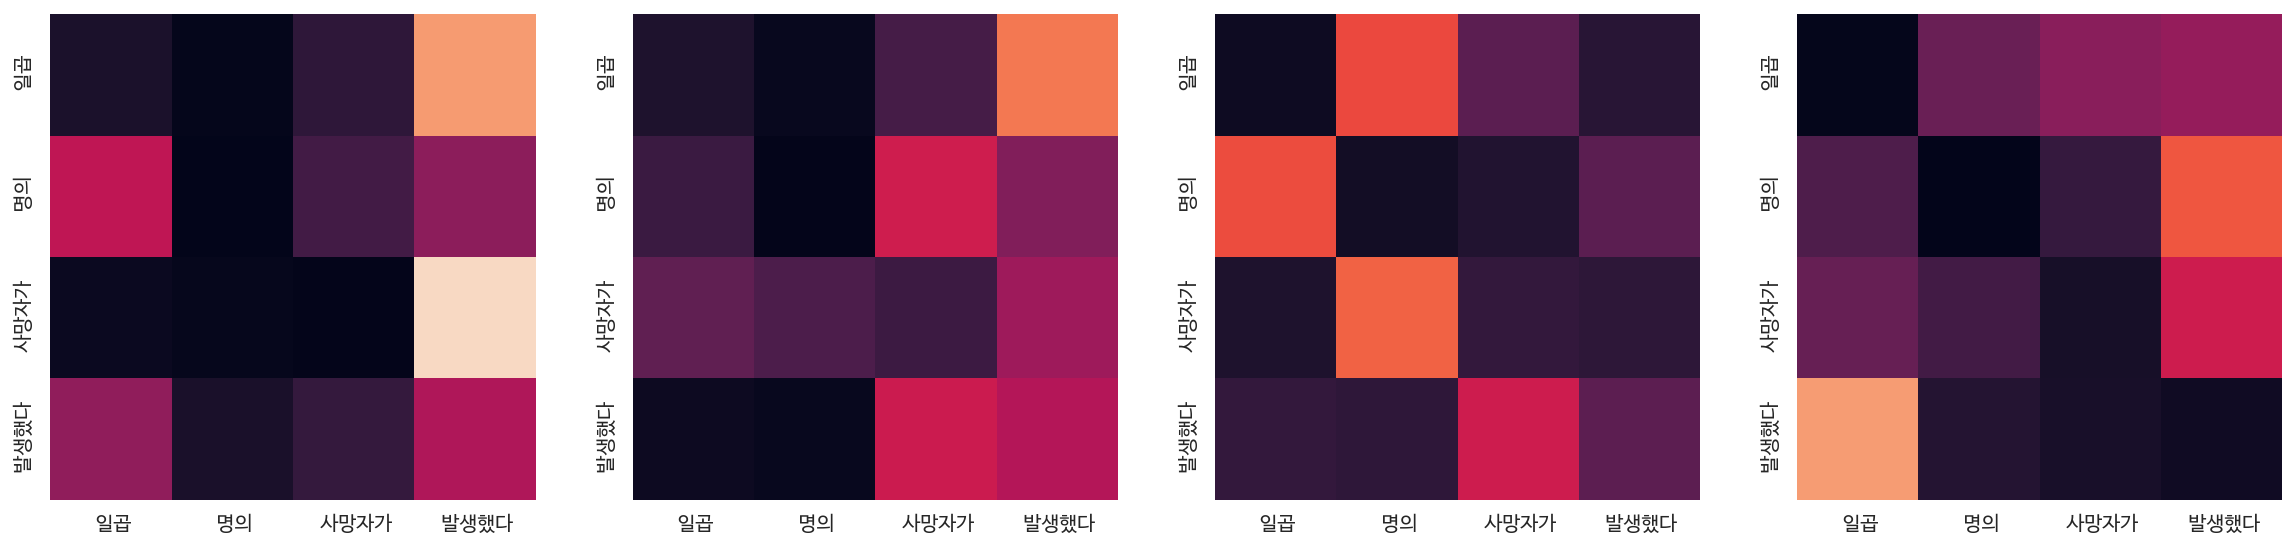

Encoder Layer 2


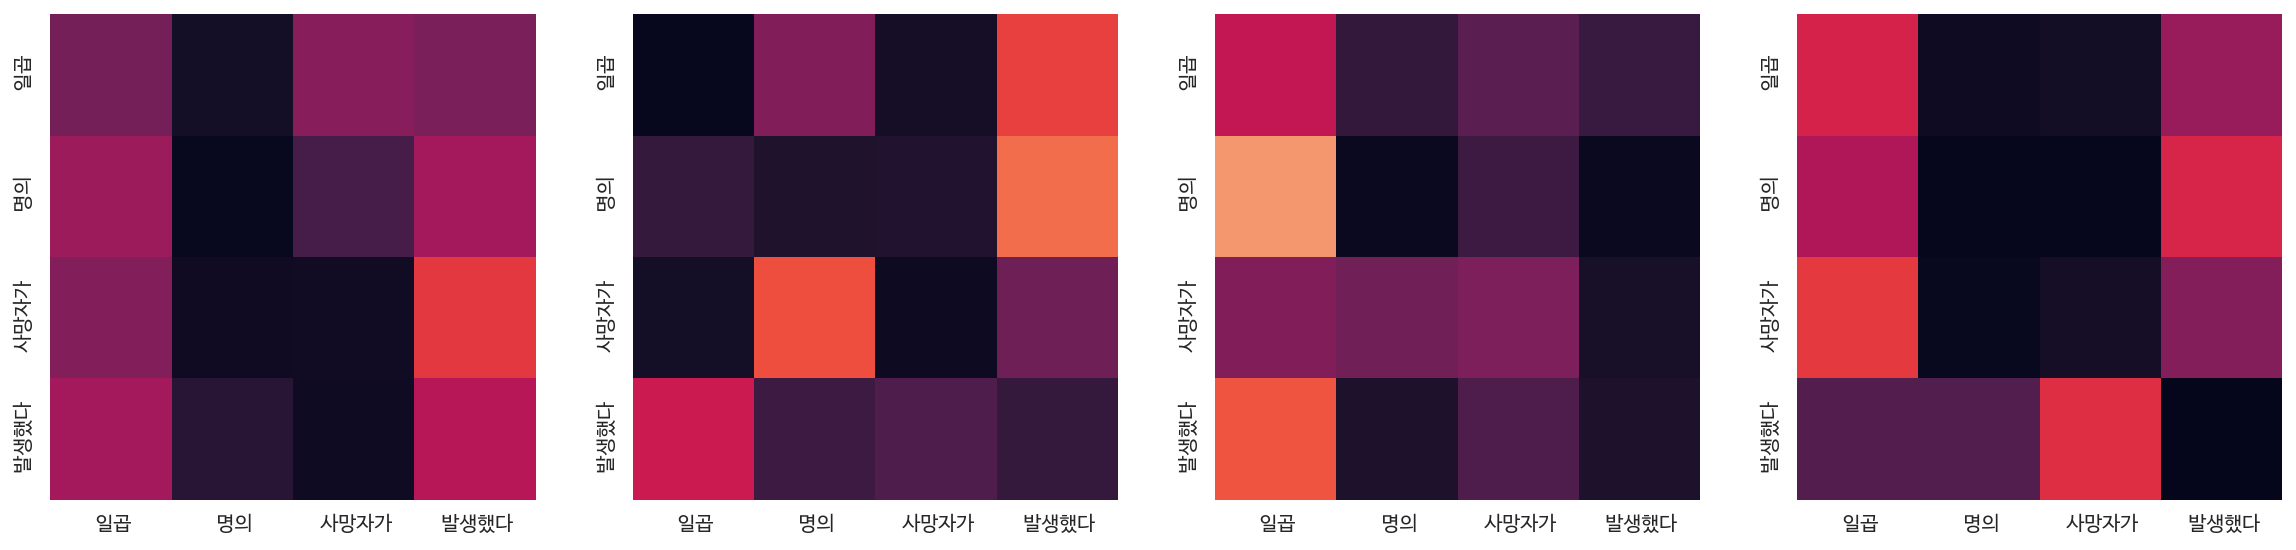

Decoder Self Layer 1


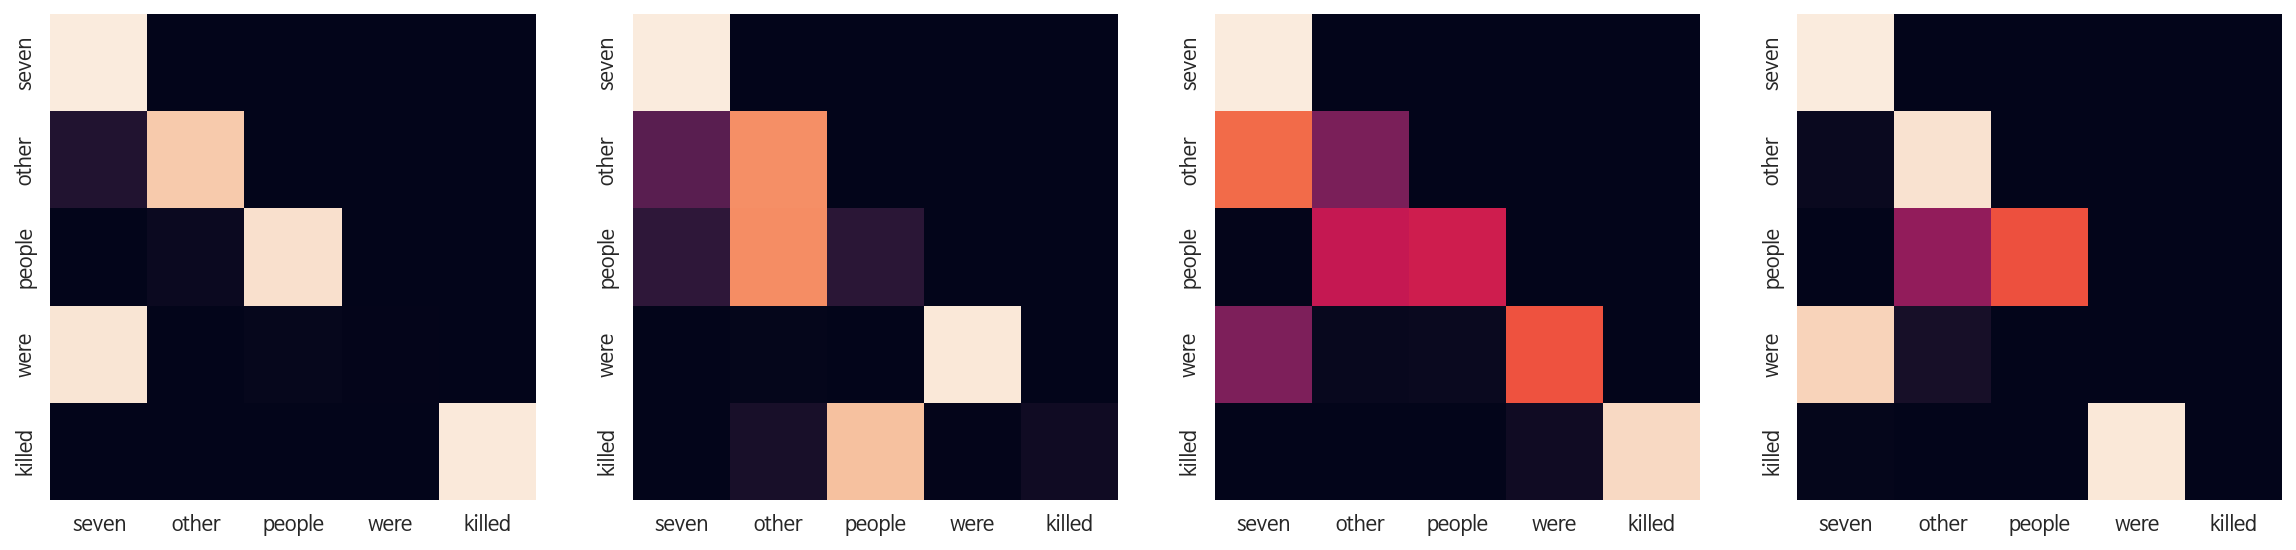

Decoder Src Layer 1


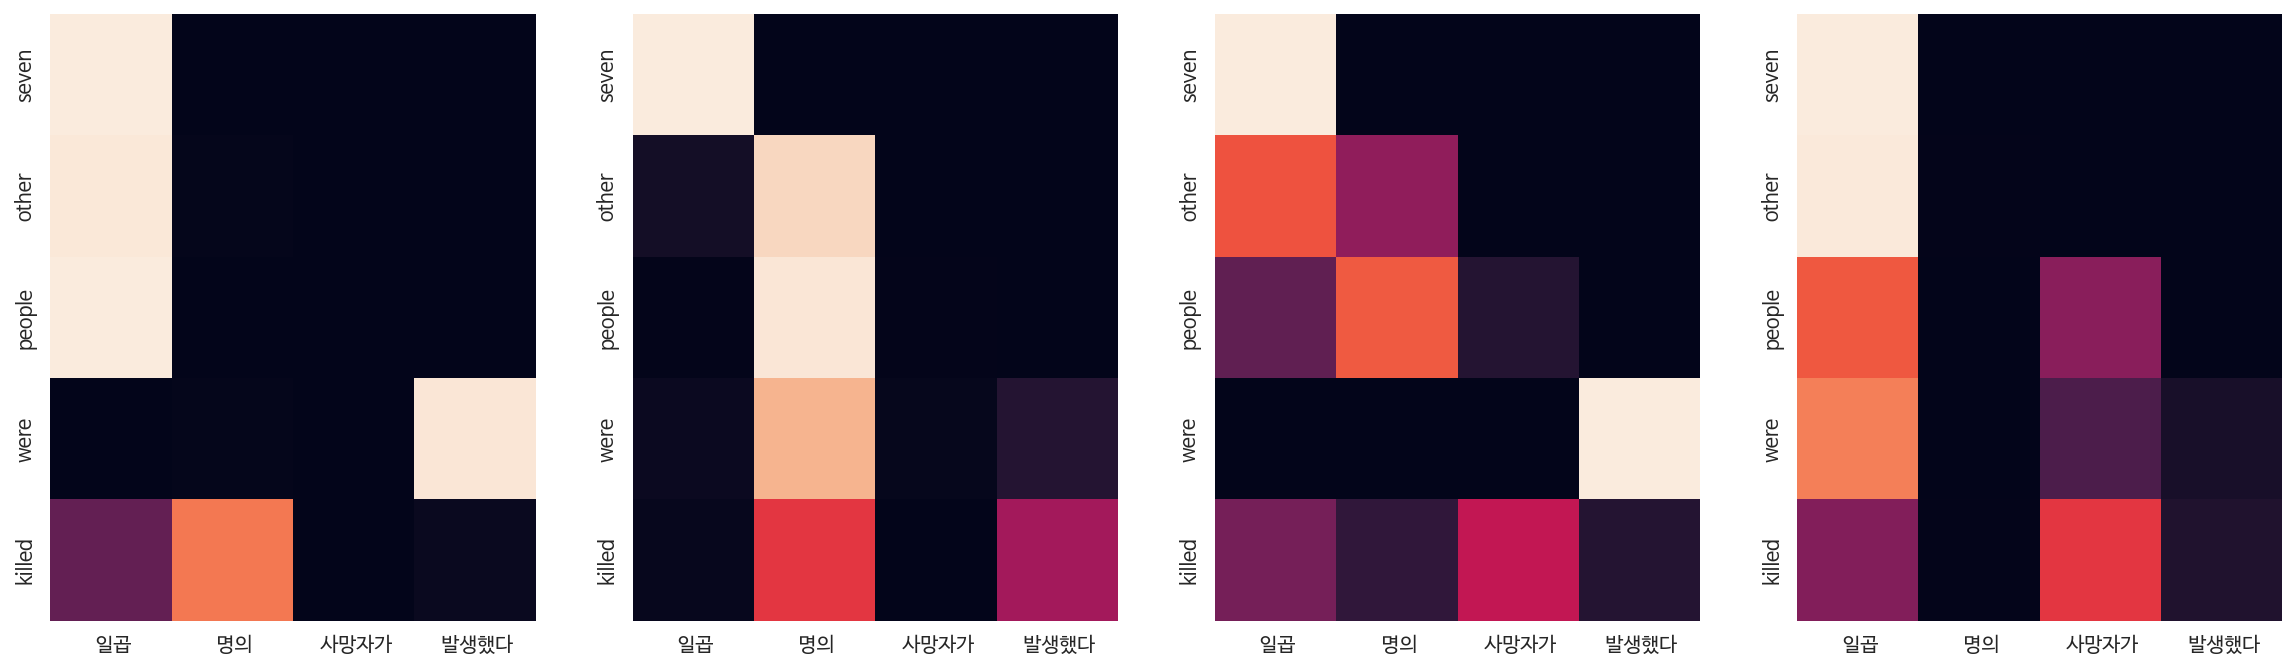

Decoder Self Layer 2


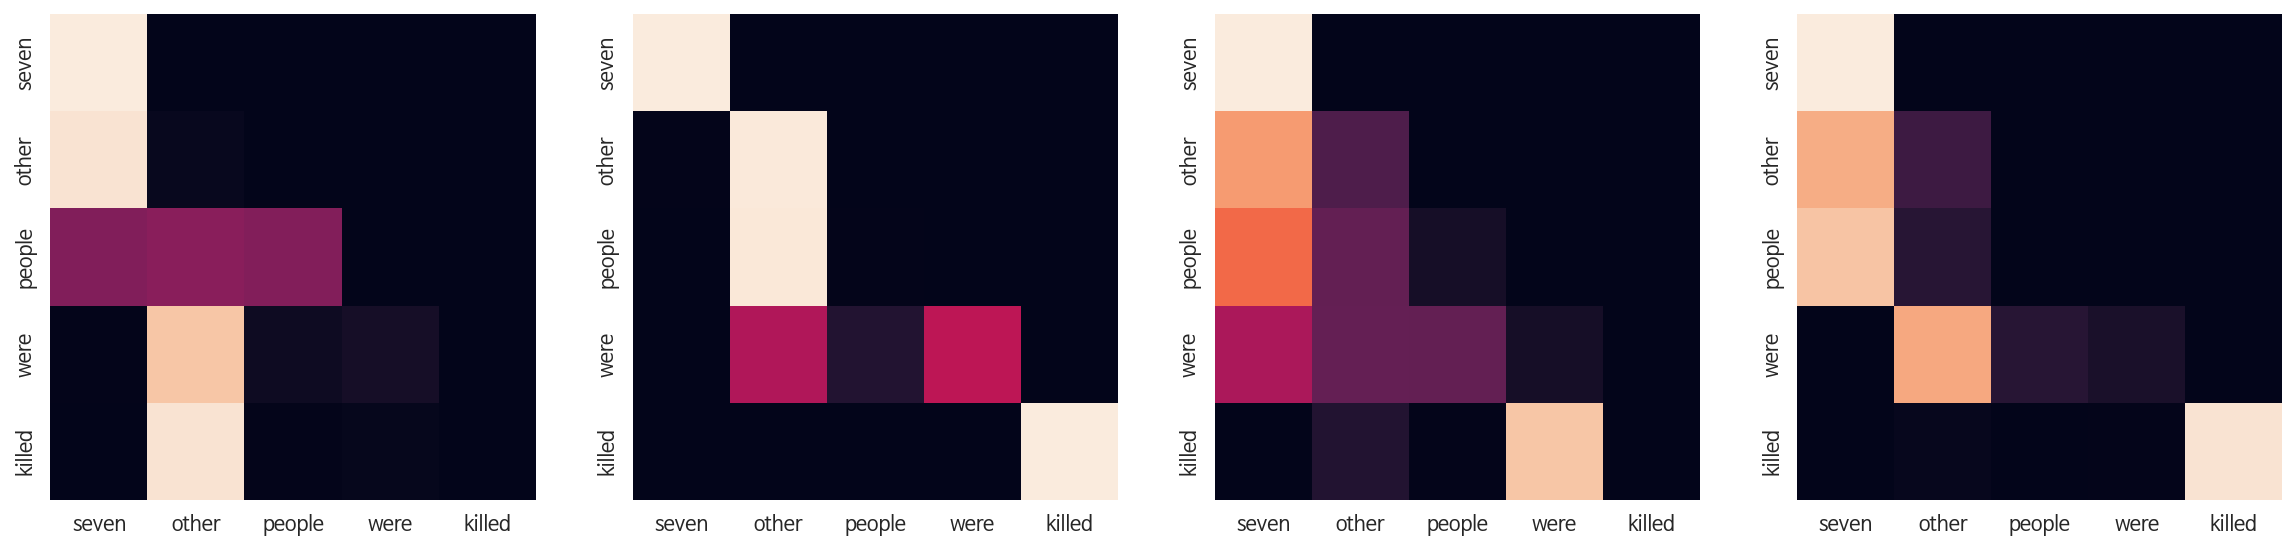

Decoder Src Layer 2


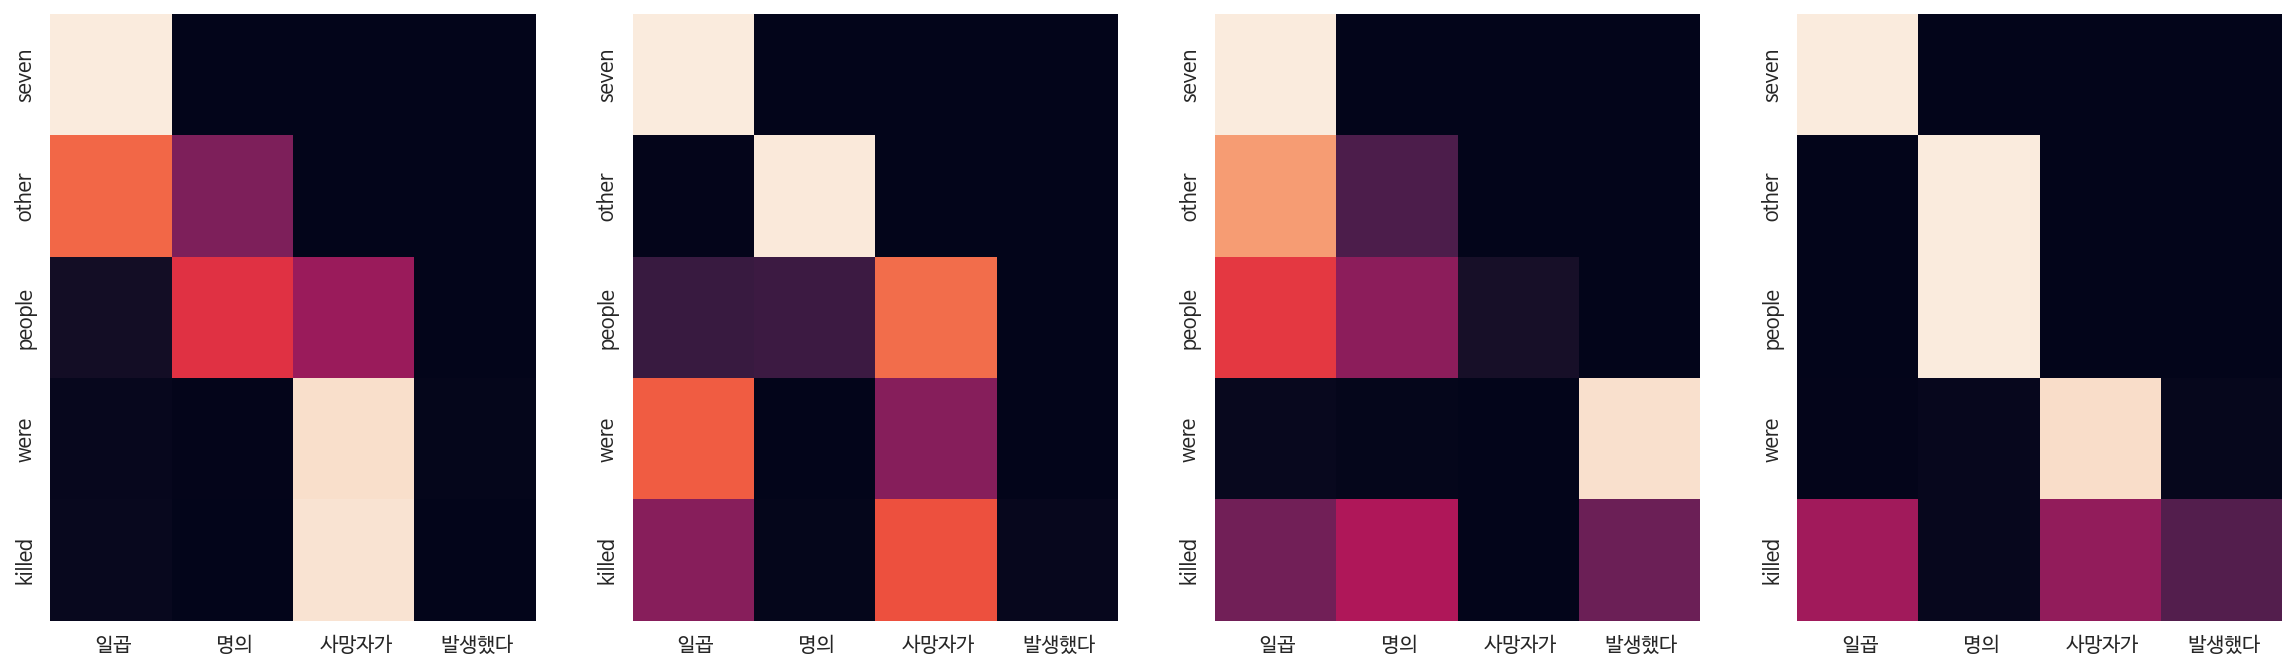

In [115]:
result = []
for example in examples:
    result.append(translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True))

In [55]:
losses_t03 = histories['t03']

In [82]:
loss_t03_sample = []
for i in range(63, len(losses_t03), loss_epoch):
    loss_t03_sample.append(losses_t03[i])

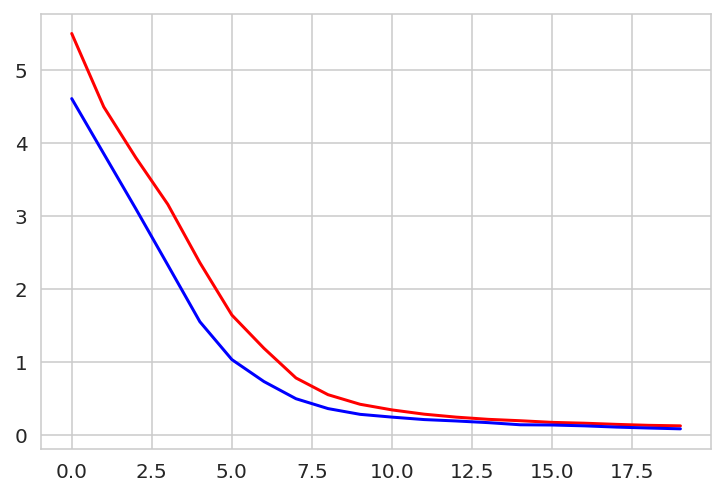

In [84]:
plt.plot(loss_t02_sample, 'r-')  # sentencepiece - unigram
plt.plot(loss_t03_sample, 'b-')  # sentencepiece - bpe

- 초반 epoch 10 까지는 bpe 방식이 조금 더 나은 결과를 보여준다.

> 핵심 키워드가 포함되기는 해서, 적어도 앞서서 구현한 seq2seq 모델보다는 나은 결과를 보여준다.  
> 오바마 - obama, 도시 - city, 필요 - need, 일곱 - seven, 사망자 - killed  
> 학습이 진행되면서 결과가 좀 더 안 좋아지기도 한다.  
> 과대적합때문일 수도 있겠지만, 더 나은 결과를 보여주는 문장도 있어서 꼭 그렇다라고도 보기는 애매하다.  

## Save Results

#### model

In [123]:
transformer.save_weights(f"{prefix}_transformer_{postfix}.ckpt")

#### histories

In [47]:
histories = load_var("histories")

In [48]:
histories.keys()

dict_keys(['t02', 't03'])

In [109]:
histories[prefix] = losses

In [111]:
save_var(histories, f"histories")

#### training_results

In [102]:
training_results = load_var("training_results")

In [137]:
training_results.keys()

dict_keys(['t03'])

In [132]:
training_results[prefix] = training_result

In [134]:
save_var(training_results, f"training_results")

#### test_results

In [50]:
test_results = load_var("test_results")

In [124]:
test_results.keys()

dict_keys(['t02', 't03'])

In [118]:
test_results[prefix] = result

In [119]:
save_var(results, f"test_results")